In [2]:
#!pip3 install scipy statsmodels --upgrade
#!pip install pmdarima
#!pip install sktime
#!pip install holidays

#!pip install tensorflow
#!pip install keras

In [3]:
# Import libraries & packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import holidays
import statsmodels.api as sm
import pmdarima as pm

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  
from sktime.utils.plotting import plot_series
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from pylab import rcParams
from fbprophet import Prophet
from fbprophet.plot import plot_components, plot_forecast_component
from statsmodels.tools.eval_measures import rmse
from pmdarima.utils import tsdisplay
from statsmodels.tsa.stattools import adfuller
from scipy.stats import shapiro
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

import warnings 
warnings.filterwarnings('ignore')

# **Summary Observations**

Time-series refers to a set of statistical information collected at regular intervals of time, arranged in chronological order. 

By analyzing time series, we are able to understand, interpret and evaluate changes in the data, in hope of correctly anticipating the course of future events based on previously observed values.

From our analysis, we knew that our data have time elements that fulfil time series requirements and proceeded to model our predictions and forecast on crime rates based on a time-series algorithm, to predict and forecast crime rates.

In time-series modelling, it can be divided into 2 types, traditional time-series models and machine learning models. 

## **Following are the types of models used:**

### **Time-series models:**
- Simple Exponential Smoothing
- Holt Winters Exponential Smoothing
- ARIMA
- SARIMA
- SARIMAX
- Facebook Prophet

### **Machine learning regression models:**
- Linear Regression
- Ridge Regression
- Lasso Regression
- Random Forest
- Gradient Boosting
- Adaptive Boosting
- XG Boost

**Note:**

Conclusion of best models mentioned in Regression notebook

# **Crime - Theft**

In [4]:
theft = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/capstone/assets/clean_data/2010_2021_theft_monthly.csv', index_col='date', parse_dates=True)

### Data Summary

In [5]:
theft.head()

primary_type  afternoon  evening  ...  45to54  65to74  75andmore
date                                          ...                           
2010-01-31          6038       2244     1496  ...  342384  151070     129473
2010-02-28          4781       1889     1159  ...  342384  151070     129473
2010-03-31          6049       2283     1587  ...  342384  151070     129473
2010-04-30          6102       2237     1611  ...  342384  151070     129473
2010-05-31          6684       2466     1801  ...  342384  151070     129473

[5 rows x 203 columns]

In [6]:
# Theft information
theft.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 151 entries, 2010-01-31 to 2022-07-31
Columns: 203 entries, primary_type to 75andmore
dtypes: float64(2), int64(201)
memory usage: 240.7 KB


In [7]:
theft_ori = theft.copy()

In [8]:
# Remove forecast dates (Require only when using SARIMAX)
theft = theft[:-12]

theft.index.freq = 'M'

## Understanding Theft Rates 

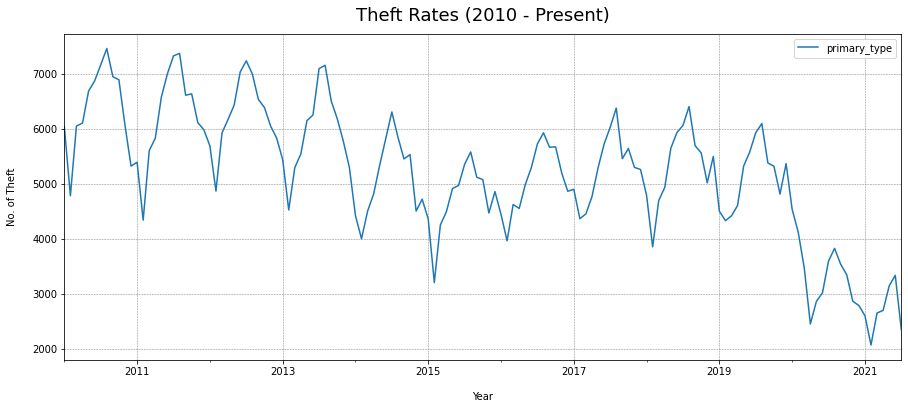

In [9]:
# Theft rates based on from 2010 - present
theft_rates = theft[['primary_type']]

# Plot crime rates from dataset
theft_rates.plot(figsize=(15,6))
plt.title('Theft Rates (2010 - Present)', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

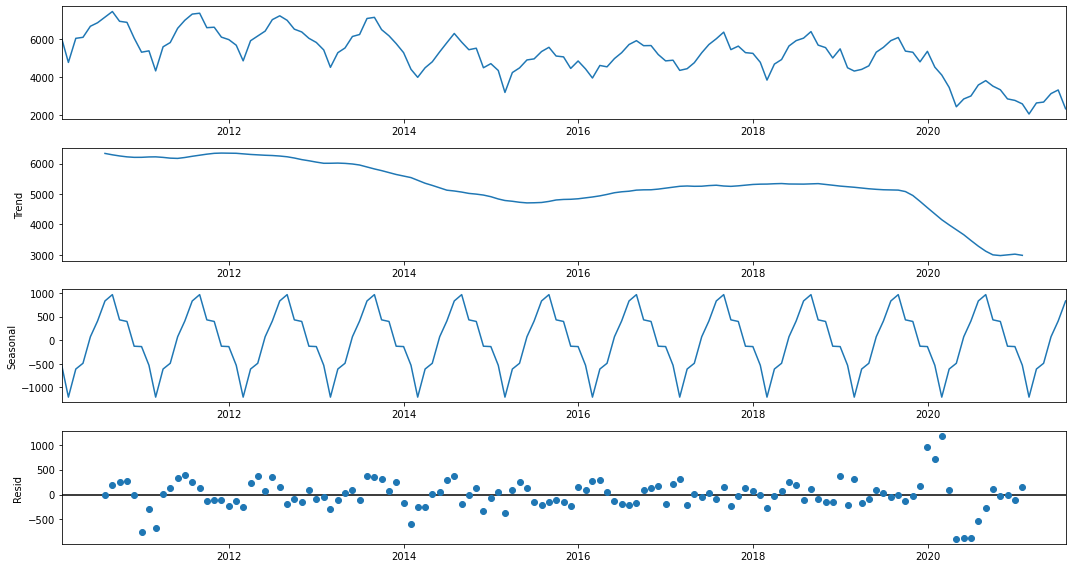

In [10]:
# ETS decomposition
rcParams['figure.figsize'] = 15,8
sm.tsa.seasonal_decompose(theft_rates).plot();

In [11]:
# Function for adfuller test
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print('')
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print('')
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [12]:
# Test for stationarity
adf_test(theft_rates)

Augmented Dickey-Fuller Test: 
ADF test statistic        0.646771
p-value                   0.988713
# lags used              12.000000
# observations          126.000000
critical value (1%)      -3.483346
critical value (5%)      -2.884766
critical value (10%)     -2.579156

Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


### Differencing Data

In [13]:
theft_diff = theft_rates.copy()

In [14]:
# Assign both degree of diff() to columns 
theft_diff['first_diff_crime'] = theft_diff['primary_type'].diff()
theft_diff['second_diff_crime'] = theft_diff['primary_type'].diff().diff()

First Difference

In [15]:
# Stationary Test for first diff()
adf_test(theft_diff['first_diff_crime'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -3.292734
p-value                   0.015206
# lags used              11.000000
# observations          126.000000
critical value (1%)      -3.483346
critical value (5%)      -2.884766
critical value (10%)     -2.579156

Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


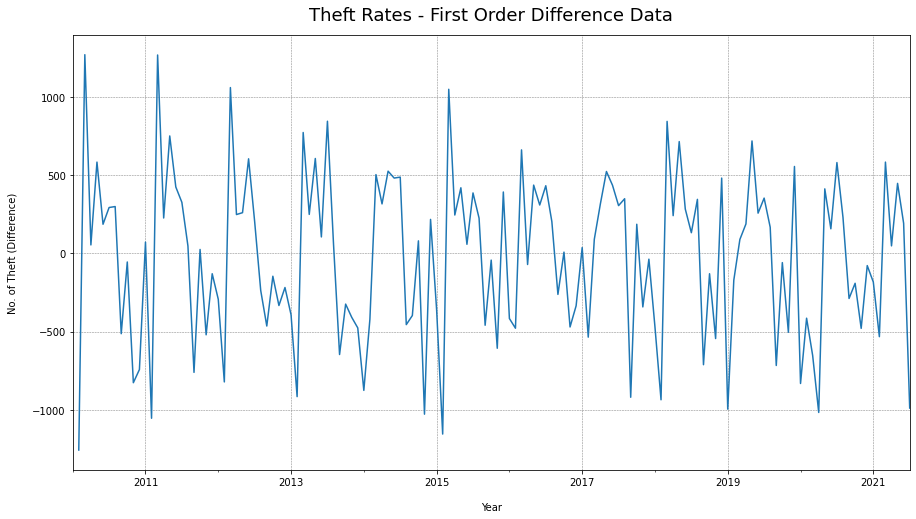

In [16]:
# Plot first diff()
theft_diff['first_diff_crime'].plot()
plt.title('Theft Rates - First Order Difference Data', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft (Difference)', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

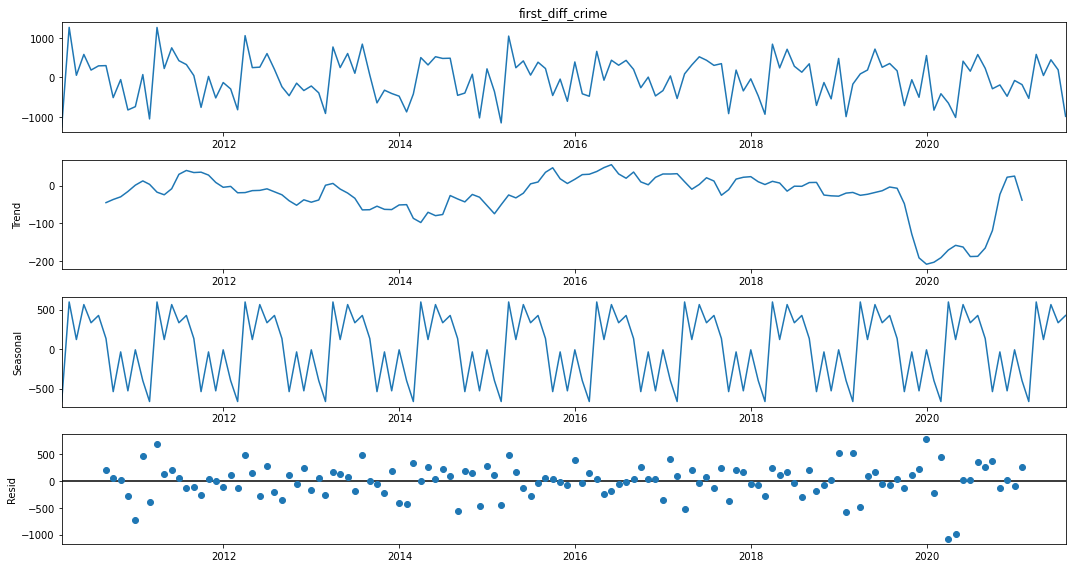

In [17]:
# Drop null values
first_diff = theft_diff['first_diff_crime']
first_diff.dropna(inplace=True)

# ETS decomposition - First Difference
rcParams['figure.figsize'] = 15,8
sm.tsa.seasonal_decompose(first_diff).plot();

Second Difference

In [18]:
# Stationary Test for second diff()
adf_test(theft_diff['second_diff_crime'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -9.307673e+00
p-value                 1.069842e-15
# lags used             1.100000e+01
# observations          1.250000e+02
critical value (1%)    -3.483779e+00
critical value (5%)    -2.884954e+00
critical value (10%)   -2.579257e+00

Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


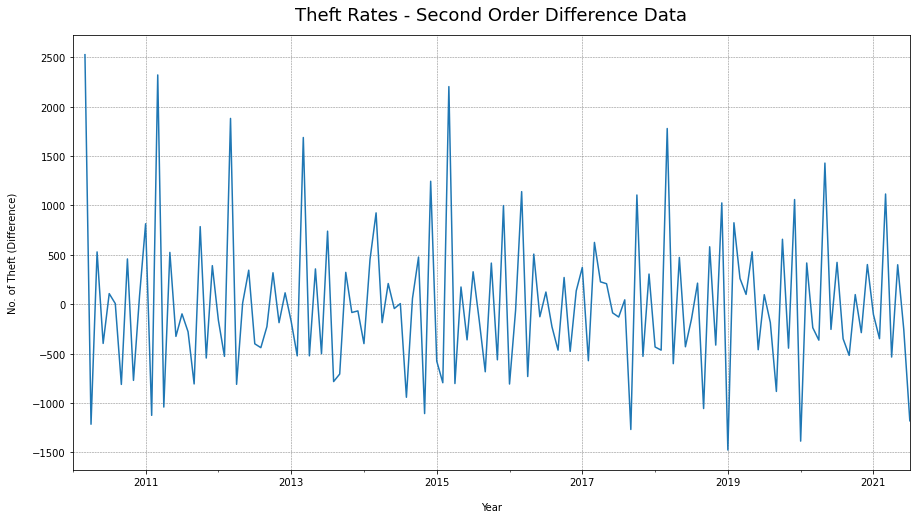

In [19]:
# Plot second diff()
theft_diff['second_diff_crime'].plot()
plt.title('Theft Rates - Second Order Difference Data', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft (Difference)', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

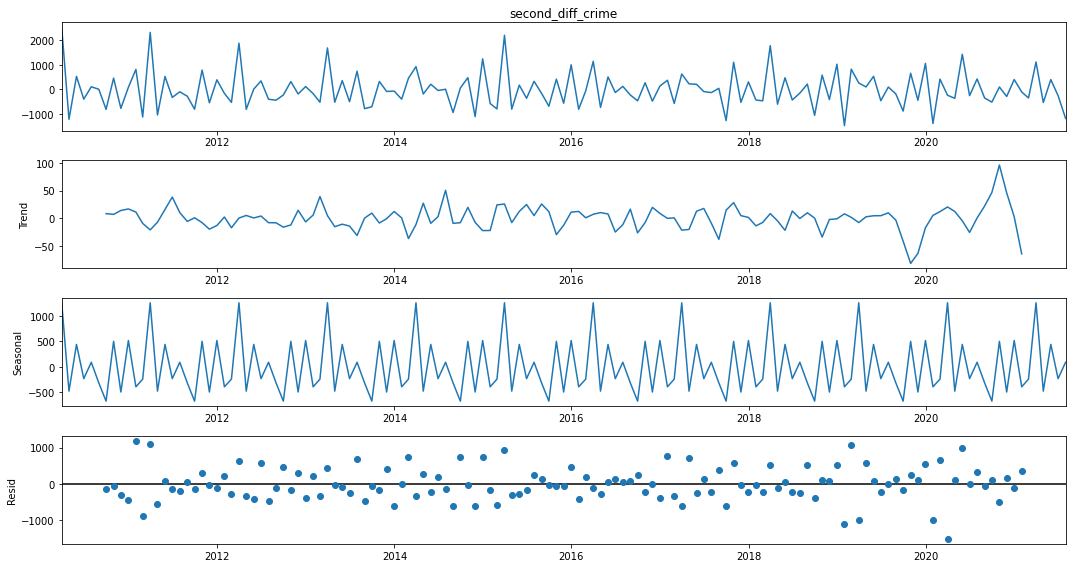

In [20]:
# Drop null values
second_diff = theft_diff['second_diff_crime']
second_diff.dropna(inplace=True)

# ETS decomposition - Second Difference
rcParams['figure.figsize'] = 15,8
sm.tsa.seasonal_decompose(second_diff).plot();

### Normality Test

In [21]:
# Function for Normality Test
def normaltest(df):
  stat, p = shapiro(df)
  print('stat=%.3f, p=%.3f\n' % (stat, p))

  if p > 0.05:
    print('Probably Gaussian')
  else:
    print('Probably not Gaussian')

# Ref: https://towardsdatascience.com/normality-tests-in-python-31e04aa4f411

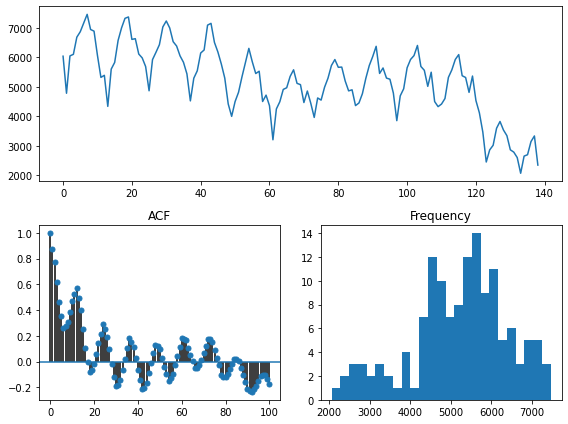

In [22]:
# Understanding the frequency of Theft
tsdisplay(theft_rates, lag_max=100)

In [23]:
# Normality Test on Theft (Original)
normaltest(theft_rates)

stat=0.973, p=0.007

Probably not Gaussian


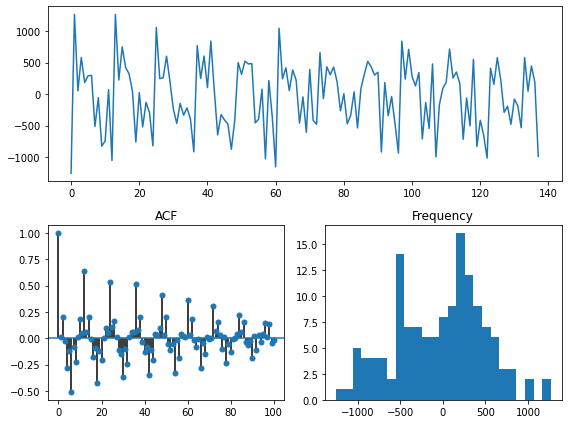

In [24]:
# Understanding the frequency of Theft with First Diff
tsdisplay(first_diff, lag_max=100)

In [25]:
# Normality Test on Theft (First Difference)
normaltest(first_diff)

stat=0.984, p=0.120

Probably Gaussian


## **Time-Series Modelling**

### Train Test Split

In [26]:
# Train Test Split
train_theft = theft_rates[:'2019-01-01']
test_theft = theft_rates['2018-11-30':]

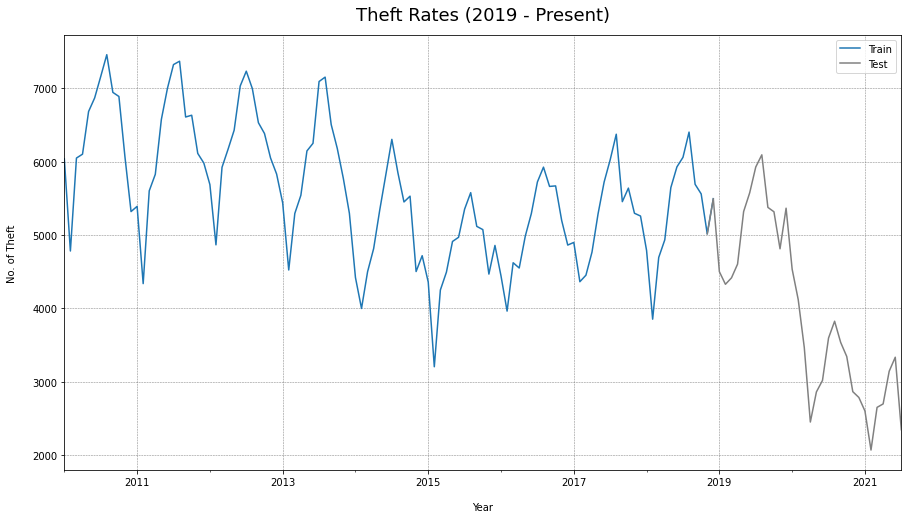

In [27]:
# Check the split
train_theft['primary_type'].plot(figsize=(15, 8), label='Train')
test_theft['primary_type'].plot(label='Test', color='grey')

plt.title('Theft Rates (2019 - Present)', fontsize=18, y=1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.legend(loc='best')
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show();

# Gap among the different dataset in graph is caused by monthly count of dataset (end month)

### ACF & PACF

<Figure size 1080x576 with 0 Axes>

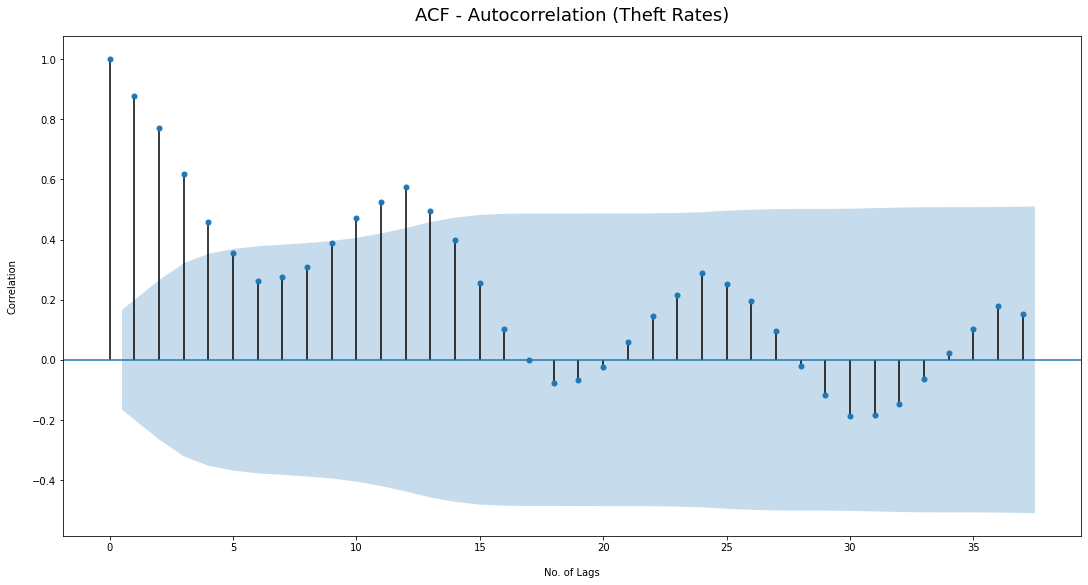

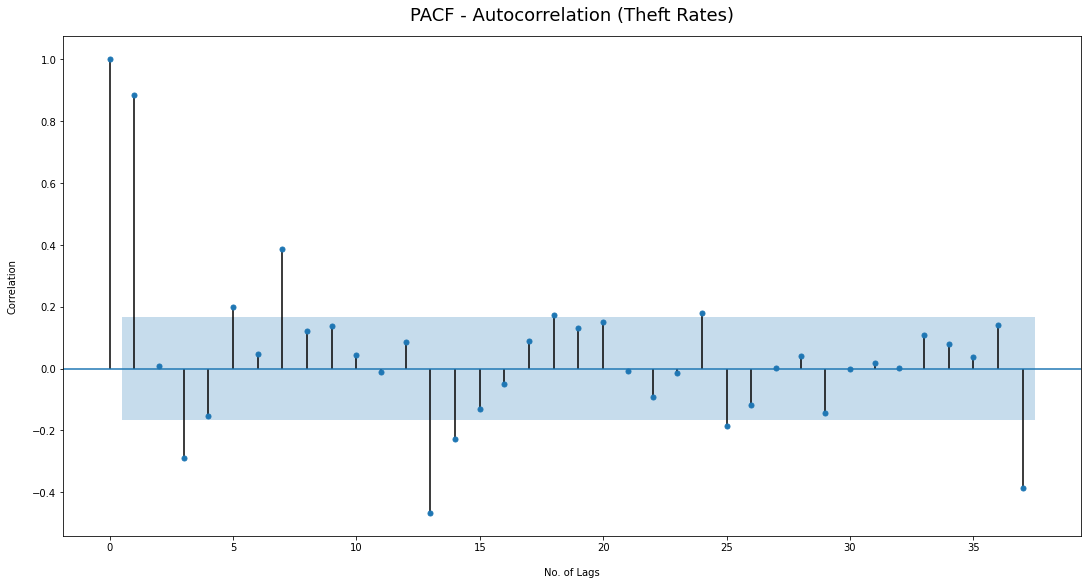

In [28]:
# Plot ACF & PACF for Theft
plt.figure(figsize=(15,8))
plot_acf(theft_rates['primary_type'], lags=37)

plt.title('ACF - Autocorrelation (Theft Rates)', fontsize=18, y=1.02)
plt.xlabel('No. of Lags', labelpad=15)
plt.ylabel('Correlation', labelpad=15)
plt.tight_layout(pad=0.3)

plot_pacf(theft_rates['primary_type'], lags=37)

plt.title('PACF - Autocorrelation (Theft Rates)', fontsize=18, y=1.02)
plt.xlabel('No. of Lags', labelpad=15)
plt.ylabel('Correlation', labelpad=15)
plt.tight_layout(pad=0.3);

<Figure size 1080x576 with 0 Axes>

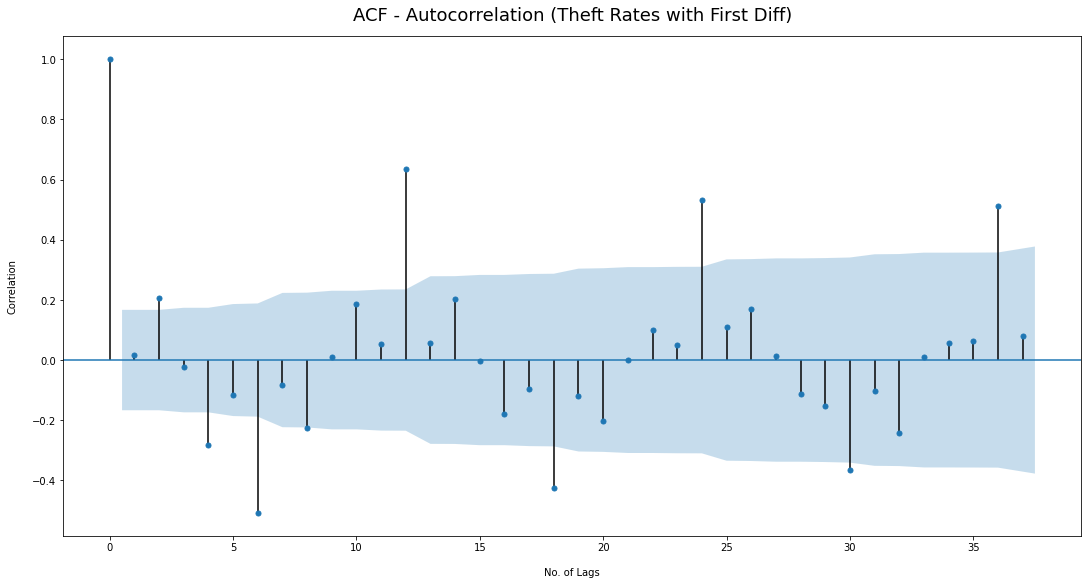

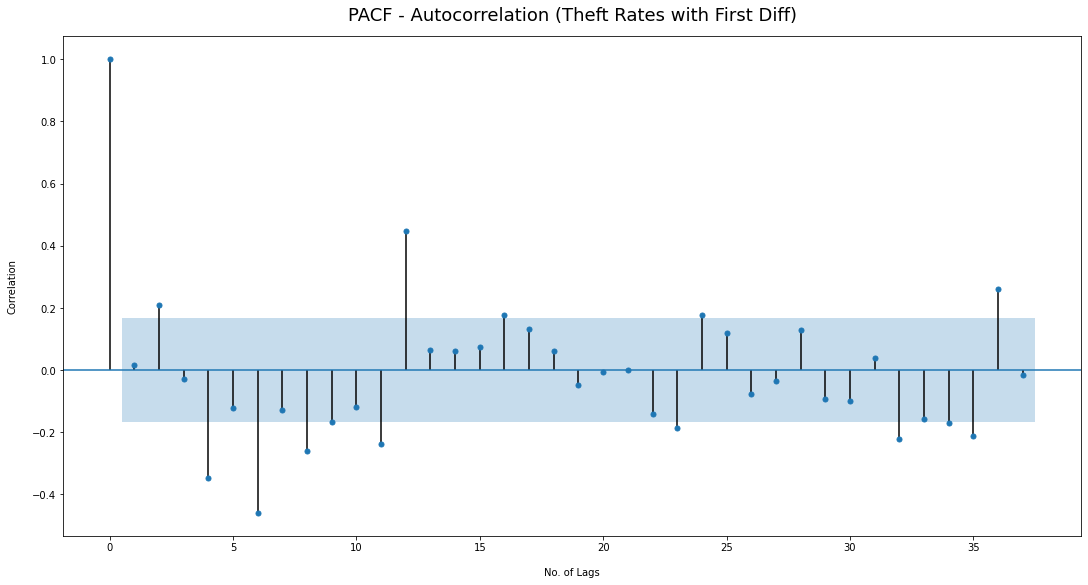

In [29]:
# Plot ACF & PACF Theft with First Diff
first_diff = pd.DataFrame(first_diff)

plt.figure(figsize=(15,8))
plot_acf(first_diff['first_diff_crime'], lags=37)

plt.title('ACF - Autocorrelation (Theft Rates with First Diff)', fontsize=18, y=1.02)
plt.xlabel('No. of Lags', labelpad=15)
plt.ylabel('Correlation', labelpad=15)
plt.tight_layout(pad=0.3)

plot_pacf(first_diff['first_diff_crime'], lags=37)

plt.title('PACF - Autocorrelation (Theft Rates with First Diff)', fontsize=18, y=1.02)
plt.xlabel('No. of Lags', labelpad=15) 
plt.ylabel('Correlation', labelpad=15)
plt.tight_layout(pad=0.3);

### Simple Exponential Smoothing

- Technique forecasts the next value using a weighted average of all previous values where the weights decay exponentially from the most recent to the oldest historical value.

In [30]:
# Ref: https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/

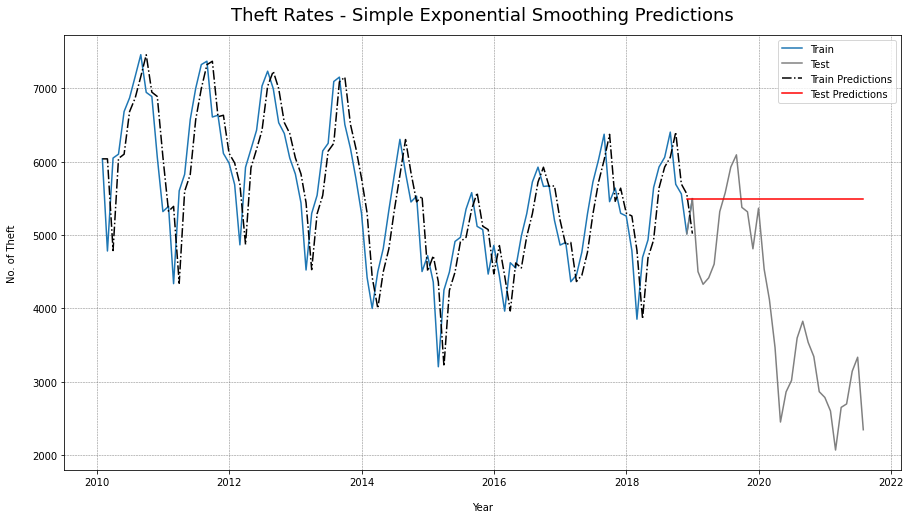

In [31]:
# Instantiate SES
ses = SimpleExpSmoothing(train_theft['primary_type'])

# Fit model
model = ses.fit()

# Determine len of predictions
start = len(train_theft)
end = len(train_theft) + len(test_theft) - 1

# Generate predictions based on train set.
ses_preds_train = model.predict(start=0, end=len(train_theft) - 1)

# Generate predictions based on test set.
ses_preds_test = model.predict(start=start, end=end)
                               
# Plot data.
plt.figure(figsize=(15,8))

# Plot training data.
plt.plot(train_theft.index, pd.DataFrame(train_theft['primary_type']), label='Train')

# Plot testing data.
plt.plot(test_theft.index, pd.DataFrame(test_theft['primary_type']), label='Test', color = 'grey')

# Plot predicted train values.
plt.plot(train_theft.index, ses_preds_train, label='Train Predictions', color = 'black', linestyle='dashdot')

# Plot predicted test values.
plt.plot(test_theft.index, ses_preds_test, label='Test Predictions', color = 'red')

plt.title(label = 'Theft Rates - Simple Exponential Smoothing Predictions', fontsize=18, y =1.02)
plt.legend(loc='best')
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show();                             

In [32]:
print(model.summary())

                       SimpleExpSmoothing Model Results                       
Dep. Variable:           primary_type   No. Observations:                  108
Model:             SimpleExpSmoothing   SSE                       30969948.102
Optimized:                       True   AIC                           1361.171
Trend:                           None   BIC                           1366.535
Seasonal:                        None   AICC                          1361.559
Seasonal Periods:                None   Date:                 Thu, 09 Sep 2021
Box-Cox:                        False   Time:                         04:52:17
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9950000                alpha                 True
initial_level              6038.0000                

In [33]:
# Evaluation
rms_ses = rmse(test_theft['primary_type'], ses_preds_test)
print (f'RMSE score: {rms_ses}')

mae_ses = mean_absolute_percentage_error(test_theft['primary_type'], ses_preds_test)
print (f'MAE score: {mae_ses}')

RMSE score: 1908.302308392791
MAE score: 0.5230791991598983


### Holt Winters Exponential Smoothing

- Fixes one of the two shortcomings of the simple ES technique. Holt Winters ES can be used to forecast time series data that has a trend and seasonality


In [34]:
# Ref: https://towardsdatascience.com/holt-winters-exponential-smoothing-d703072c0572

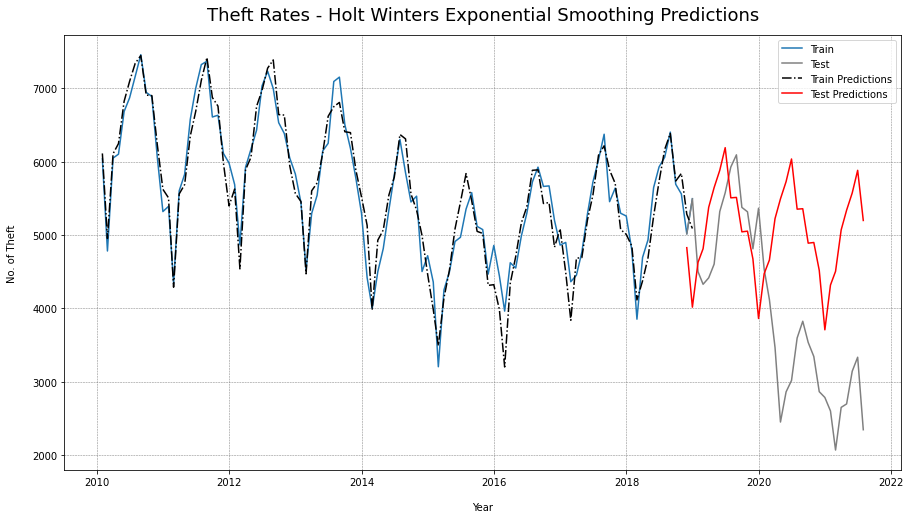

In [35]:
# Instantiate SES
hwes = ExponentialSmoothing(train_theft['primary_type'], seasonal_periods=12, trend='add', seasonal='add')

# Fit model
model = hwes.fit(optimized=True, use_brute=True)

# Determine len of predictions
start = len(train_theft)
end = len(train_theft) + len(test_theft) - 1

# Generate predictions based on train set.
hwes_preds_train = model.predict(start=0, end=len(train_theft) - 1)

# Generate predictions based on test set.
hwes_preds_test = model.predict(start=start, end=end)
                               
# Plot data.
plt.figure(figsize=(15,8))

# Plot training data.
plt.plot(train_theft.index, pd.DataFrame(train_theft['primary_type']), label='Train')

# Plot testing data.
plt.plot(test_theft.index, pd.DataFrame(test_theft['primary_type']), label='Test', color = 'grey')

# Plot predicted train values.
plt.plot(train_theft.index, hwes_preds_train, label='Train Predictions', color = 'black', linestyle='dashdot')

# Plot predicted test values.
plt.plot(test_theft.index, hwes_preds_test, label='Test Predictions', color = 'red')

plt.title(label = 'Theft Rates - Holt Winters Exponential Smoothing Predictions', fontsize=18, y =1.02)
plt.legend(loc='best')
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show();                             

In [36]:
print(model.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:             primary_type   No. Observations:                  108
Model:             ExponentialSmoothing   SSE                        7443515.710
Optimized:                         True   AIC                           1235.198
Trend:                         Additive   BIC                           1278.112
Seasonal:                      Additive   AICC                          1242.883
Seasonal Periods:                    12   Date:                 Thu, 09 Sep 2021
Box-Cox:                          False   Time:                         04:52:17
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2901174                alpha                 True
smoothing_trend          

In [37]:
# Evaluation
rms_hwes = rmse(test_theft['primary_type'], hwes_preds_test)
print (f'RMSE score: {rms_hwes}')

mae_hwes = mean_absolute_percentage_error(test_theft['primary_type'], hwes_preds_test)
print (f'MAE score: {mae_hwes}')

RMSE score: 1685.7299180626148
MAE score: 0.44666923637136496


### ARIMA (Auto Regressive Integrated Moving Average) 

- Technique forecasts the future value based on past values with parameter p (AR), d (I), q (MA)

In [38]:
# Finding the best values for p, d, q hyperparameters
arima = auto_arima(train_theft['primary_type'], 
                         start_p=0, start_q=0, 
                         d=1, 
                         seasonal=False, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1653.231, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1655.160, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1655.081, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1651.240, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1655.616, Time=0.23 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.438 seconds


In [39]:
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  108
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -824.620
Date:                Thu, 09 Sep 2021   AIC                           1651.240
Time:                        04:52:18   BIC                           1653.913
Sample:                             0   HQIC                          1652.324
                                - 108                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.894e+05   4.43e+04      6.530      0.000    2.03e+05    3.76e+05
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.92
Prob(Q):                              0.93   Pr

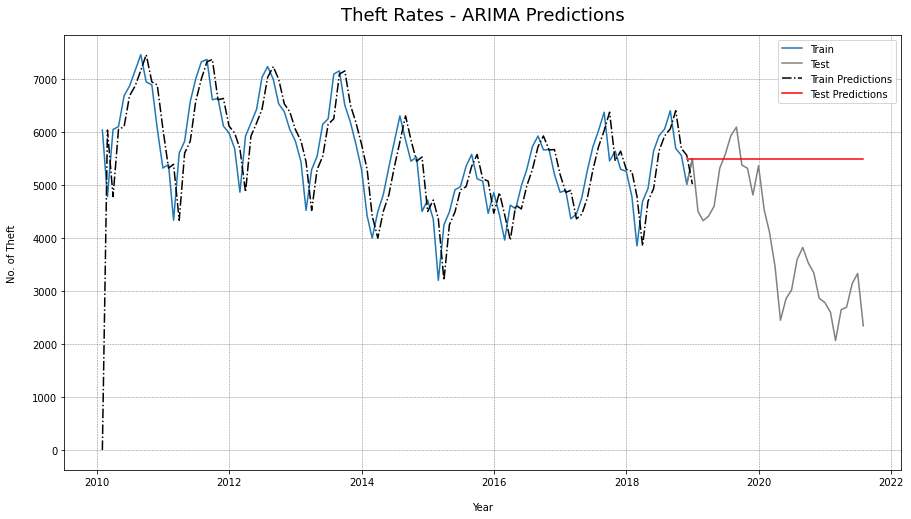

In [40]:
# Instantiate ARIMA model with best hyperparameters.
arima = ARIMA(train_theft['primary_type'], order=(0, 1, 0))

# Fit ARIMA model.
model = arima.fit()

# Determine len of predictions
start = len(train_theft)
end = len(train_theft) + len(test_theft) - 1

# Generate predictions based on train set.
arima_preds_train = model.predict(end=len(train_theft) - 1, typ='level')

# Generate predictions based on test set.
arima_preds_test = model.predict(start=start, end=end, typ='level')

# Plot data
plt.figure(figsize=(15,8))

# Plot training data.
plt.plot(train_theft.index, pd.DataFrame(train_theft['primary_type']), label='Train')

# Plot testing data.
plt.plot(test_theft.index, pd.DataFrame(test_theft['primary_type']), label='Test', color = 'grey')

# Plot predicted train values.
plt.plot(train_theft.index, arima_preds_train, label='Train Predictions', color = 'black', linestyle='dashdot')

# Plot predicted test values.
plt.plot(test_theft.index, arima_preds_test, label='Test Predictions', color = 'red')

plt.title(label = 'Theft Rates - ARIMA Predictions', fontsize=18, y =1.02)
plt.legend(loc='best')
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show();

In [41]:
# Evaluation
rms_arima = rmse(test_theft['primary_type'], arima_preds_test)
print (f'RMSE score: {rms_arima}')

mae_arima = mean_absolute_percentage_error(test_theft['primary_type'], arima_preds_test)
print (f'MAE score: {mae_arima}')

RMSE score: 1910.194595830329
MAE score: 0.5236356011995167


### SARIMA (Seasonal Autoregressive Integrated Moving Average)

- Similar to ARIMA, a technique forecasts the future value based on past values with a seasonal component

In [42]:
# Finding the best values for p, d, q hyperparameters
sarima = auto_arima(train_theft['primary_type'], 
                         start_p=0, start_q=0, start_P=0, start_Q=0,
                         d=1, m=12,
                         seasonal=True, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1653.231, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1559.336, Time=0.46 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1607.856, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1651.240, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1655.160, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=1.13 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1538.875, Time=0.73 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1607.556, Time=0.27 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=1552.911, Time=2.14 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=1541.079, Time=1.77 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=1594.103, Time=0.67 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=2.41 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1545.289, Time=0.50 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=1540.293, Time=0.91 sec
 ARIMA(1,1,1)(1,0,1)[12] inte

In [43]:
print(sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -764.232
Date:                            Thu, 09 Sep 2021   AIC                           1536.463
Time:                                    04:52:54   BIC                           1547.155
Sample:                                         0   HQIC                          1540.797
                                            - 108                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3053      0.091     -3.344      0.001      -0.484      -0.126
ar.S.L12       0.9809      0.012   

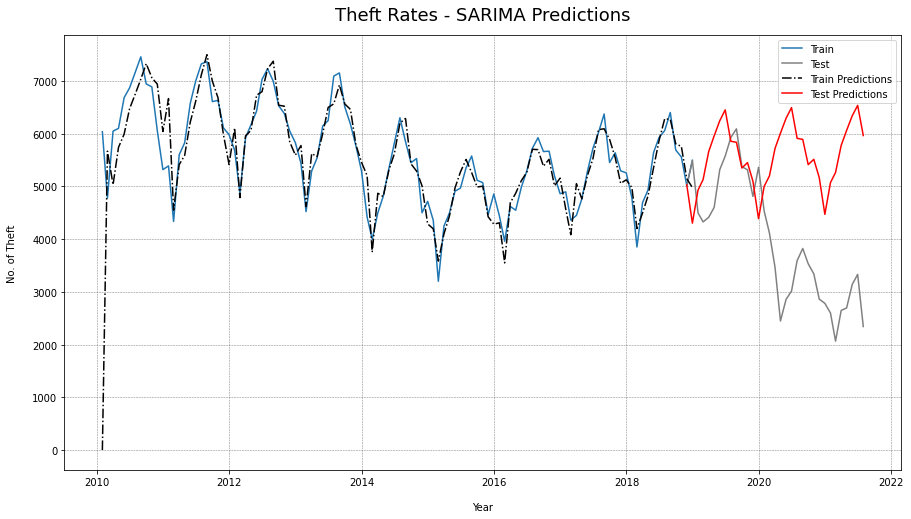

In [44]:
# Instantiate ARIMA model with best hyperparameters.
sarima = SARIMAX(train_theft['primary_type'], order=(0, 1, 1), seasonal_order=(1, 0, 1, 12))

# Fit ARIMA model.
model = sarima.fit()

# Determine len of predictions
start = len(train_theft)
end = len(train_theft) + len(test_theft) - 1

# Generate predictions based on train set.
sarima_preds_train = model.predict(end=len(train_theft) - 1, typ='level')

# Generate predictions based on test set.
sarima_preds_test = model.predict(start=start, end=end, typ='level')

# Plot data
plt.figure(figsize=(15,8))

# Plot training data.
plt.plot(train_theft.index, pd.DataFrame(train_theft['primary_type']), label='Train')

# Plot testing data.
plt.plot(test_theft.index, pd.DataFrame(test_theft['primary_type']), label='Test', color = 'grey')

# Plot predicted train values.
plt.plot(train_theft.index, sarima_preds_train, label='Train Predictions', color = 'black', linestyle='dashdot')

# Plot predicted test values.
plt.plot(test_theft.index, sarima_preds_test, label='Test Predictions', color = 'red')

plt.title(label = 'Theft Rates - SARIMA Predictions', fontsize=18, y =1.02)
plt.legend(loc='best')
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show();

In [45]:
# Evaluation
rms_sarima = rmse(test_theft['primary_type'], sarima_preds_test)
print (f'RMSE score: {rms_sarima}')

mae_sarima = mean_absolute_percentage_error(test_theft['primary_type'], sarima_preds_test)
print (f'MAE score: {mae_sarima}')

RMSE score: 2122.6576292165587
MAE score: 0.5698031199469424


### Facebook Prophet

In [46]:
# Prophet models requires data details to follow their format
prophet_train = train_theft.copy()
prophet_test = test_theft.copy()

# Date as part of features 
prophet_train = prophet_train.reset_index()
prophet_test = prophet_test.reset_index()

# Convert column names
prophet_train.columns = ['ds', 'y']
prophet_test.columns = ['ds', 'y']

In [47]:
# Instantiate prophet
m = Prophet()

# Fit model
m.fit(prophet_train)

# Create future periods (based on date in date - periods are based on test_data)
future = m.make_future_dataframe(periods=31, freq='M')

# Generate predictions based on data
forecast = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


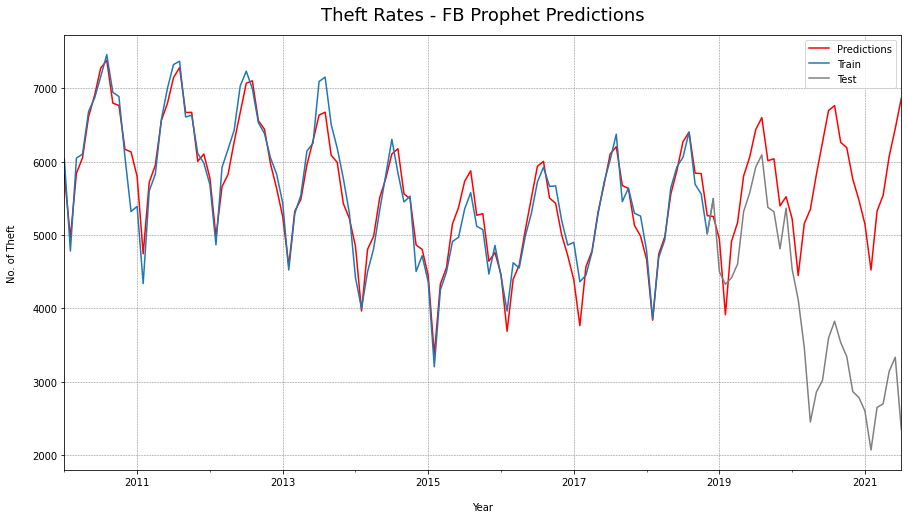

In [48]:
# Plot predicted values (train + test)
ax = forecast.plot(x='ds', y='yhat', label='Predictions', legend=True, color='red', figsize=(15,8))

# Plot training data.
prophet_train.plot(x='ds', y='y', label='Train', legend=True, ax=ax)

# Plot testing data.
prophet_test.plot(x='ds', y='y', label='Test', legend=True, color='grey', ax=ax)

plt.title(label = 'Theft Rates - FB Prophet Predictions', fontsize=18, y =1.02)
plt.legend(loc='best')
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show();

In [49]:
prophet_preds = forecast.iloc[-33:]['yhat']

In [50]:
# Evaluation
rms_prophet = rmse(prophet_test['y'], prophet_preds)
print (f'RMSE score: {rms_prophet}')

mae_prophet = mean_absolute_percentage_error(prophet_test['y'], prophet_preds)
print (f'MAE score: {mae_prophet}')

RMSE score: 2136.79592887553
MAE score: 0.562864397340499


### Recurrent Neural Network

In [51]:
theft_rates.index.max()

Timestamp('2021-07-31 00:00:00', freq='M')

In [52]:
train_rnn = train_theft[['primary_type']]
test_rnn = test_theft[['primary_type']]

In [53]:
from sklearn.preprocessing import MinMaxScaler

# Instantiate MinMaxScaler
scaler = MinMaxScaler()

# Fit scaler
scaler.fit(train_rnn)

MinMaxScaler()

In [54]:
# Scaled data
Z_train = scaler.transform(train_rnn)
Z_test = scaler.transform(test_rnn)

In [55]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [56]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(Z_train, Z_train, length=n_input, batch_size=1)

In [57]:
# What does the first batch look like?
X,y = generator[0]

In [58]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.66619685 0.37091849 0.66878083 0.68123091 0.81794691 0.86140475
 0.92999765 1.         0.87925769 0.86610289 0.67183463 0.49729857]
Predict this y: 
 [[0.51397698]]


Model


In [59]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [60]:
n_input = 12
n_features = 1
train_generator = TimeseriesGenerator(Z_train, Z_train, length=n_input, batch_size=1)

In [61]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='bce', metrics=['acc'])
es = EarlyStopping(patience = 5)

In [62]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 4)                 404       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 41,209
Trainable params: 41,209
Non-trainable params: 0
_________________________________________________________________
None


In [63]:
# Fit model
model.fit_generator(train_generator, epochs=25,  callbacks = [es])

Epoch 1/25
96/96 [==============================] - 2s 7ms/step - loss: 0.6933 - acc: 0.0104


Epoch 2/25
96/96 [==============================] - 1s 6ms/step - loss: 0.6924 - acc: 0.0000e+00


Epoch 3/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6920 - acc: 0.0000e+00


Epoch 4/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6916 - acc: 0.0000e+00


Epoch 5/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6913 - acc: 0.0000e+00


Epoch 6/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6912 - acc: 0.0000e+00


Epoch 7/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6909 - acc: 0.0000e+00


Epoch 8/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6908 - acc: 0.0000e+00


Epoch 9/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6907 - acc: 0.0000e+00


Epoch 10/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6907 - acc: 0.0000e+00


Epoch 11/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6905 - acc: 0.0000e+00


Epoch 12/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6906 - acc: 0.0000e+00


Epoch 13/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6905 - acc: 0.0000e+00


Epoch 14/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6904 - acc: 0.0000e+00


Epoch 15/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6904 - acc: 0.0000e+00


Epoch 16/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6903 - acc: 0.0000e+00


Epoch 17/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6904 - acc: 0.0000e+00


Epoch 18/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6903 - acc: 0.0000e+00


Epoch 19/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6903 - acc: 0.0000e+00


Epoch 20/25
96/96 [==============================] - 1s 6ms/step - loss: 0.6903 - acc: 0.0000e+00


Epoch 21/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6903 - acc: 0.0000e+00


Epoch 22/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6903 - acc: 0.0000e+00


Epoch 23/25
96/96 [==============================] - 1s 6ms/step - loss: 0.6903 - acc: 0.0000e+00


Epoch 24/25
96/96 [==============================] - 1s 6ms/step - loss: 0.6903 - acc: 0.0000e+00


Epoch 25/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6903 - acc: 0.0000e+00


In [64]:
model.history.history.keys

<function dict.keys>

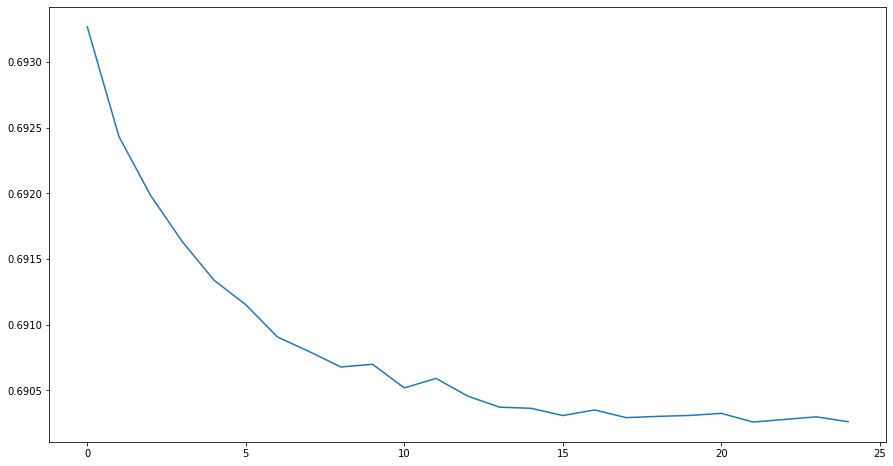

In [65]:
# Understand loss
myloss = model.history.history['loss']

plt.plot(range(len(myloss)), myloss)

In [66]:
# 12 history steps ---> step 13
# last 12 points train ---> pt 1 of test data

In [67]:
first_eval_batch = Z_train[-12:]

In [68]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

Forecast

In [69]:
# Holding predictions
test_predictions = []

#last n_input points from the training set
first_eval_batch = Z_train[-n_input:]

# Reshape this to the format RNN wants (same as TimeseriesGenerator)
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [70]:
# How far into the future will be forecasted
# len(test)
for i in range(len(test_theft)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [71]:
true_predictions = scaler.inverse_transform(test_predictions)

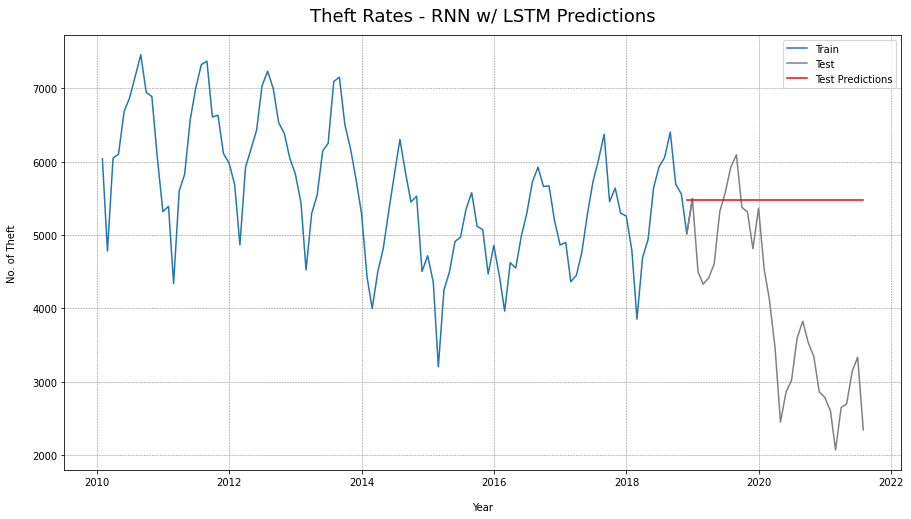

In [72]:
# Plot data
plt.figure(figsize=(15,8))

# Plot training data.
plt.plot(train_theft.index, pd.DataFrame(train_theft['primary_type']), label='Train')

# Plot testing data.
plt.plot(test_theft.index, pd.DataFrame(test_theft['primary_type']), label='Test', color = 'grey')

# Plot predicted test values.
plt.plot(test_theft.index, true_predictions, label='Test Predictions', color = 'red')

plt.title(label = 'Theft Rates - RNN w/ LSTM Predictions', fontsize=18, y =1.02)
plt.legend(loc='best')
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show();

In [73]:
test_theft['rnn_predictions'] = true_predictions

In [74]:
# Evaluation
rms_rnn = rmse(test_theft['primary_type'], test_theft['rnn_predictions'])
print (f'RMSE score: {rms_rnn}')

mae_rnn = mean_absolute_percentage_error(test_theft['primary_type'], test_theft['rnn_predictions'])
print (f'MAE score: {mae_rnn}')

RMSE score: 1900.688114314636
MAE score: 0.5208370320728544


### SARIMAX (Seasonal Autoregressive Integrated Moving Average with Exogenous Variable)
Further look explore the model with exogenous variable to see the impact of external factors
- Requirement: Exog features are available values from past, present and into the future

In [75]:
# Loading original data
theft_rates_fc = theft_ori.copy()

# Filter data with exog variables
theft_rates_fc = theft_rates_fc[['primary_type', 'holiday', 'isweekend', 'unemployment_rate', 'avg_temp']]

In [76]:
theft_rates_fc.tail()

primary_type  holiday  isweekend  unemployment_rate  avg_temp
date                                                                     
2022-03-31             0        0         12               10.7      51.4
2022-04-30             0        0         14               10.7      51.4
2022-05-31             0        1         13               10.7      51.4
2022-06-30             0        0         12               10.7      51.4
2022-07-31             0        1         15               10.7      51.4

In [77]:
# Train Test Split
train_theft = theft_rates_fc[:'2019-01-01']
test_theft = theft_rates_fc['2018-11-30':'2021-07-31']
fc_theft = theft_rates_fc['2021-06-30':]

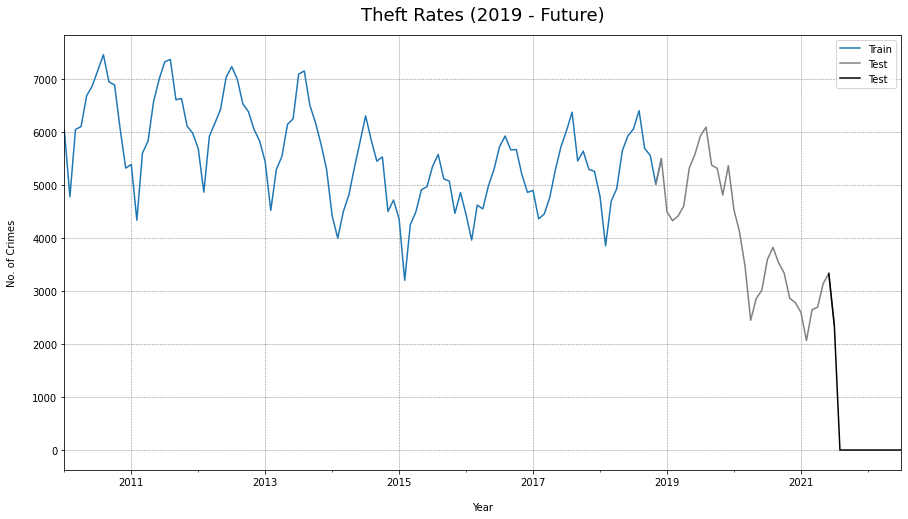

In [78]:
# Check the split
train_theft['primary_type'].plot(figsize=(15, 8), label='Train')
test_theft['primary_type'].plot(label='Test', color='grey')
fc_theft['primary_type'].plot(label='Test', color='black')

plt.title('Theft Rates (2019 - Future)', fontsize=18, y=1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Crimes', labelpad=15)
plt.legend(loc='best')
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show();

In [79]:
# Assign exogenous variable
train_exog =  train_theft[['holiday', 'unemployment_rate', 'avg_temp']]
test_exog =  test_theft[['holiday', 'unemployment_rate', 'avg_temp']]
fc_exog =  fc_theft[['holiday', 'unemployment_rate', 'avg_temp']]

In [80]:
# Finding the best values for p, d, q hyperparameters
sarimax = auto_arima(train_theft['primary_type'], exog=train_exog,
                         start_p=0, start_q=0, start_P=0, start_Q=0,
                         d=1, m=12,
                         seasonal=True, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1653.231, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1559.336, Time=0.50 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1607.856, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1651.240, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1655.160, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=1.07 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1538.875, Time=0.70 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1607.556, Time=0.28 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=1552.911, Time=2.16 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=1541.079, Time=1.75 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=1594.103, Time=0.63 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=2.32 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1545.289, Time=0.49 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=1540.293, Time=0.93 sec
 ARIMA(1,1,1)(1,0,1)[12] inte

In [81]:
print(sarimax.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -764.232
Date:                            Thu, 09 Sep 2021   AIC                           1536.463
Time:                                    04:54:06   BIC                           1547.155
Sample:                                         0   HQIC                          1540.797
                                            - 108                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3053      0.091     -3.344      0.001      -0.484      -0.126
ar.S.L12       0.9809      0.012   

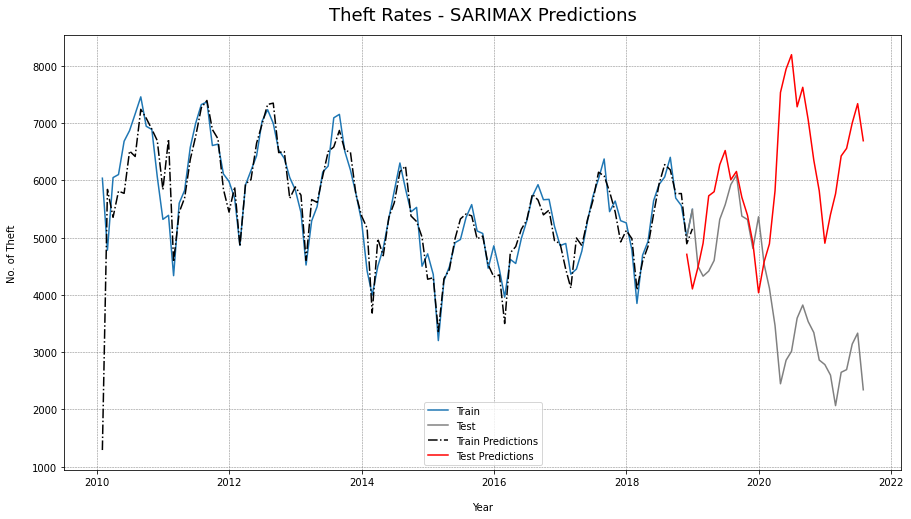

In [82]:
# Instantiate ARIMA model with best hyperparameters.
sarimax = SARIMAX(train_theft['primary_type'], exog=train_exog, order=(0, 1, 1), seasonal_order=(1, 0, 1, 12))

# Fit ARIMA model.
model = sarimax.fit()

# Determine len of predictions
start = len(train_theft)
end = len(train_theft) + len(test_theft) - 1

# Generate predictions based on train set.
sarimax_preds_train = model.predict(end=len(train_theft) - 1, exog=train_exog, typ='level')

# Generate predictions based on test set.
sarimax_preds_test = model.predict(start=start, end=end, exog=test_exog, typ='level')

# Plot data
plt.figure(figsize=(15,8))

# Plot training data.
plt.plot(train_theft.index, pd.DataFrame(train_theft['primary_type']), label='Train')

# Plot testing data.
plt.plot(test_theft.index, pd.DataFrame(test_theft['primary_type']), label='Test', color = 'grey')

# Plot predicted train values.
plt.plot(train_theft.index, sarimax_preds_train, label='Train Predictions', color = 'black', linestyle='dashdot')

# Plot predicted test values.
plt.plot(test_theft.index, sarimax_preds_test, label='Test Predictions', color = 'red')

plt.title(label = 'Theft Rates - SARIMAX Predictions', fontsize=18, y =1.02)
plt.legend(loc='best')
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show();

In [83]:
# Evaluation
rms_sarimax = rmse(test_theft['primary_type'], sarimax_preds_test)
print (f'RMSE score: {rms_sarimax}')

mae_sarimax = mean_absolute_percentage_error(test_theft['primary_type'], sarimax_preds_test)
print (f'MAE score: {mae_sarimax}')

RMSE score: 2792.7030687886886
MAE score: 0.72451440784756


### ***Based on time-series model:***

|Model|RMSE|MAE|
|---|---|---|
|Holt Winters ES|1685.7299180626148|0.44666923637136496|
|SARIMA|2122.6576292165587|0.5698031199469424|
|Prophet|2136.79592887553|0.562864397340499|
|SARIMAX|2792.7030687886886|0.72451440784756|

## **In-Depth Understanding of Theft Rates**

Theft rates decreases exponentially from last few months of December 2019 to early January 2020. This may be possible due to the rise in the global pandemic, COVID-19 where countries implement lockdowns and rules to curb the rise of the disease

With a focus dataset, we will be performing the same models as per previous data.

Reference: 
- https://www.wired.com/story/crime-rates-dropped-in-2020-just-as-they-did-in-1918/

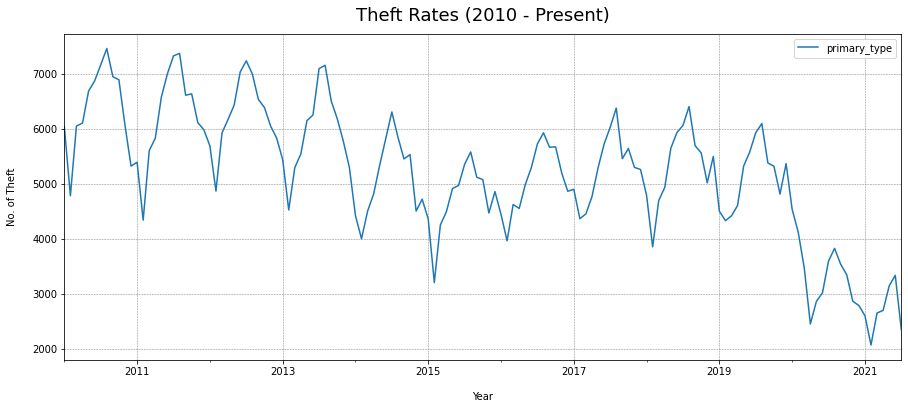

In [84]:
# Theft rates based on from 2010 - present
theft_rates = theft[['primary_type']]

# Plot crime rates from dataset
theft_rates.plot(figsize=(15,6))
plt.title('Theft Rates (2010 - Present)', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

In [85]:
theft_rates_ind = theft_rates['2018-12-31':]

In [86]:
theft_rates_ind.shape

(32, 1)

To get a fairly good forecasting from the model, data should have as much point as possible. In our case of monthly theft rates, we only have 32 data points which is fairly low hence we look at daily records instead.

In [87]:
theft_d = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/capstone/assets/clean_data/2010_2021_theft_daily.csv', index_col='date', parse_dates=True)

### Data Summary

In [88]:
theft_d.head()

primary_type  afternoon  evening  ...  45to54  65to74  75andmore
date                                          ...                           
2010-01-01           332         69       23  ...  342384  151070     129473
2010-01-02           182         77       56  ...  342384  151070     129473
2010-01-03           146         58       29  ...  342384  151070     129473
2010-01-04           195         77       47  ...  342384  151070     129473
2010-01-05           206         81       44  ...  342384  151070     129473

[5 rows x 205 columns]

In [89]:
theft_d.shape

(4595, 205)

In [90]:
# Remove forecast dates (Require only when using SARIMAX)
theft_daily = theft_d[:-374]

theft_daily.index.freq = 'D'

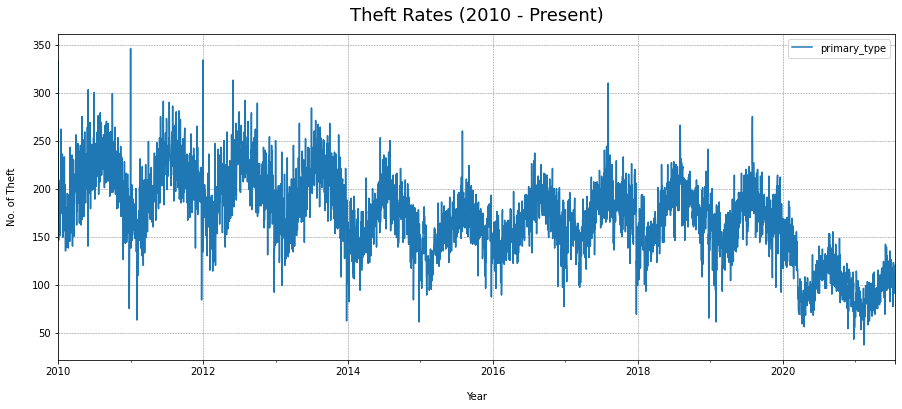

In [91]:
# Theft rates based on from 2010 - present
theft_rates_d = theft_daily[['primary_type']]

# Plot crime rates from dataset
theft_rates_d.plot(figsize=(15,6))
plt.title('Theft Rates (2010 - Present)', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

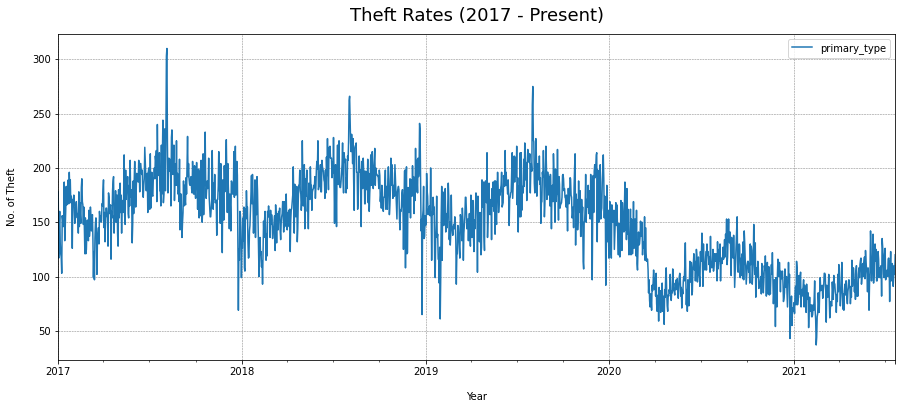

In [92]:
# Focus on late 2019 onwards
theft_rates_d = theft_rates_d['2017-01-01':]

# Plot crime rates from dataset
theft_rates_d.plot(figsize=(15,6))
plt.title('Theft Rates (2017 - Present)', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

In [93]:
# Resample theft rates to weekly count
theft_rates_w = theft_rates_d.resample('W').sum()

# Change frequency
theft_rates_w.index.freq = 'W'

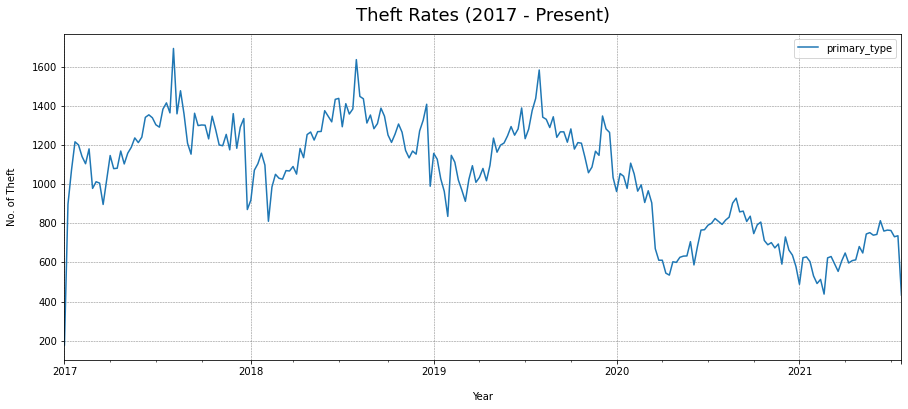

In [94]:
# Plot crime rates from dataset
theft_rates_w.plot(figsize=(15,6))
plt.title('Theft Rates (2017 - Present)', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

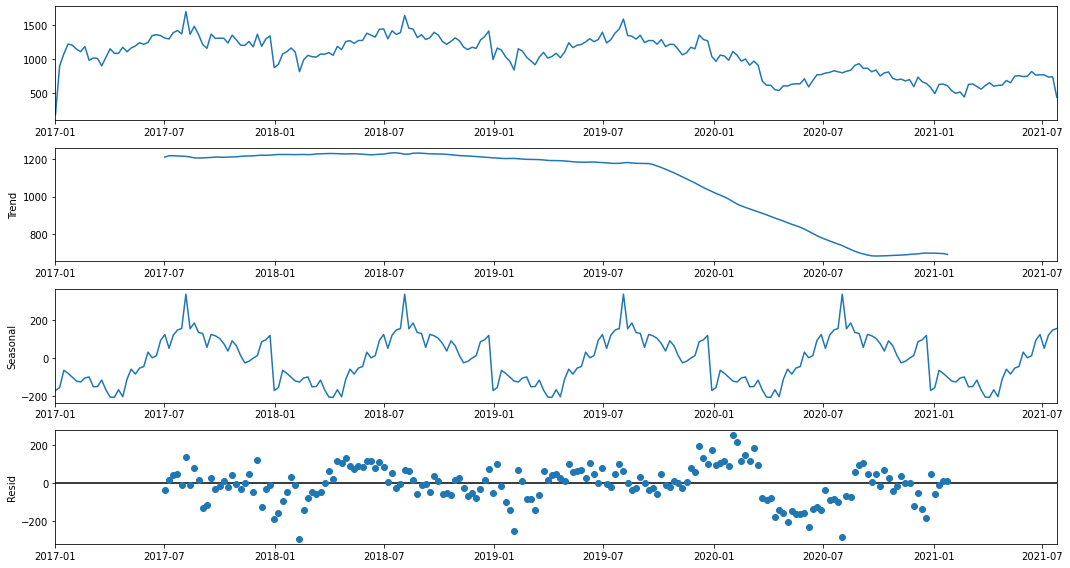

In [95]:
# ETS decomposition
rcParams['figure.figsize'] = 15,8
sm.tsa.seasonal_decompose(theft_rates_w).plot();

In [96]:
# Test for stationarity
adf_test(theft_rates_w)

Augmented Dickey-Fuller Test: 
ADF test statistic       -1.013298
p-value                   0.748383
# lags used               4.000000
# observations          234.000000
critical value (1%)      -3.458608
critical value (5%)      -2.873972
critical value (10%)     -2.573396

Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


### Differencing Data

In [97]:
theft_diff_w = theft_rates_w.copy()

In [98]:
# Assign both degree of diff() to columns 
theft_diff_w['first_diff_crime'] = theft_diff_w['primary_type'].diff()
theft_diff_w['second_diff_crime'] = theft_diff_w['primary_type'].diff().diff()

First Difference

In [99]:
# Stationary Test for first diff()
adf_test(theft_diff_w['first_diff_crime'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.060976e+01
p-value                 5.875238e-19
# lags used             3.000000e+00
# observations          2.340000e+02
critical value (1%)    -3.458608e+00
critical value (5%)    -2.873972e+00
critical value (10%)   -2.573396e+00

Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


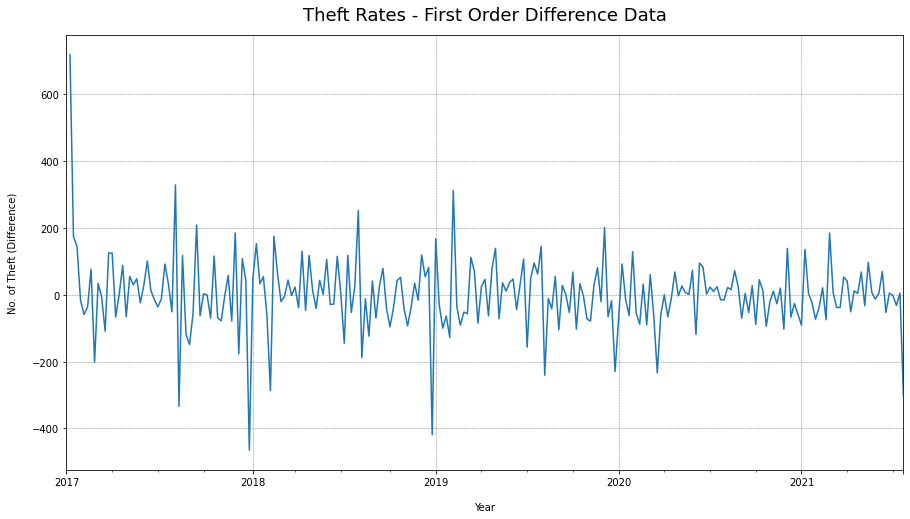

In [100]:
# Plot first diff()
theft_diff_w['first_diff_crime'].plot()
plt.title('Theft Rates - First Order Difference Data', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft (Difference)', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

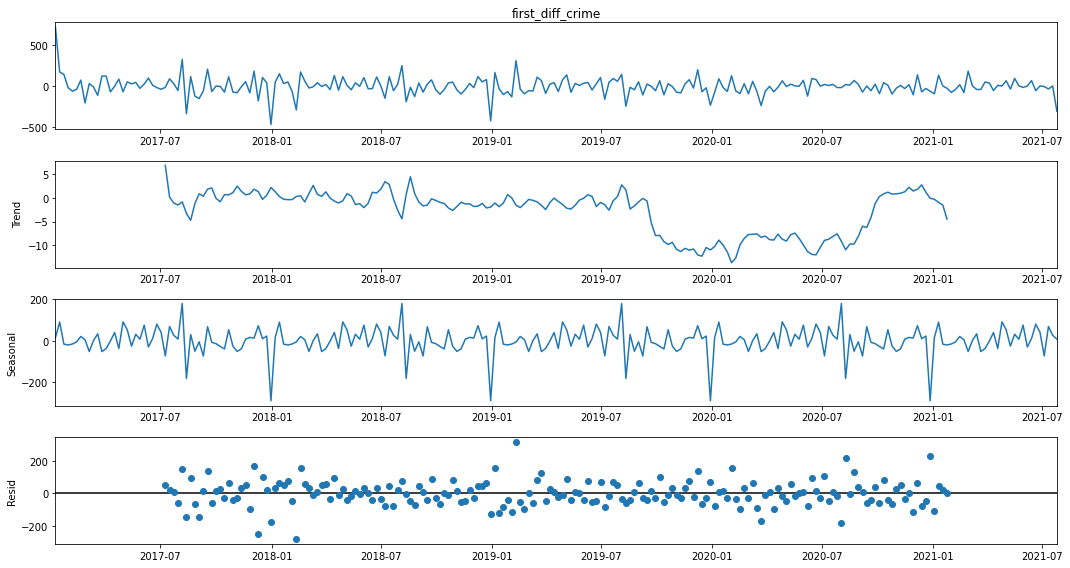

In [101]:
# Drop null values
first_diff = theft_diff_w['first_diff_crime']
first_diff.dropna(inplace=True)

# ETS decomposition - First Difference
rcParams['figure.figsize'] = 15,8
sm.tsa.seasonal_decompose(first_diff).plot();

Second Difference

In [102]:
# Stationary Test for first diff()
adf_test(theft_diff_w['second_diff_crime'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -9.557673e+00
p-value                 2.473747e-16
# lags used             9.000000e+00
# observations          2.270000e+02
critical value (1%)    -3.459490e+00
critical value (5%)    -2.874358e+00
critical value (10%)   -2.573602e+00

Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


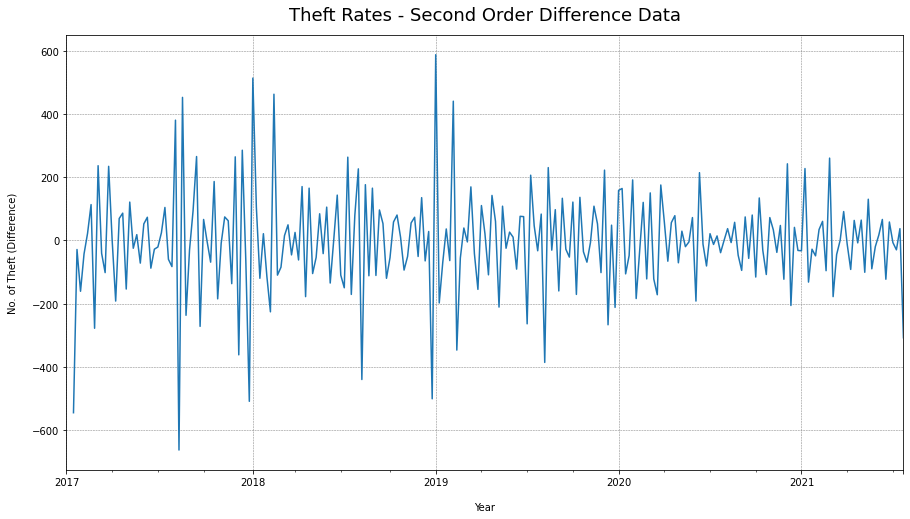

In [103]:
# Plot first diff()
theft_diff_w['second_diff_crime'].plot()
plt.title('Theft Rates - Second Order Difference Data', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft (Difference)', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

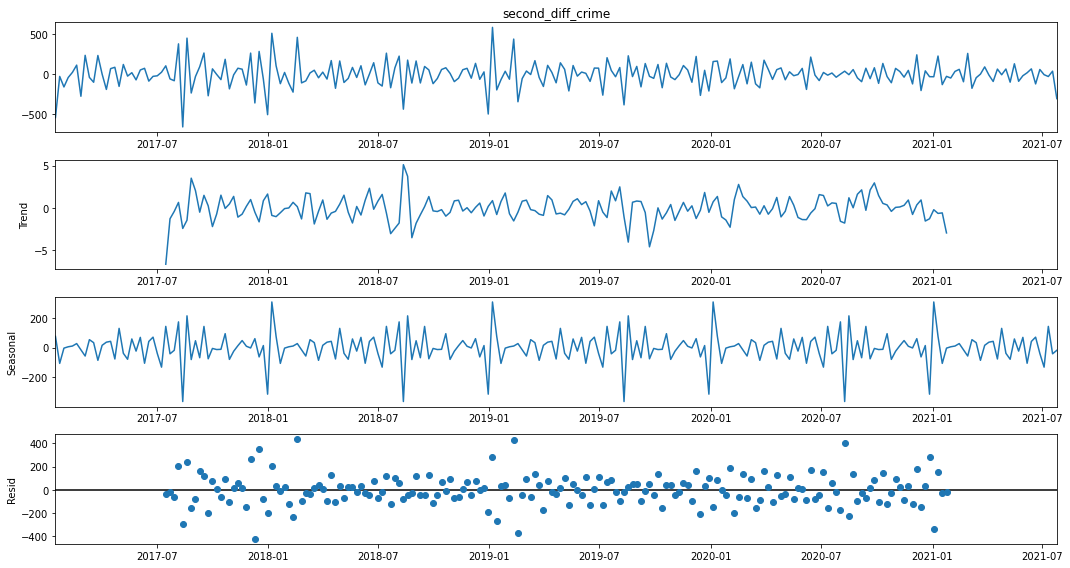

In [104]:
# Drop null values
second_diff = theft_diff_w['second_diff_crime']
second_diff.dropna(inplace=True)

# ETS decomposition - First Difference
rcParams['figure.figsize'] = 15,8
sm.tsa.seasonal_decompose(second_diff).plot();

### Normality Test

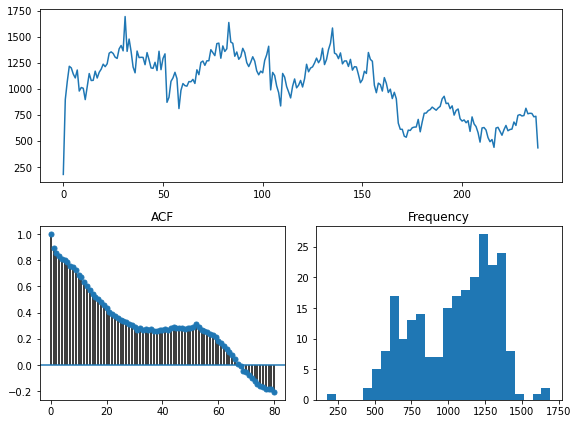

In [105]:
# Understanding the frequency of Theft
tsdisplay(theft_rates_w, lag_max=80)

In [106]:
# Normality Test on Theft (Original)
normaltest(theft_rates_w)

stat=0.957, p=0.000

Probably not Gaussian


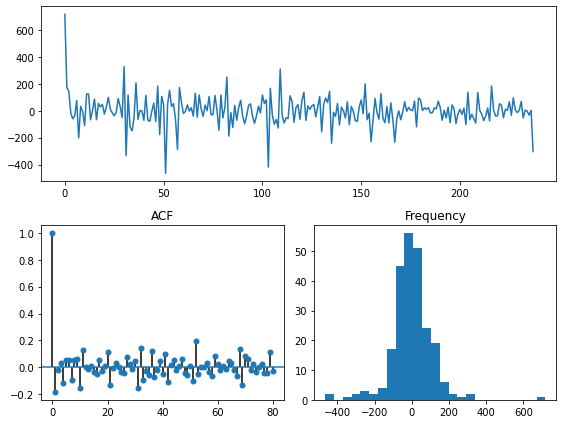

In [107]:
# Understanding the frequency of Theft with First Diff
tsdisplay(first_diff, lag_max=80)

In [108]:
# Normality Test on Theft (First Difference)
normaltest(first_diff)

stat=0.894, p=0.000

Probably not Gaussian


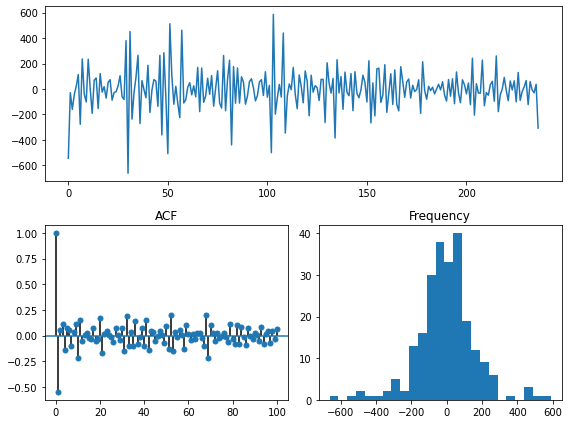

In [109]:
# Understanding the frequency of Theft with First Diff
tsdisplay(second_diff, lag_max=100)

In [110]:
# Normality Test on Theft (First Difference)
normaltest(second_diff)

stat=0.957, p=0.000

Probably not Gaussian


### **Time-Series Modelling**

#### Train Test Split

In [111]:
# Change dtype to int32 (For coputation performance)
theft_rates_w['primary_type'] = theft_rates_w['primary_type'].astype('int32')

In [112]:
# Train Test Split
train_theft_w = theft_rates_w[:'2020-12-31']
test_theft_w = theft_rates_w['2020-12-27':]

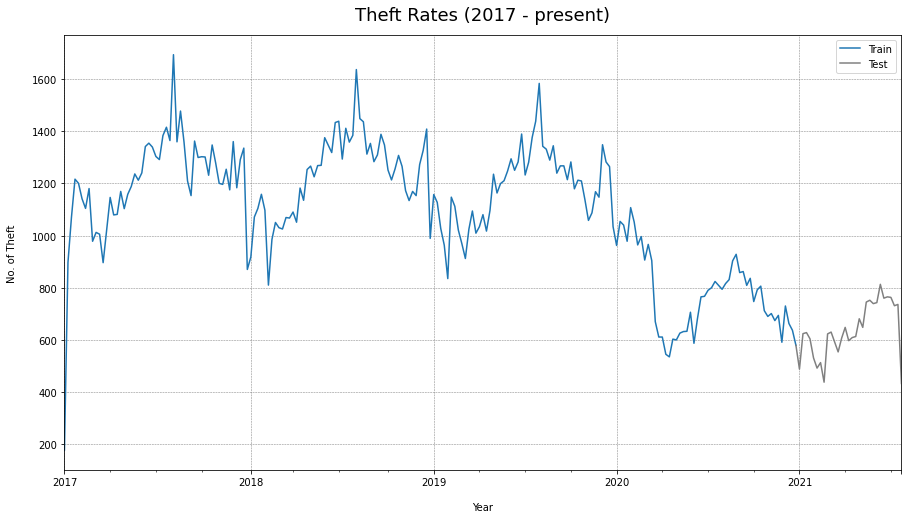

In [113]:
# Check the split
train_theft_w['primary_type'].plot(figsize=(15, 8), label='Train')
test_theft_w['primary_type'].plot(label='Test', color='grey')

plt.title('Theft Rates (2017 - present)', fontsize=18, y=1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.legend(loc='best')
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show();

#### ACF & PACF

<Figure size 1080x576 with 0 Axes>

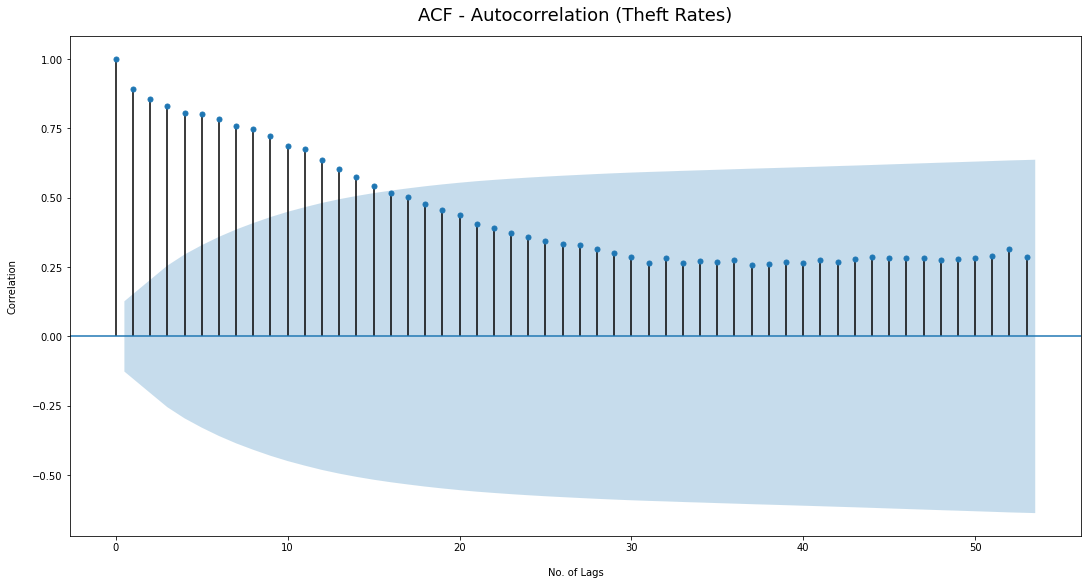

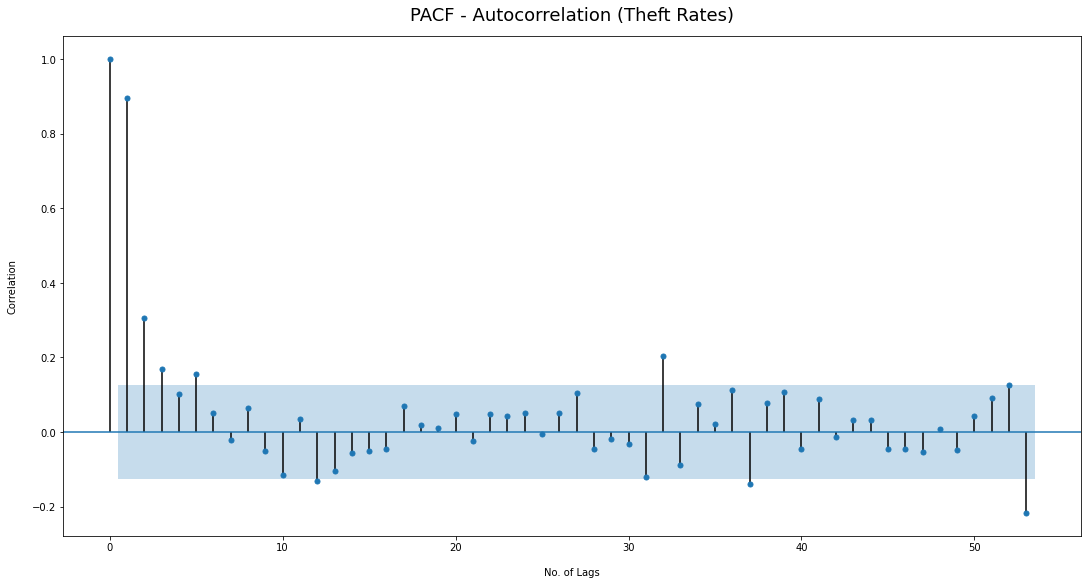

In [114]:
# Plot ACF & PACF for Theft
plt.figure(figsize=(15,8))
plot_acf(theft_rates_w['primary_type'], lags=53)

plt.title('ACF - Autocorrelation (Theft Rates)', fontsize=18, y=1.02)
plt.xlabel('No. of Lags', labelpad=15)
plt.ylabel('Correlation', labelpad=15)
plt.tight_layout(pad=0.3)

plot_pacf(theft_rates_w['primary_type'], lags=53)

plt.title('PACF - Autocorrelation (Theft Rates)', fontsize=18, y=1.02)
plt.xlabel('No. of Lags', labelpad=15)
plt.ylabel('Correlation', labelpad=15)
plt.tight_layout(pad=0.3);

<Figure size 1080x576 with 0 Axes>

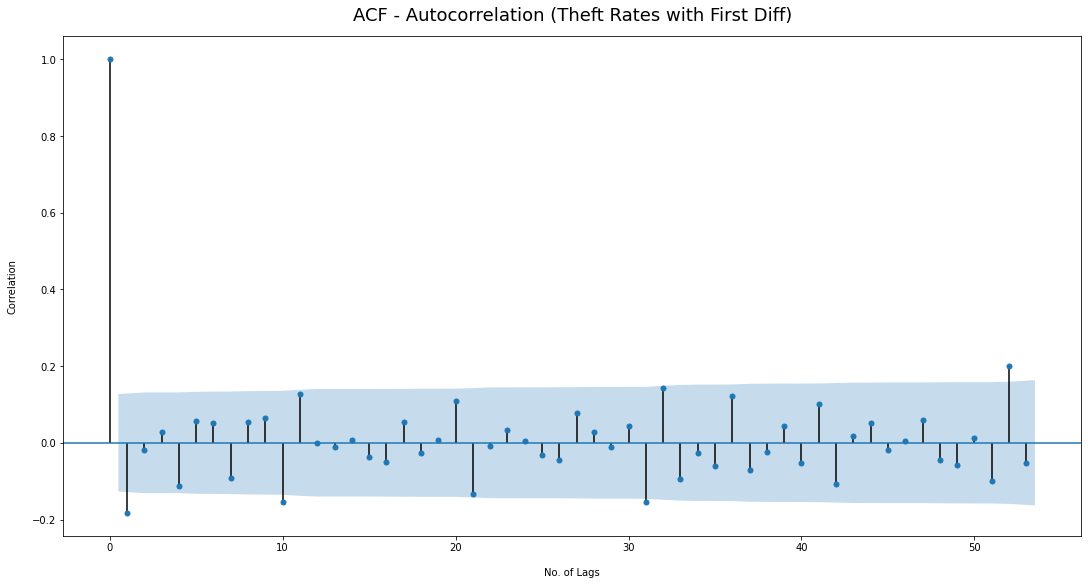

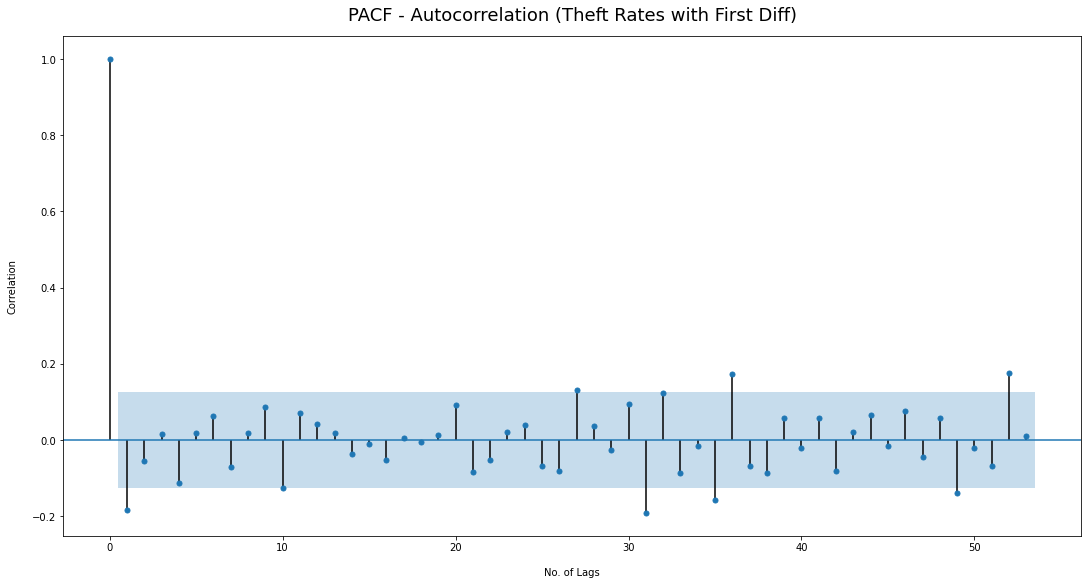

In [115]:
# Plot ACF & PACF Theft with First Diff
first_diff = pd.DataFrame(first_diff)

plt.figure(figsize=(15,8))
plot_acf(first_diff['first_diff_crime'], lags=53)

plt.title('ACF - Autocorrelation (Theft Rates with First Diff)', fontsize=18, y=1.02)
plt.xlabel('No. of Lags', labelpad=15)
plt.ylabel('Correlation', labelpad=15)
plt.tight_layout(pad=0.3)

plot_pacf(first_diff['first_diff_crime'], lags=53)

plt.title('PACF - Autocorrelation (Theft Rates with First Diff)', fontsize=18, y=1.02)
plt.xlabel('No. of Lags', labelpad=15) 
plt.ylabel('Correlation', labelpad=15)
plt.tight_layout(pad=0.3);

#### Simple Exponential Smoothing

- Technique forecasts the next value using a weighted average of all previous values where the weights decay exponentially from the most recent to the oldest historical value.

In [116]:
# Ref: https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/

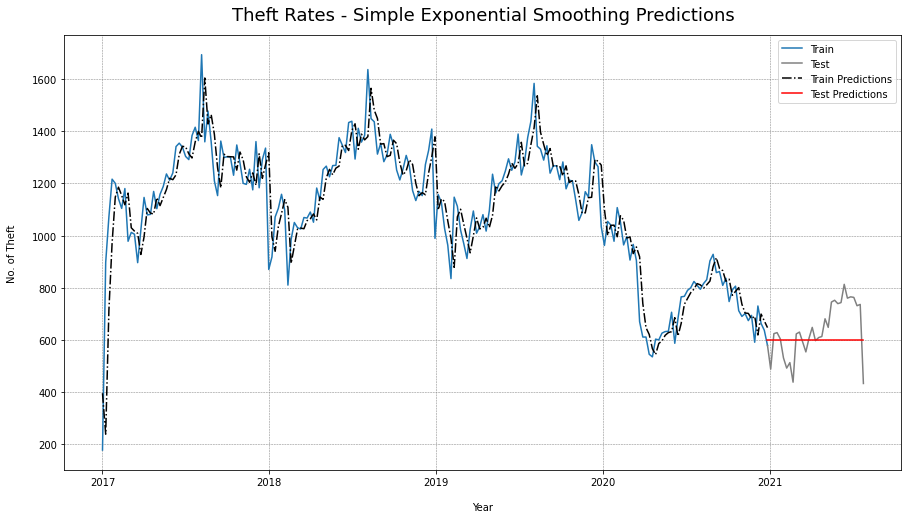

In [117]:
# Instantiate SES
ses2 = SimpleExpSmoothing(train_theft_w['primary_type'])

# Fit model
model2 = ses2.fit()

# Determine len of predictions
start = len(train_theft_w)
end = len(train_theft_w) + len(test_theft_w) - 1

# Generate predictions based on train set.
ses_preds_train2 = model2.predict(start=0, end=len(train_theft_w) - 1)

# Generate predictions based on test set.
ses_preds_test2 = model2.predict(start=start, end=end)
                               
# Plot data.
plt.figure(figsize=(15,8))

# Plot training data.
plt.plot(train_theft_w.index, pd.DataFrame(train_theft_w['primary_type']), label='Train')

# Plot testing data.
plt.plot(test_theft_w.index, pd.DataFrame(test_theft_w['primary_type']), label='Test', color = 'grey')

# Plot predicted train values.
plt.plot(train_theft_w.index, ses_preds_train2, label='Train Predictions', color = 'black', linestyle='dashdot')

# Plot predicted test values.
plt.plot(test_theft_w.index, ses_preds_test2, label='Test Predictions', color = 'red')

plt.title(label = 'Theft Rates - Simple Exponential Smoothing Predictions', fontsize=18, y =1.02)
plt.legend(loc='best')
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show();                             

In [118]:
print(model2.summary())

                       SimpleExpSmoothing Model Results                       
Dep. Variable:           primary_type   No. Observations:                  209
Model:             SimpleExpSmoothing   SSE                        2610614.074
Optimized:                       True   AIC                           1975.447
Trend:                           None   BIC                           1982.132
Seasonal:                        None   AICC                          1975.643
Seasonal Periods:                None   Date:                 Thu, 09 Sep 2021
Box-Cox:                        False   Time:                         04:54:19
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.7203231                alpha                 True
initial_level              395.65737                

In [119]:
# Evaluation
rms_ses_w = rmse(test_theft_w['primary_type'], ses_preds_test2)
print (f'RMSE score: {rms_ses_w}')

mae_ses_w = mean_absolute_percentage_error(test_theft_w['primary_type'], ses_preds_test2)
print (f'MAE score: {mae_ses_w}')

RMSE score: 107.19900437879176
MAE score: 0.13536081809395337


#### Holt Winters Exponential Smoothing

- Fixes one of the two shortcomings of the simple ES technique. Holt Winters ES can be used to forecast time series data that has a trend and seasonality


In [120]:
# Ref: https://towardsdatascience.com/holt-winters-exponential-smoothing-d703072c0572

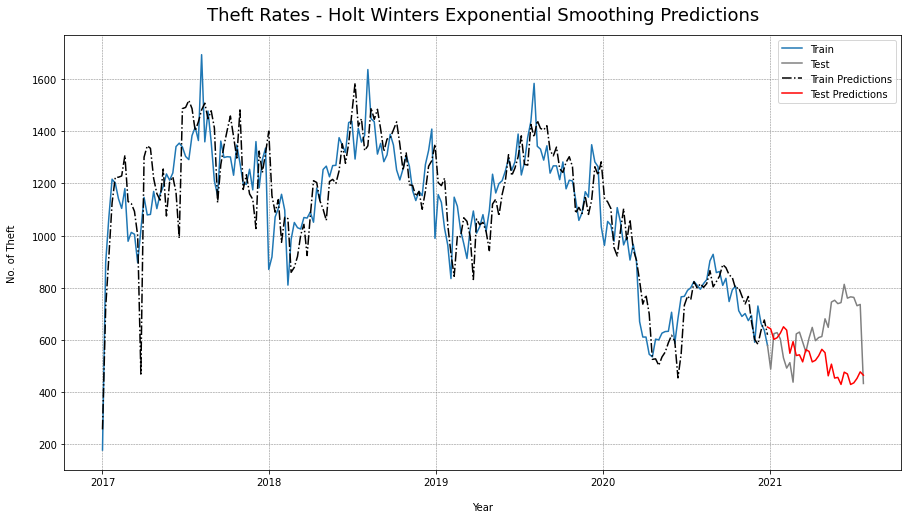

In [121]:
# Instantiate SES
hwes2 = ExponentialSmoothing(train_theft_w['primary_type'], seasonal_periods=12, trend='add', seasonal='add')

# Fit model
model2 = hwes2.fit(optimized=True, use_brute=True)

# Determine len of predictions
start = len(train_theft_w)
end = len(train_theft_w) + len(test_theft_w) - 1

# Generate predictions based on train set.
hwes_preds_train2 = model2.predict(start=0, end=len(train_theft_w) - 1)

# Generate predictions based on test set.
hwes_preds_test2 = model2.predict(start=start, end=end)
                               
# Plot data.
plt.figure(figsize=(15,8))

# Plot training data.
plt.plot(train_theft_w.index, pd.DataFrame(train_theft_w['primary_type']), label='Train')

# Plot testing data.
plt.plot(test_theft_w.index, pd.DataFrame(test_theft_w['primary_type']), label='Test', color = 'grey')

# Plot predicted train values.
plt.plot(train_theft_w.index, hwes_preds_train2, label='Train Predictions', color = 'black', linestyle='dashdot')

# Plot predicted test values.
plt.plot(test_theft_w.index, hwes_preds_test2, label='Test Predictions', color = 'red')

plt.title(label = 'Theft Rates - Holt Winters Exponential Smoothing Predictions', fontsize=18, y =1.02)
plt.legend(loc='best')
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show();                             

In [122]:
print(model2.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:             primary_type   No. Observations:                  209
Model:             ExponentialSmoothing   SSE                        3462548.822
Optimized:                         True   AIC                           2062.473
Trend:                         Additive   BIC                           2115.950
Seasonal:                      Additive   AICC                          2066.073
Seasonal Periods:                    12   Date:                 Thu, 09 Sep 2021
Box-Cox:                          False   Time:                         04:54:19
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4268292                alpha                 True
smoothing_trend          

In [123]:
# Evaluation
rms_hwes_w = rmse(test_theft_w['primary_type'], hwes_preds_test2)
print (f'RMSE score: {rms_hwes_w}')

mae_hwes_w = mean_absolute_percentage_error(test_theft_w['primary_type'], hwes_preds_test2)
print (f'MAE score: {mae_hwes_w}')

RMSE score: 186.8477925669537
MAE score: 0.2250412460055823


#### ARIMA (Auto Regressive Integrated Moving Average) 

- Technique forecasts the future value based on past values with parameter p (AR), d (I), q (MA)

In [124]:
# Finding the best values for p, d, q hyperparameters
arima = auto_arima(train_theft_w['primary_type'], 
                         start_p=0, start_q=0, 
                         d=1, 
                         seasonal=False, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2567.948, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2560.984, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2559.460, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2566.007, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2560.541, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2560.802, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2557.491, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2558.554, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2558.821, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2559.029, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2560.607, Time=0.23 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.832 seconds


In [125]:
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  209
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1276.746
Date:                Thu, 09 Sep 2021   AIC                           2557.491
Time:                        04:54:21   BIC                           2564.167
Sample:                             0   HQIC                          2560.190
                                - 209                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2751      0.042     -6.568      0.000      -0.357      -0.193
sigma2      1.255e+04    562.405     22.318      0.000    1.14e+04    1.37e+04
Ljung-Box (L1) (Q):                   1.00   Jarque-

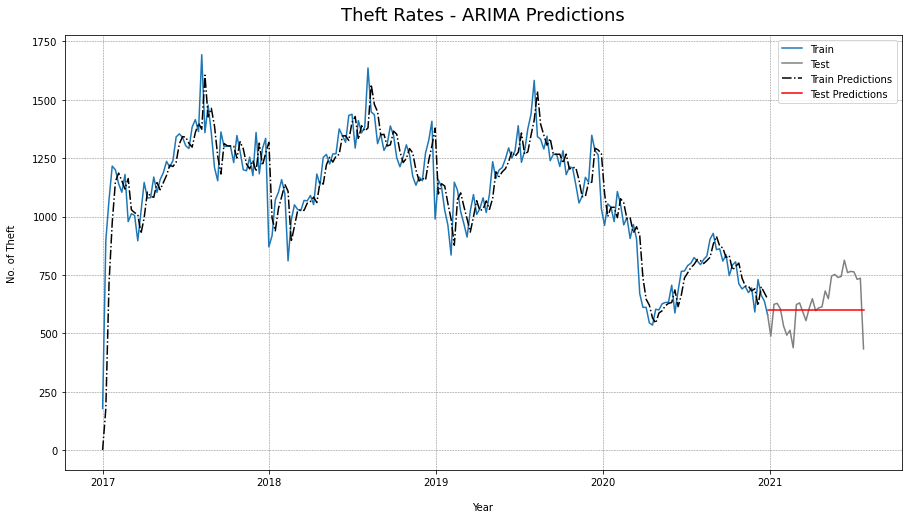

In [126]:
# Instantiate ARIMA model with best hyperparameters.
arima2 = ARIMA(train_theft_w['primary_type'], order=(0, 1, 1))

# Fit ARIMA model.
model2 = arima2.fit()

# Determine len of predictions
start = len(train_theft_w)
end = len(train_theft_w) + len(test_theft_w) - 1

# Generate predictions based on train set.
arima_preds_train2 = model2.predict(end=len(train_theft_w) - 1, typ='level')

# Generate predictions based on test set.
arima_preds_test2 = model2.predict(start=start, end=end, typ='level')

# Plot data
plt.figure(figsize=(15,8))

# Plot training data.
plt.plot(train_theft_w.index, pd.DataFrame(train_theft_w['primary_type']), label='Train')

# Plot testing data.
plt.plot(test_theft_w.index, pd.DataFrame(test_theft_w['primary_type']), label='Test', color = 'grey')

# Plot predicted train values.
plt.plot(train_theft_w.index, arima_preds_train2, label='Train Predictions', color = 'black', linestyle='dashdot')

# Plot predicted test values.
plt.plot(test_theft_w.index, arima_preds_test2, label='Test Predictions', color = 'red')

plt.title(label = 'Theft Rates - ARIMA Predictions', fontsize=18, y =1.02)
plt.legend(loc='best')
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show();

In [127]:
# Evaluation
rms_arima_w = rmse(test_theft_w['primary_type'], arima_preds_test2)
print (f'RMSE score: {rms_arima_w}')

mae_arima_w = mean_absolute_percentage_error(test_theft_w['primary_type'], arima_preds_test2)
print (f'MAE score: {mae_arima_w}')

RMSE score: 107.32241606027002
MAE score: 0.135492310685711


#### SARIMA (Seasonal Autoregressive Integrated Moving Average)

- Similar to ARIMA, a technique forecasts the future value based on past values with a seasonal component

In [128]:
# Finding the best values for p, d, q hyperparameters
sarima2 = auto_arima(train_theft_w['primary_type'], 
                         start_p=0, start_q=0, start_P=0, start_Q=0,
                         d=1, m=12,
                         seasonal=True, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2567.948, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2562.866, Time=0.51 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2561.378, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2566.007, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2559.460, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=2561.379, Time=0.48 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.03 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=2560.541, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=2560.802, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2560.984, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=2557.491, Time=0.07 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=2559.413, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[12]             : AIC=2559.411, Time=0.19 sec
 ARIMA(0,1,1)(1,0,1)[12]     

In [129]:
print(sarima2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  209
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1276.746
Date:                Thu, 09 Sep 2021   AIC                           2557.491
Time:                        04:54:27   BIC                           2564.167
Sample:                             0   HQIC                          2560.190
                                - 209                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2751      0.042     -6.568      0.000      -0.357      -0.193
sigma2      1.255e+04    562.405     22.318      0.000    1.14e+04    1.37e+04
Ljung-Box (L1) (Q):                   1.00   Jarque-

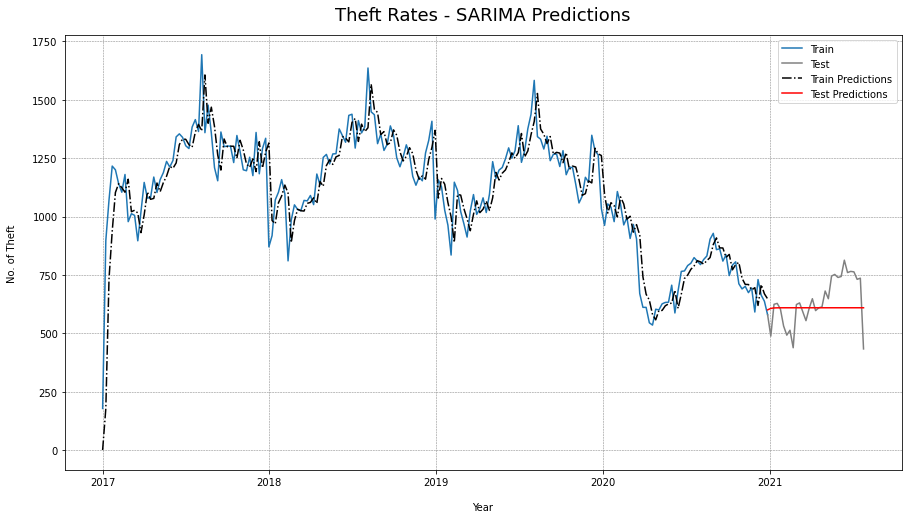

In [130]:
# Instantiate ARIMA model with best hyperparameters.
sarima2 = SARIMAX(train_theft_w['primary_type'], order=(1, 1, 1), seasonal_order=(0, 0, 0, 12))

# Fit ARIMA model.
model2 = sarima2.fit()

# Determine len of predictions
start = len(train_theft_w)
end = len(train_theft_w) + len(test_theft_w) - 1

# Generate predictions based on train set.
sarima_preds_train2 = model2.predict(end=len(train_theft_w) - 1)

# Generate predictions based on test set.
sarima_preds_test2 = model2.predict(start=start, end=end, typ='level')

# Plot data
plt.figure(figsize=(15,8))

# Plot training data.
plt.plot(train_theft_w.index, pd.DataFrame(train_theft_w['primary_type']), label='Train')

# Plot testing data.
plt.plot(test_theft_w.index, pd.DataFrame(test_theft_w['primary_type']), label='Test', color = 'grey')

# Plot predicted train values.
plt.plot(train_theft_w.index, sarima_preds_train2, label='Train Predictions', color = 'black', linestyle='dashdot')

# Plot predicted test values.
plt.plot(test_theft_w.index, sarima_preds_test2, label='Test Predictions', color = 'red')

plt.title(label = 'Theft Rates - SARIMA Predictions', fontsize=18, y =1.02)
plt.legend(loc='best')
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show();

In [131]:
# Evaluation
rms_sarima_w = rmse(test_theft_w['primary_type'], sarima_preds_test2)
print (f'RMSE score: {rms_sarima_w}')

mae_sarima_w = mean_absolute_percentage_error(test_theft_w['primary_type'], sarima_preds_test2)
print (f'MAE score: {mae_sarima_w}')

RMSE score: 103.72661497886186
MAE score: 0.1314470920462335


#### Facebook Prophet

In [132]:
# Prophet models requires data details to follow their format
prophet_train = train_theft_w.copy()
prophet_test = test_theft_w.copy()

# Date as part of features 
prophet_train = prophet_train.reset_index()
prophet_test = prophet_test.reset_index()

# Convert column names
prophet_train.columns = ['ds', 'y']
prophet_test.columns = ['ds', 'y']

In [133]:
# Instantiate prophet
m = Prophet()

# Fit model
m.fit(prophet_train)

# Create future periods (based on date in date - periods are based on test_data)
future = m.make_future_dataframe(periods=31, freq='W')

# Generate predictions based on data
forecast = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


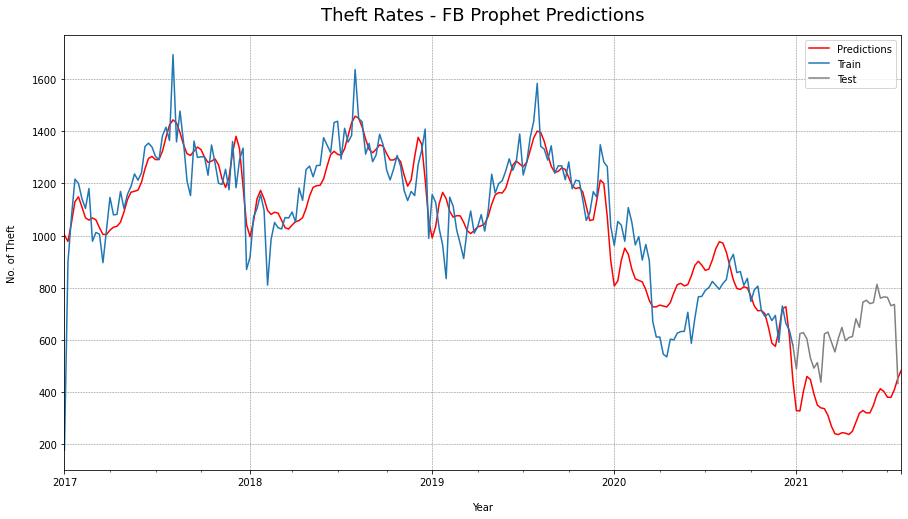

In [134]:
# Plot predicted values (train + test)
ax = forecast.plot(x='ds', y='yhat', label='Predictions', legend=True, color='red', figsize=(15,8))

# Plot training data.
prophet_train.plot(x='ds', y='y', label='Train', legend=True, ax=ax)

# Plot testing data.
prophet_test.plot(x='ds', y='y', label='Test', legend=True, color='grey', ax=ax)

plt.title(label = 'Theft Rates - FB Prophet Predictions', fontsize=18, y =1.02)
plt.legend(loc='best')
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show();

In [135]:
prophet_preds = forecast.iloc[-31:]['yhat']

In [136]:
# Evaluation
rms_prophet = rmse(prophet_test['y'], prophet_preds)
print (f'RMSE score: {rms_prophet}')

mae_prophet = mean_absolute_percentage_error(prophet_test['y'], prophet_preds)
print (f'MAE score: {mae_prophet}')

RMSE score: 312.37195917967136
MAE score: 0.45243367034679677


## **Evaluation**
- Holt Winter ES predict a better score as compared to the rest of the models
- Even after focusing on the exponential drop in the theft rate, we deduce that model did not account for the downward trend hance resulted in a high error marging of close to 50%

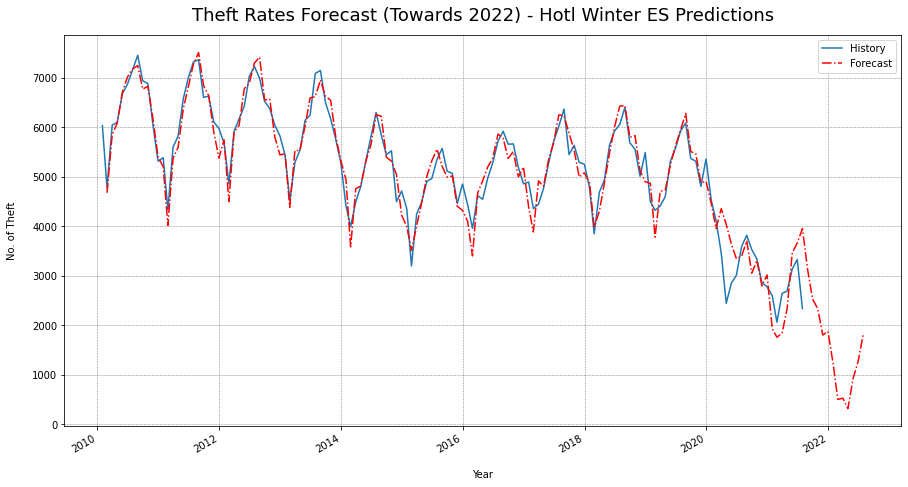

In [137]:
# Instantiate SES
hwes_fc = ExponentialSmoothing(theft_rates['primary_type'], seasonal_periods=12, trend='add', seasonal='add')

# Fit model
model = hwes_fc.fit(optimized=True, use_brute=True)

# Generate predictions based on train set.
hwes_preds = model.predict(start=1, end=len(theft_rates) + 11)
                               
# Plot data.
plt.figure(figsize=(15,8))

# Plot entire data
plt.plot(theft_rates.index, pd.DataFrame(theft_rates['primary_type']), label='History')

# Plot forecast data
hwes_preds.plot(label='Forecast', color = 'red', linestyle='dashdot')

plt.title(label = 'Theft Rates Forecast (Towards 2022) - Holt Winter ES Predictions', fontsize=18, y =1.02)
plt.legend(loc='best')
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show();                             

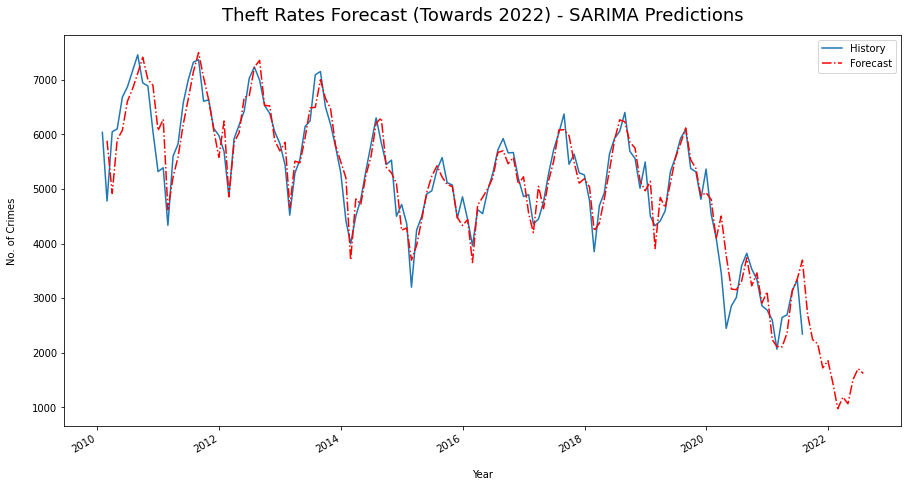

In [138]:
# Instantiate SARIMA model with best hyperparameters.
sarima_fc = SARIMAX(endog=theft_rates['primary_type'], order=(0, 1, 1),
              seasonal_order=(1, 0, 1, 12))

# Fit ARIMA model.
model = sarima_fc.fit()

# Generate predictions based on test set.
sarima_preds = model.predict(start=1, end=len(theft_rates) + 11, typ='levels')

# Plot data.
plt.figure(figsize=(15,8))

# Plot entire data
plt.plot(theft_rates.index, pd.DataFrame(theft_rates['primary_type']), label='History')

# Plot forecast data
sarima_preds.plot(label='Forecast', color = 'red', linestyle='dashdot')


plt.title(label = 'Theft Rates Forecast (Towards 2022) - SARIMA Predictions', fontsize=18, y =1.02)
plt.legend(loc='best')
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Crimes', labelpad=15)
plt.show();

# **Crime - Battery**

In [139]:
battery = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/capstone/assets/clean_data/2010_2021_battery_monthly.csv', index_col='date', parse_dates=True)

### Data Summary

In [140]:
battery.head()

primary_type  afternoon  evening  ...  45to54  65to74  75andmore
date                                          ...                           
2010-01-31          4653       1471     1318  ...  342384  151070     129473
2010-02-28          4241       1379     1177  ...  342384  151070     129473
2010-03-31          6021       1894     1854  ...  342384  151070     129473
2010-04-30          5857       1826     1937  ...  342384  151070     129473
2010-05-31          6396       1904     2092  ...  342384  151070     129473

[5 rows x 233 columns]

In [141]:
# Theft information
battery.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 151 entries, 2010-01-31 to 2022-07-31
Columns: 233 entries, primary_type to 75andmore
dtypes: float64(2), int64(231)
memory usage: 276.0 KB


In [142]:
battery_ori = battery.copy()

In [143]:
# Remove forecast dates (Require only when using SARIMAX)
battery = battery[:-12]

battery.index.freq = 'M'

## Understanding Battery Rates 

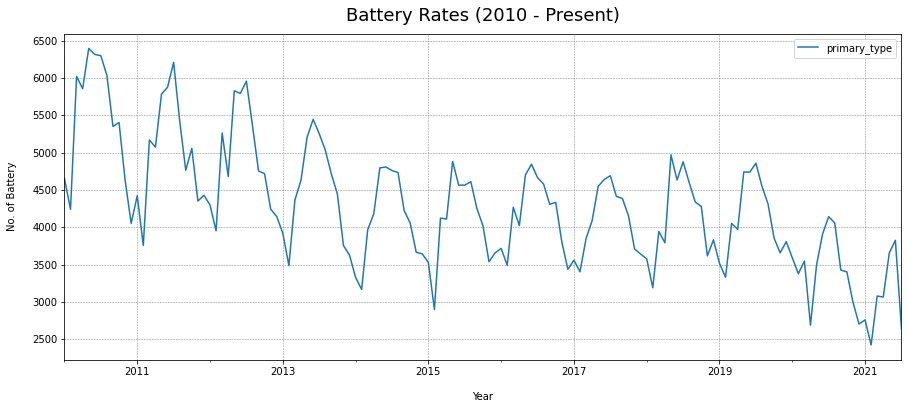

In [144]:
# Battery rates based on from 2010 - present
battery_rates = battery[['primary_type']]

# Plot crime rates from dataset
battery_rates.plot(figsize=(15,6))
plt.title('Battery Rates (2010 - Present)', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Battery', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

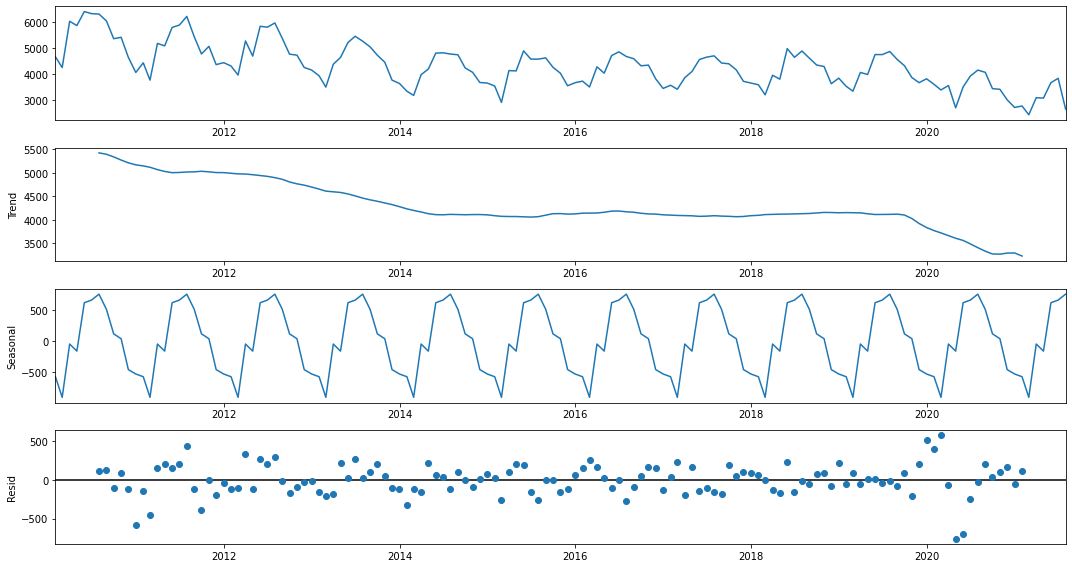

In [145]:
# ETS decomposition
rcParams['figure.figsize'] = 15,8
sm.tsa.seasonal_decompose(battery_rates).plot();

In [146]:
# Function for adfuller test
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print('')
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print('')
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [147]:
# Test for stationarity
adf_test(battery_rates)

Augmented Dickey-Fuller Test: 
ADF test statistic        0.032471
p-value                   0.961136
# lags used              12.000000
# observations          126.000000
critical value (1%)      -3.483346
critical value (5%)      -2.884766
critical value (10%)     -2.579156

Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


### Differencing Data

In [148]:
battery_diff = battery_rates.copy()

In [149]:
# Assign both degree of diff() to columns 
battery_diff['first_diff_crime'] = battery_diff['primary_type'].diff()
battery_diff['second_diff_crime'] = battery_diff['primary_type'].diff().diff()

First Difference

In [150]:
# Stationary Test for first diff()
adf_test(battery_diff['first_diff_crime'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.825594
p-value                   0.054710
# lags used              14.000000
# observations          123.000000
critical value (1%)      -3.484667
critical value (5%)      -2.885340
critical value (10%)     -2.579463

Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


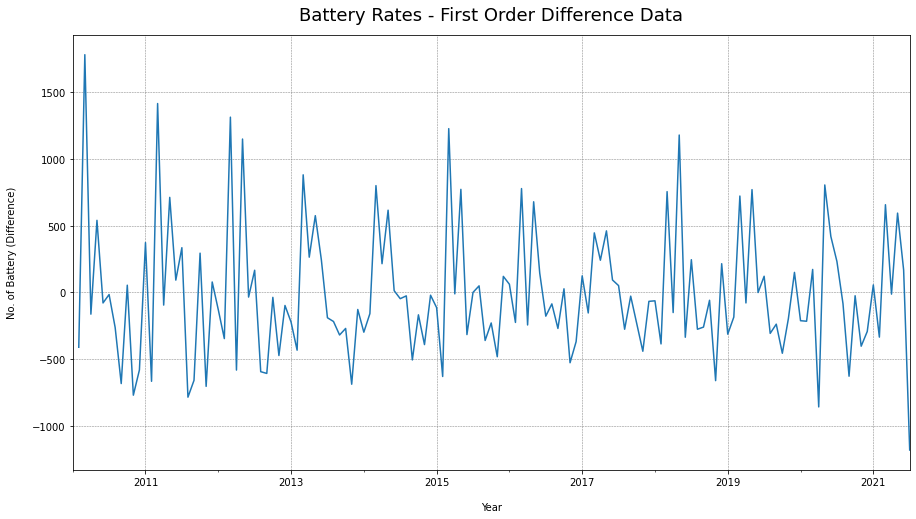

In [151]:
# Plot first diff()
battery_diff['first_diff_crime'].plot()
plt.title('Battery Rates - First Order Difference Data', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Battery (Difference)', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

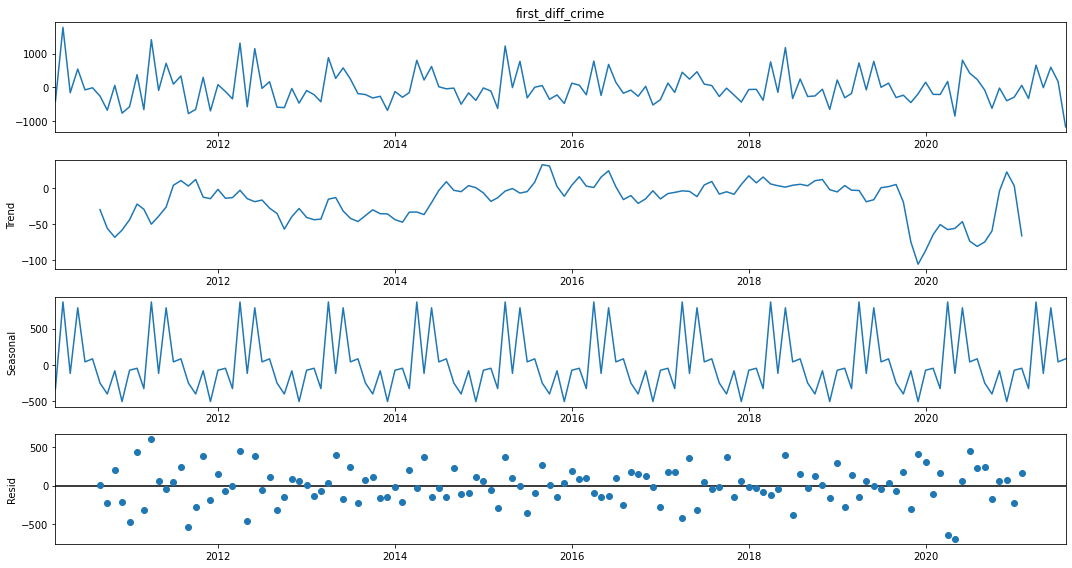

In [152]:
# Drop null values
first_diff = battery_diff['first_diff_crime']
first_diff.dropna(inplace=True)

# ETS decomposition - First Difference
rcParams['figure.figsize'] = 15,8
sm.tsa.seasonal_decompose(first_diff).plot();

Second Difference

In [153]:
# Stationary Test for second diff()
adf_test(battery_diff['second_diff_crime'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -8.540949e+00
p-value                 9.786835e-14
# lags used             1.300000e+01
# observations          1.230000e+02
critical value (1%)    -3.484667e+00
critical value (5%)    -2.885340e+00
critical value (10%)   -2.579463e+00

Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


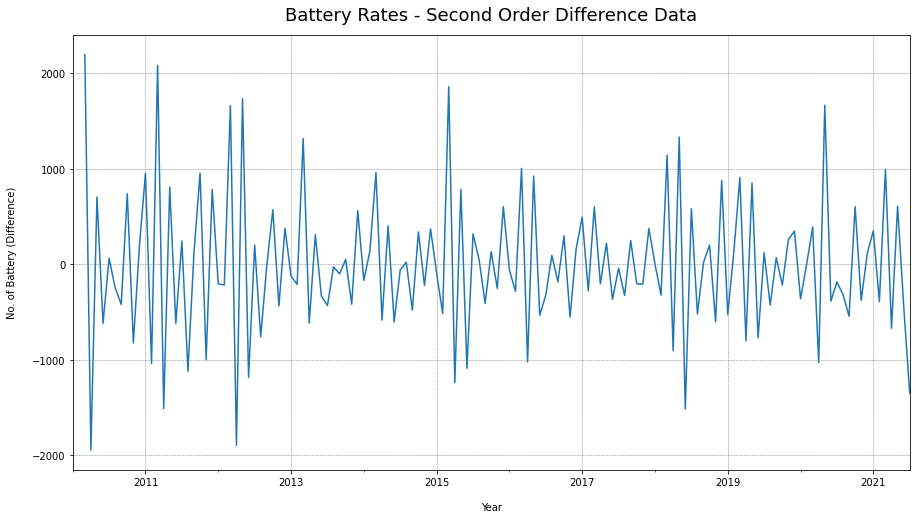

In [154]:
# Plot second diff()
battery_diff['second_diff_crime'].plot()
plt.title('Battery Rates - Second Order Difference Data', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Battery (Difference)', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

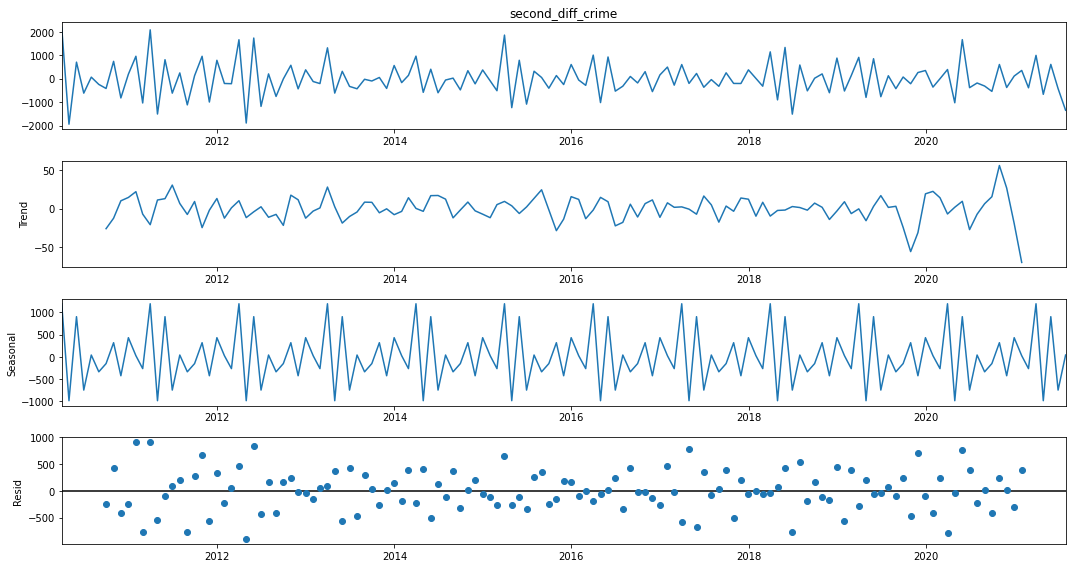

In [155]:
# Drop null values
second_diff = battery_diff['second_diff_crime']
second_diff.dropna(inplace=True)

# ETS decomposition - Second Difference
rcParams['figure.figsize'] = 15,8
sm.tsa.seasonal_decompose(second_diff).plot();

### Normality Test

In [156]:
# Function for Normality Test
def normaltest(df):
  stat, p = shapiro(df)
  print('stat=%.3f, p=%.3f\n' % (stat, p))

  if p > 0.05:
    print('Probably Gaussian')
  else:
    print('Probably not Gaussian')

# Ref: https://towardsdatascience.com/normality-tests-in-python-31e04aa4f411

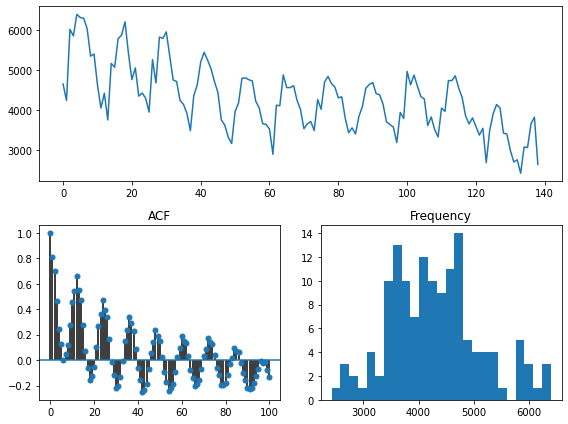

In [157]:
# Understanding the frequency of Battery
tsdisplay(battery_rates, lag_max=100)

In [158]:
# Normality Test on Theft (Original)
normaltest(battery_rates)

stat=0.981, p=0.045

Probably not Gaussian


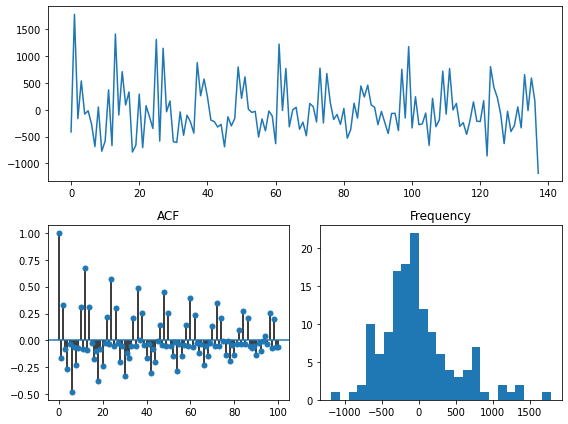

In [159]:
# Understanding the frequency of Battery with First Diff
tsdisplay(first_diff, lag_max=100)

In [160]:
# Normality Test on Theft (First Difference)
normaltest(first_diff)

stat=0.945, p=0.000

Probably not Gaussian


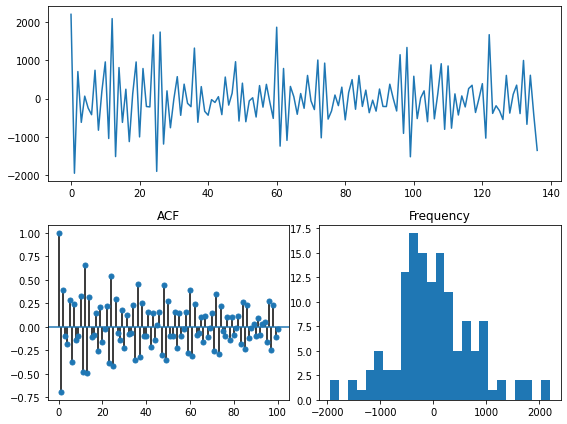

In [161]:
# Understanding the frequency of Battery with First Diff
tsdisplay(second_diff, lag_max=100)

In [162]:
# Normality Test on Theft (First Difference)
normaltest(second_diff)

stat=0.982, p=0.070

Probably Gaussian


## **Time-Series Modelling**

### Train Test Split

In [163]:
# Train Test Split
train_battery = battery_rates[:'2019-01-01']
test_battery = battery_rates['2018-11-30':]

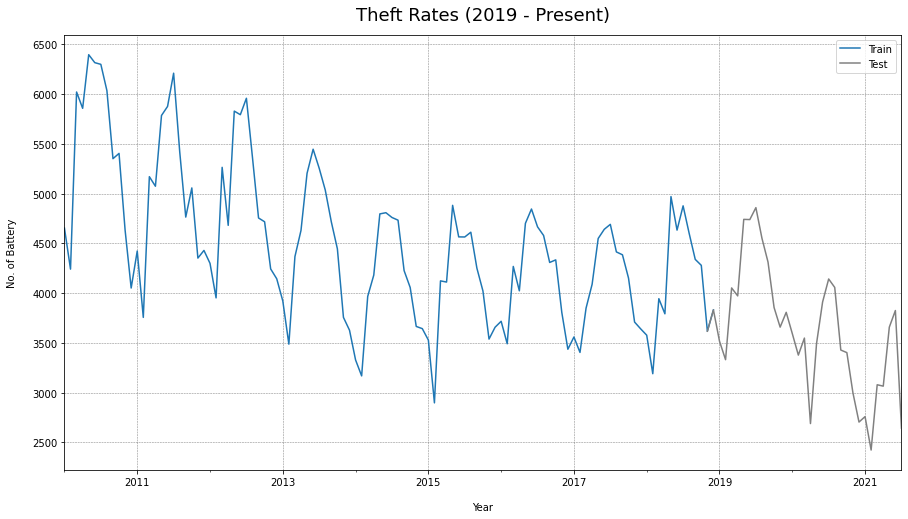

In [164]:
# Check the split
train_battery['primary_type'].plot(figsize=(15, 8), label='Train')
test_battery['primary_type'].plot(label='Test', color='grey')

plt.title('Theft Rates (2019 - Present)', fontsize=18, y=1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Battery', labelpad=15)
plt.legend(loc='best')
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show();

### ACF & PACF

<Figure size 1080x576 with 0 Axes>

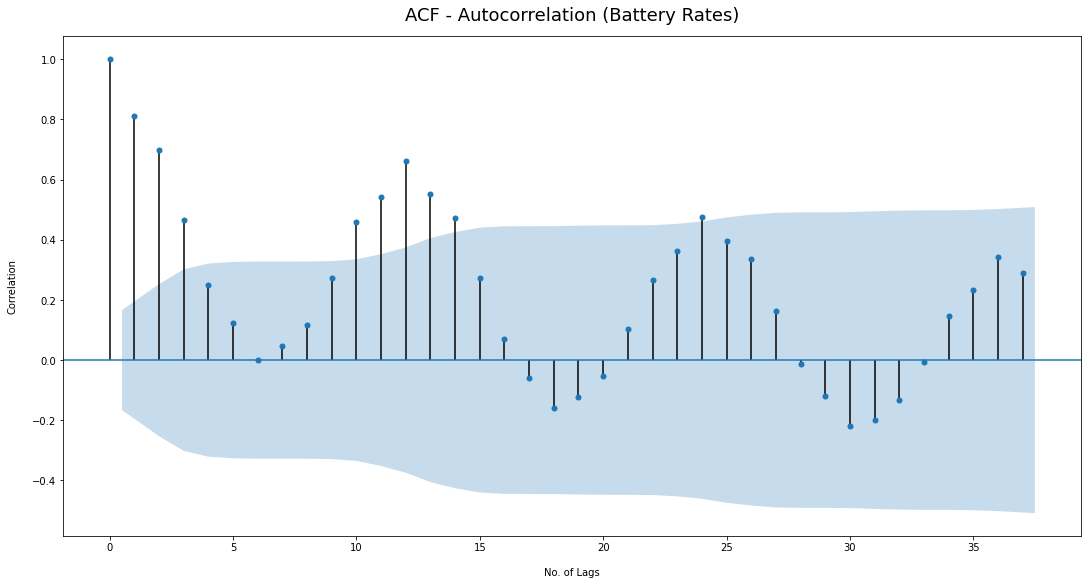

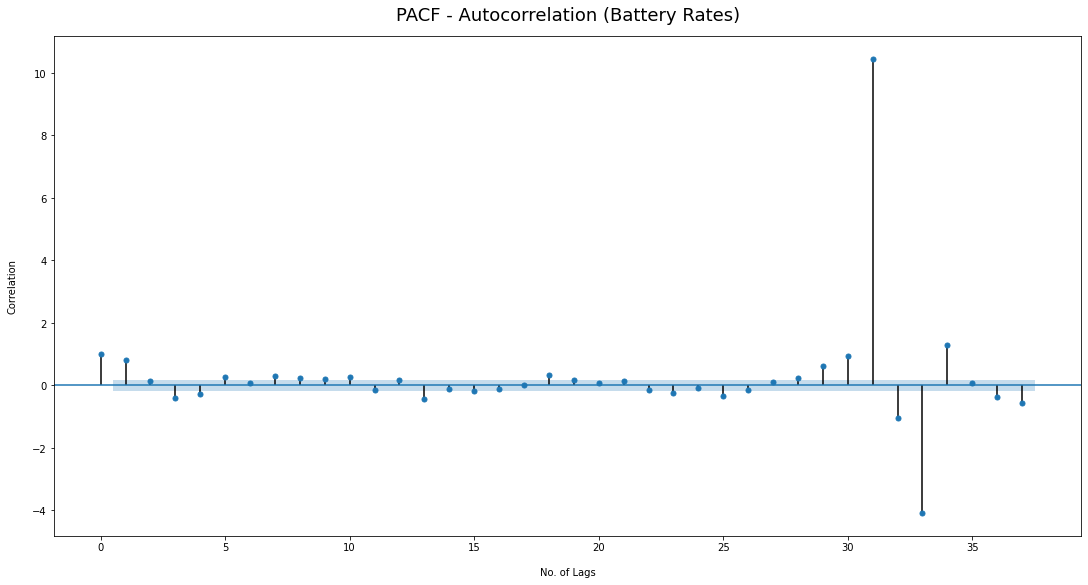

In [165]:
# Plot ACF & PACF for Battery
plt.figure(figsize=(15,8))
plot_acf(battery_rates['primary_type'], lags=37)

plt.title('ACF - Autocorrelation (Battery Rates)', fontsize=18, y=1.02)
plt.xlabel('No. of Lags', labelpad=15)
plt.ylabel('Correlation', labelpad=15)
plt.tight_layout(pad=0.3)

plot_pacf(battery_rates['primary_type'], lags=37)

plt.title('PACF - Autocorrelation (Battery Rates)', fontsize=18, y=1.02)
plt.xlabel('No. of Lags', labelpad=15)
plt.ylabel('Correlation', labelpad=15)
plt.tight_layout(pad=0.3);

<Figure size 1080x576 with 0 Axes>

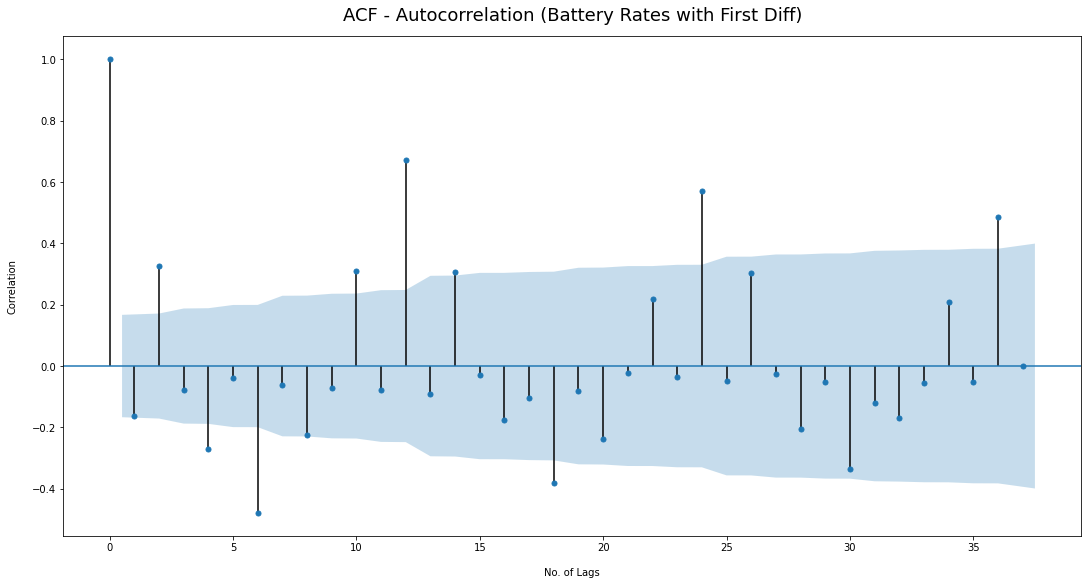

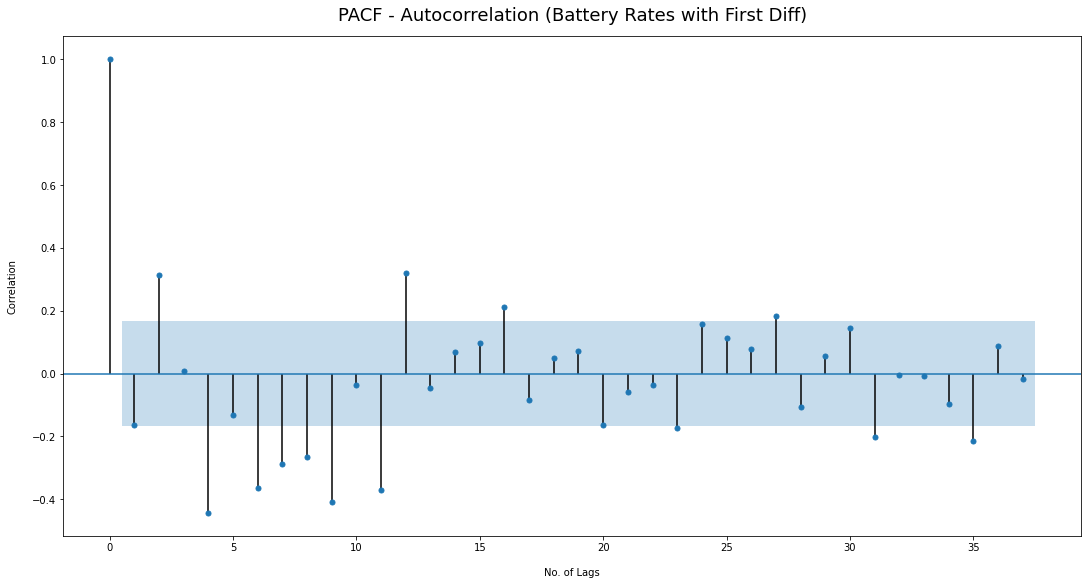

In [166]:
# Plot ACF & PACF Battery with First Diff
first_diff = pd.DataFrame(first_diff)

plt.figure(figsize=(15,8))
plot_acf(first_diff['first_diff_crime'], lags=37)

plt.title('ACF - Autocorrelation (Battery Rates with First Diff)', fontsize=18, y=1.02)
plt.xlabel('No. of Lags', labelpad=15)
plt.ylabel('Correlation', labelpad=15)
plt.tight_layout(pad=0.3)

plot_pacf(first_diff['first_diff_crime'], lags=37)

plt.title('PACF - Autocorrelation (Battery Rates with First Diff)', fontsize=18, y=1.02)
plt.xlabel('No. of Lags', labelpad=15) 
plt.ylabel('Correlation', labelpad=15)
plt.tight_layout(pad=0.3);

<Figure size 1080x576 with 0 Axes>

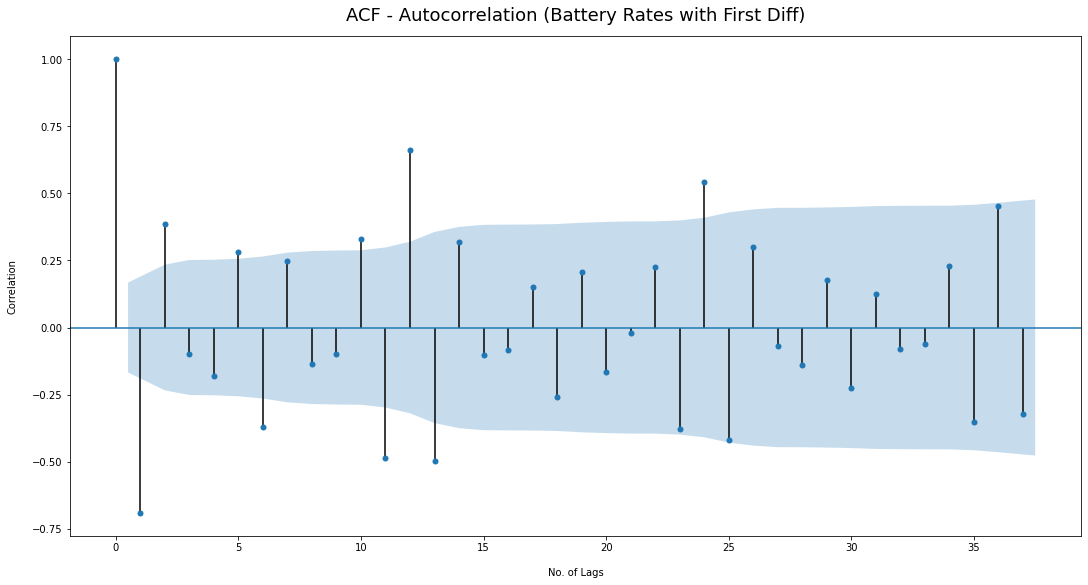

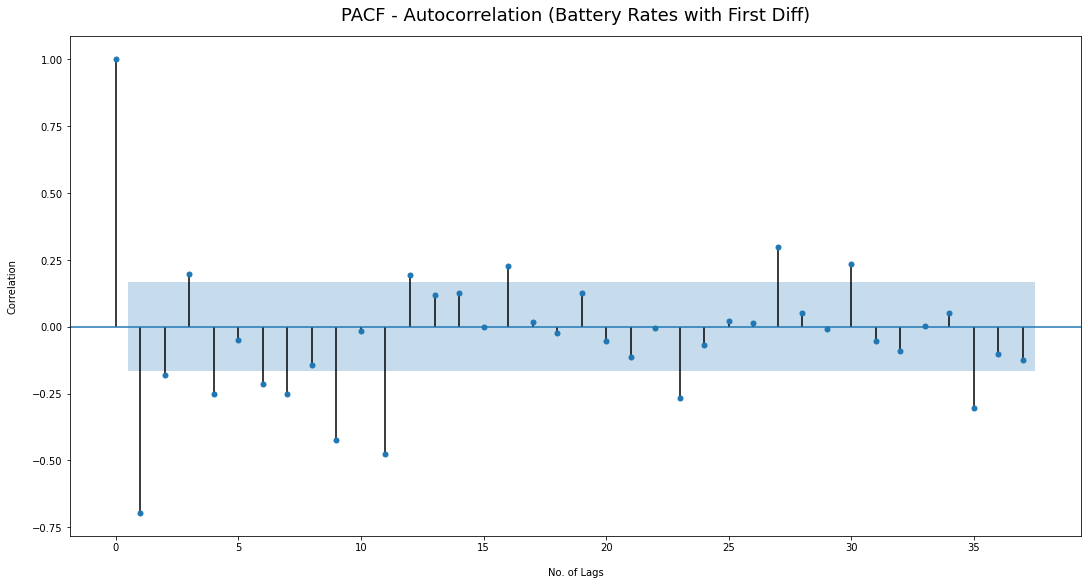

In [167]:
# Plot ACF & PACF Battery with First Diff
second_diff = pd.DataFrame(second_diff)

plt.figure(figsize=(15,8))
plot_acf(second_diff['second_diff_crime'], lags=37)

plt.title('ACF - Autocorrelation (Battery Rates with First Diff)', fontsize=18, y=1.02)
plt.xlabel('No. of Lags', labelpad=15)
plt.ylabel('Correlation', labelpad=15)
plt.tight_layout(pad=0.3)

plot_pacf(second_diff['second_diff_crime'], lags=37)

plt.title('PACF - Autocorrelation (Battery Rates with First Diff)', fontsize=18, y=1.02)
plt.xlabel('No. of Lags', labelpad=15) 
plt.ylabel('Correlation', labelpad=15)
plt.tight_layout(pad=0.3);

### Simple Exponential Smoothing

- Technique forecasts the next value using a weighted average of all previous values where the weights decay exponentially from the most recent to the oldest historical value.

In [168]:
# Ref: https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/

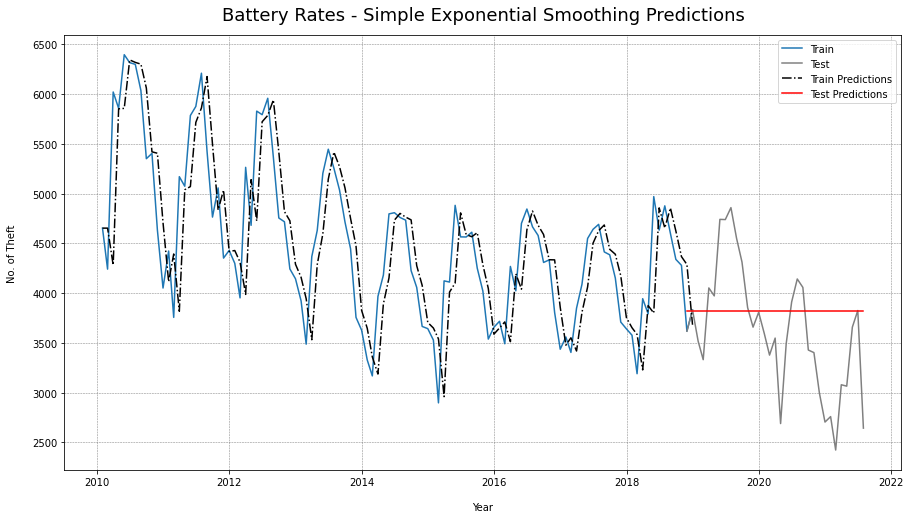

In [169]:
# Instantiate SES
ses = SimpleExpSmoothing(train_battery['primary_type'])

# Fit model
model = ses.fit()

# Determine len of predictions
start = len(train_battery)
end = len(train_battery) + len(test_battery) - 1

# Generate predictions based on train set.
ses_preds_train = model.predict(start=0, end=len(train_battery) - 1)

# Generate predictions based on test set.
ses_preds_test = model.predict(start=start, end=end)
                               
# Plot data.
plt.figure(figsize=(15,8))

# Plot training data.
plt.plot(train_battery.index, pd.DataFrame(train_battery['primary_type']), label='Train')

# Plot testing data.
plt.plot(test_battery.index, pd.DataFrame(test_battery['primary_type']), label='Test', color = 'grey')

# Plot predicted train values.
plt.plot(train_battery.index, ses_preds_train, label='Train Predictions', color = 'black', linestyle='dashdot')

# Plot predicted test values.
plt.plot(test_battery.index, ses_preds_test, label='Test Predictions', color = 'red')

plt.title(label = 'Battery Rates - Simple Exponential Smoothing Predictions', fontsize=18, y =1.02)
plt.legend(loc='best')
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show();                             

In [170]:
print(model.summary())

                       SimpleExpSmoothing Model Results                       
Dep. Variable:           primary_type   No. Observations:                  108
Model:             SimpleExpSmoothing   SSE                       26425891.950
Optimized:                       True   AIC                           1344.034
Trend:                           None   BIC                           1349.398
Seasonal:                        None   AICC                          1344.423
Seasonal Periods:                None   Date:                 Thu, 09 Sep 2021
Box-Cox:                        False   Time:                         04:54:41
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9029070                alpha                 True
initial_level              4653.0000                

In [171]:
# Evaluation
rms_ses = rmse(test_battery['primary_type'], ses_preds_test)
print (f'RMSE score: {rms_ses}')

mae_ses = mean_absolute_percentage_error(test_battery['primary_type'], ses_preds_test)
print (f'MAE score: {mae_ses}')

RMSE score: 644.6670805178474
MAE score: 0.1550771639232788


### Holt Winters Exponential Smoothing

- Fixes one of the two shortcomings of the simple ES technique. Holt Winters ES can be used to forecast time series data that has a trend and seasonality


In [172]:
# Ref: https://towardsdatascience.com/holt-winters-exponential-smoothing-d703072c0572

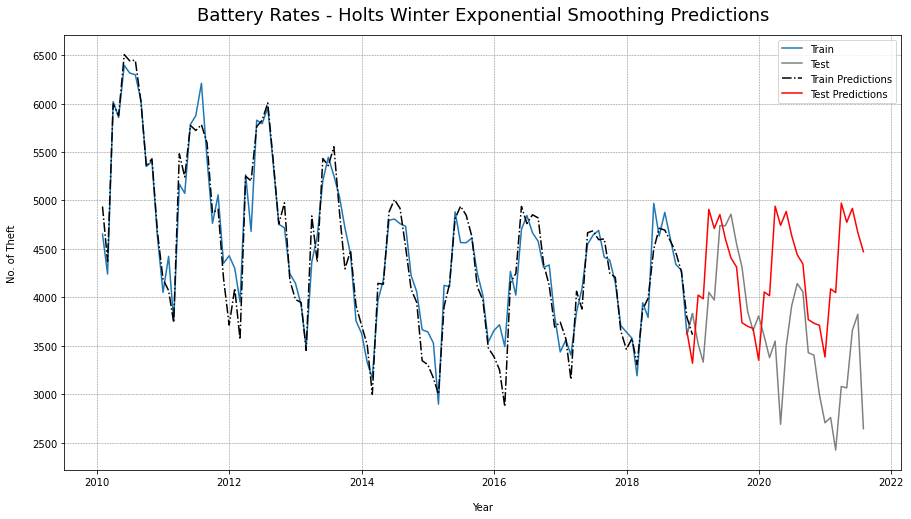

In [173]:
# Instantiate SES
hwes = ExponentialSmoothing(train_battery['primary_type'], seasonal_periods=12, trend='add', seasonal='add')

# Fit model
model = hwes.fit(optimized=True, use_brute=True)

# Determine len of predictions
start = len(train_battery)
end = len(train_battery) + len(test_battery) - 1

# Generate predictions based on train set.
hwes_preds_train = model.predict(start=0, end=len(train_battery) - 1)

# Generate predictions based on test set.
hwes_preds_test = model.predict(start=start, end=end)
                               
# Plot data.
plt.figure(figsize=(15,8))

# Plot training data.
plt.plot(train_battery.index, pd.DataFrame(train_battery['primary_type']), label='Train')

# Plot testing data.
plt.plot(test_battery.index, pd.DataFrame(test_battery['primary_type']), label='Test', color = 'grey')

# Plot predicted train values.
plt.plot(train_battery.index, hwes_preds_train, label='Train Predictions', color = 'black', linestyle='dashdot')

# Plot predicted test values.
plt.plot(test_battery.index, hwes_preds_test, label='Test Predictions', color = 'red')

plt.title(label = 'Battery Rates - Holts Winter Exponential Smoothing Predictions', fontsize=18, y =1.02)
plt.legend(loc='best')
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show();                             

In [174]:
print(model.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:             primary_type   No. Observations:                  108
Model:             ExponentialSmoothing   SSE                        5119769.506
Optimized:                         True   AIC                           1194.781
Trend:                         Additive   BIC                           1237.695
Seasonal:                      Additive   AICC                          1202.466
Seasonal Periods:                    12   Date:                 Thu, 09 Sep 2021
Box-Cox:                          False   Time:                         04:54:41
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2533584                alpha                 True
smoothing_trend          

In [175]:
# Evaluation
rms_hwes = rmse(test_battery['primary_type'], hwes_preds_test)
print (f'RMSE score: {rms_hwes}')

mae_hwes = mean_absolute_percentage_error(test_battery['primary_type'], hwes_preds_test)
print (f'MAE score: {mae_hwes}')

RMSE score: 957.5006252499854
MAE score: 0.23772509120274268


### ARIMA (Auto Regressive Integrated Moving Average) 

- Technique forecasts the future value based on past values with parameter p (AR), d (I), q (MA)

In [176]:
# Finding the best values for p, d, q hyperparameters
arima = auto_arima(train_battery['primary_type'], 
                         start_p=0, start_q=0, 
                         d=1, 
                         seasonal=False, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1638.155, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1636.425, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1638.110, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1636.180, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1632.457, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1618.530, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1616.519, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1618.443, Time=0.26 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1613.918, Time=0.35 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1555.469, Time=0.52 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1590.423, Time=0.22 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1556.969, Time=0.62 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1544.568, Time=0.57 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1563.745, Time=0.48 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept

In [177]:
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  108
Model:               SARIMAX(5, 1, 4)   Log Likelihood                -751.273
Date:                Thu, 09 Sep 2021   AIC                           1522.545
Time:                        04:54:56   BIC                           1549.274
Sample:                             0   HQIC                          1533.381
                                - 108                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4905      0.128     -3.844      0.000      -0.741      -0.240
ar.L2          1.0130      0.018     55.669      0.000       0.977       1.049
ar.L3          0.4909      0.133      3.705      0.0

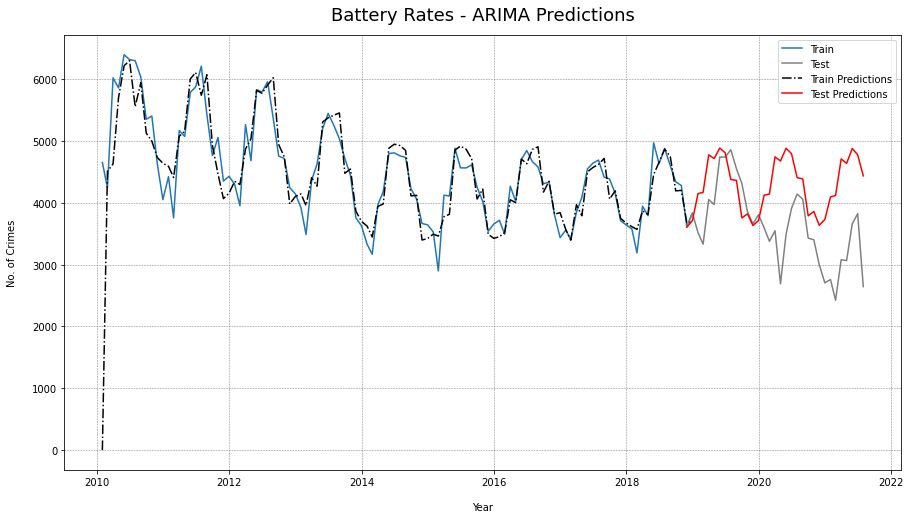

In [178]:
# Instantiate ARIMA model with best hyperparameters.
arima = ARIMA(train_battery['primary_type'], order=(5, 1, 4))

# Fit ARIMA model.
model = arima.fit()

# Determine len of predictions
start = len(train_battery)
end = len(train_battery) + len(test_battery) - 1

# Generate predictions based on train set.
arima_preds_train = model.predict(end=len(train_battery) - 1, typ='level')

# Generate predictions based on test set.
arima_preds_test = model.predict(start=start, end=end, typ='level')

# Plot data
plt.figure(figsize=(15,8))

# Plot training data.
plt.plot(train_battery.index, pd.DataFrame(train_battery['primary_type']), label='Train')

# Plot testing data.
plt.plot(test_battery.index, pd.DataFrame(test_battery['primary_type']), label='Test', color = 'grey')

# Plot predicted train values.
plt.plot(train_battery.index, arima_preds_train, label='Train Predictions', color = 'black', linestyle='dashdot')

# Plot predicted test values.
plt.plot(test_battery.index, arima_preds_test, label='Test Predictions', color = 'red')

plt.title(label = 'Battery Rates - ARIMA Predictions', fontsize=18, y =1.02)
plt.legend(loc='best')
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Crimes', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show();

In [179]:
# Evaluation
rms_arima = rmse(test_battery['primary_type'], arima_preds_test)
print (f'RMSE score: {rms_arima}')

mae_arima = mean_absolute_percentage_error(test_battery['primary_type'], arima_preds_test)
print (f'MAE score: {mae_arima}')

RMSE score: 939.4849678413417
MAE score: 0.23404132387253326


### SARIMA (Seasonal Autoregressive Integrated Moving Average)

- Similar to ARIMA, a technique forecasts the future value based on past values with a seasonal component

In [180]:
# Finding the best values for p, d, q hyperparameters
sarima = auto_arima(train_battery['primary_type'], 
                         start_p=0, start_q=0, start_P=0, start_Q=0,
                         d=1, m=12,
                         seasonal=True, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1638.155, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1512.032, Time=0.54 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1581.665, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1636.180, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1636.425, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=1.36 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1502.866, Time=0.69 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1578.579, Time=0.24 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.87 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=1503.872, Time=2.01 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=1554.959, Time=0.84 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=2.22 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1520.792, Time=0.56 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=1504.639, Time=1.02 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept

In [181]:
print(sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -744.643
Date:                            Thu, 09 Sep 2021   AIC                           1499.286
Time:                                    04:55:46   BIC                           1512.650
Sample:                                         0   HQIC                          1504.703
                                            - 108                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3686      0.118      3.136      0.002       0.138       0.599
ma.L1         -0.8536      0.075   

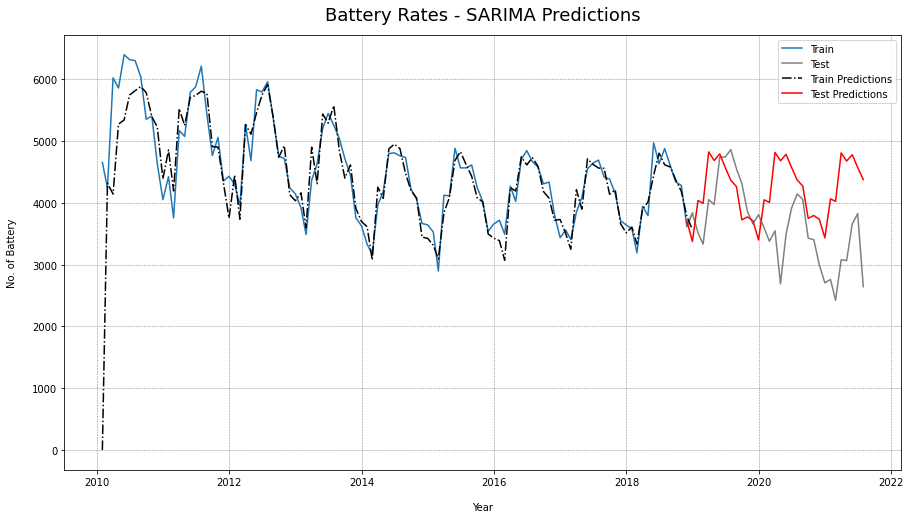

In [182]:
# Instantiate ARIMA model with best hyperparameters.
sarima = SARIMAX(train_battery['primary_type'], order=(1, 1, 1), seasonal_order=(1, 0, 1, 12))

# Fit ARIMA model.
model = sarima.fit()

# Determine len of predictions
start = len(train_battery)
end = len(train_battery) + len(test_battery) - 1

# Generate predictions based on train set.
sarima_preds_train = model.predict(end=len(train_battery) - 1, typ='level')

# Generate predictions based on test set.
sarima_preds_test = model.predict(start=start, end=end, typ='level')

# Plot data
plt.figure(figsize=(15,8))

# Plot training data.
plt.plot(train_battery.index, pd.DataFrame(train_battery['primary_type']), label='Train')

# Plot testing data.
plt.plot(test_battery.index, pd.DataFrame(test_battery['primary_type']), label='Test', color = 'grey')

# Plot predicted train values.
plt.plot(train_battery.index, sarima_preds_train, label='Train Predictions', color = 'black', linestyle='dashdot')

# Plot predicted test values.
plt.plot(test_battery.index, sarima_preds_test, label='Test Predictions', color = 'red')

plt.title(label = 'Battery Rates - SARIMA Predictions', fontsize=18, y =1.02)
plt.legend(loc='best')
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Battery', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show();

In [183]:
# Evaluation
rms_sarima = rmse(test_battery['primary_type'], sarima_preds_test)
print (f'RMSE score: {rms_sarima}')

mae_sarima = mean_absolute_percentage_error(test_battery['primary_type'], sarima_preds_test)
print (f'MAE score: {mae_sarima}')

RMSE score: 908.9234664920424
MAE score: 0.22753309187502174


### Facebook Prophet

In [184]:
# Prophet models requires data details to follow their format
prophet_train = train_battery.copy()
prophet_test = test_battery.copy()

# Date as part of features 
prophet_train = prophet_train.reset_index()
prophet_test = prophet_test.reset_index()

# Convert column names
prophet_train.columns = ['ds', 'y']
prophet_test.columns = ['ds', 'y']

In [185]:
# Instantiate prophet
m = Prophet()

# Fit model
m.fit(prophet_train)

# Create future periods (based on date in date - periods are based on test_data)
future = m.make_future_dataframe(periods=43, freq='M')

# Generate predictions based on data
forecast = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


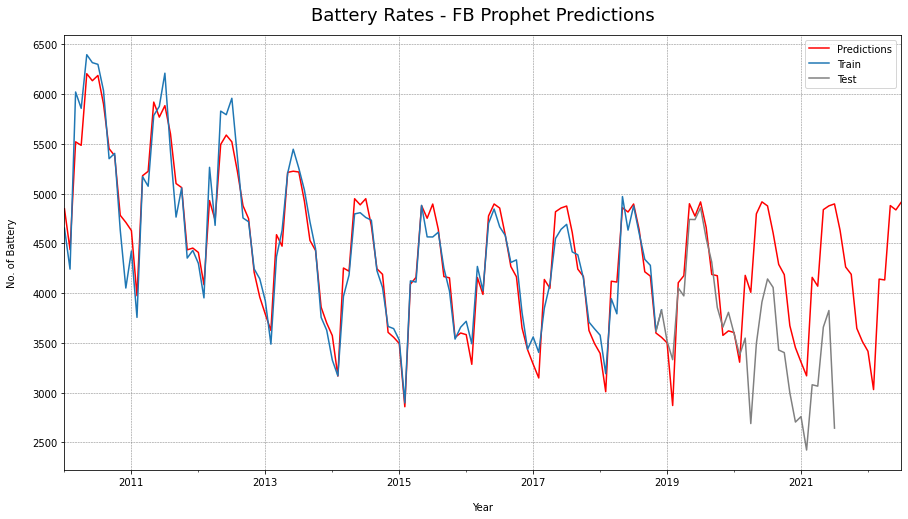

In [186]:
# Plot predicted values (train + test)
ax = forecast.plot(x='ds', y='yhat', label='Predictions', legend=True, color='red', figsize=(15,8))

# Plot training data.
prophet_train.plot(x='ds', y='y', label='Train', legend=True, ax=ax)

# Plot testing data.
prophet_test.plot(x='ds', y='y', label='Test', legend=True, color='grey', ax=ax)

plt.title(label = 'Battery Rates - FB Prophet Predictions', fontsize=18, y =1.02)
plt.legend(loc='best')
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Battery', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show();

In [187]:
prophet_preds = forecast.iloc[-33:]['yhat']

In [188]:
# Evaluation
rms_prophet = rmse(prophet_test['y'], prophet_preds)
print (f'RMSE score: {rms_prophet}')

mae_prophet = mean_absolute_percentage_error(prophet_test['y'], prophet_preds)
print (f'MAE score: {mae_prophet}')

RMSE score: 769.3993594730875
MAE score: 0.17593162154438255


### Recurrent Neural Network

In [189]:
battery_rates.index.max()

Timestamp('2021-07-31 00:00:00', freq='M')

In [190]:
train_rnn = train_battery[['primary_type']]
test_rnn = test_battery[['primary_type']]

In [191]:
from sklearn.preprocessing import MinMaxScaler

# Instantiate MinMaxScaler
scaler = MinMaxScaler()

# Fit scaler
scaler.fit(train_rnn)

MinMaxScaler()

In [192]:
# Scaled data
Z_train = scaler.transform(train_rnn)
Z_test = scaler.transform(test_rnn)

Model

In [193]:
n_input = 12
n_features = 1
train_generator = TimeseriesGenerator(Z_train, Z_train, length=n_input, batch_size=1)

In [194]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='bce', metrics=['acc'])
es = EarlyStopping(patience = 5)

In [195]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 404       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 41,209
Trainable params: 41,209
Non-trainable params: 0
_________________________________________________________________
None


In [196]:
# Fit model
model.fit_generator(train_generator, epochs=25,  callbacks = [es])

Epoch 1/25
96/96 [==============================] - 2s 6ms/step - loss: 0.6901 - acc: 0.0000e+00


Epoch 2/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6856 - acc: 0.0104


Epoch 3/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6829 - acc: 0.0104


Epoch 4/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6763 - acc: 0.0104


Epoch 5/25
96/96 [==============================] - 1s 6ms/step - loss: 0.6580 - acc: 0.0104


Epoch 6/25
96/96 [==============================] - 1s 6ms/step - loss: 0.6460 - acc: 0.0104


Epoch 7/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6438 - acc: 0.0104


Epoch 8/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6389 - acc: 0.0104


Epoch 9/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6534 - acc: 0.0104


Epoch 10/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6401 - acc: 0.0104


Epoch 11/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6379 - acc: 0.0104


Epoch 12/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6328 - acc: 0.0104


Epoch 13/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6335 - acc: 0.0104


Epoch 14/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6341 - acc: 0.0104


Epoch 15/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6315 - acc: 0.0104


Epoch 16/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6218 - acc: 0.0104


Epoch 17/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6230 - acc: 0.0104


Epoch 18/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6217 - acc: 0.0104


Epoch 19/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6240 - acc: 0.0104


Epoch 20/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6159 - acc: 0.0104


Epoch 21/25
96/96 [==============================] - 1s 6ms/step - loss: 0.6187 - acc: 0.0104


Epoch 22/25
96/96 [==============================] - 1s 6ms/step - loss: 0.6216 - acc: 0.0104


Epoch 23/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6188 - acc: 0.0104


Epoch 24/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6142 - acc: 0.0104


Epoch 25/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6118 - acc: 0.0104


In [197]:
model.history.history.keys

<function dict.keys>

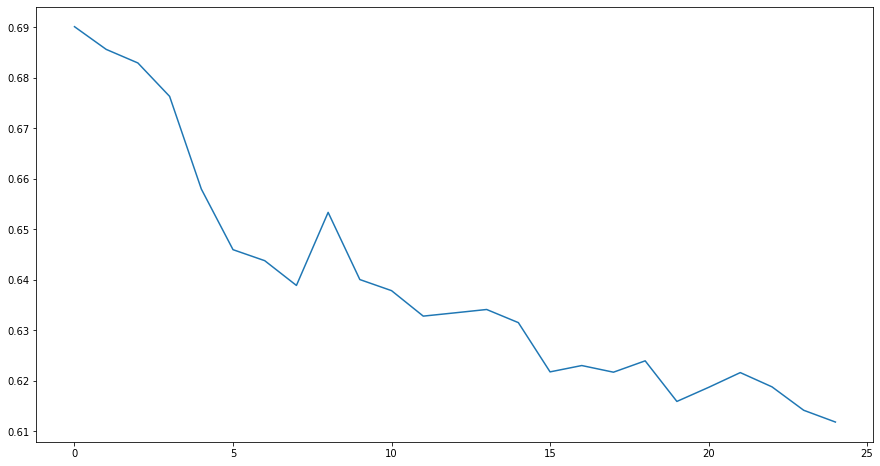

In [198]:
# Understand loss
myloss = model.history.history['loss']

plt.plot(range(len(myloss)), myloss)

In [199]:
# 12 history steps ---> step 13
# last 12 points train ---> pt 1 of test data

In [200]:
first_eval_batch = Z_train[-12:]

In [201]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

Forecast

In [202]:
# Holding predictions
test_predictions = []

#last n_input points from the training set
first_eval_batch = Z_train[-n_input:]

# Reshape this to the format RNN wants (same as TimeseriesGenerator)
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [203]:
# How far into the future will be forecasted
# len(test)
for i in range(len(test_battery)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [204]:
true_predictions = scaler.inverse_transform(test_predictions)

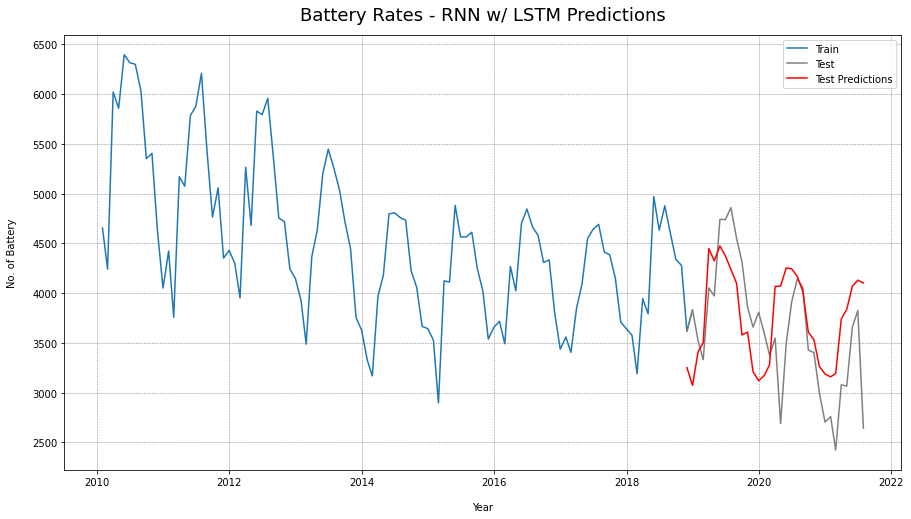

In [205]:
# Plot data
plt.figure(figsize=(15,8))

# Plot training data.
plt.plot(train_theft.index, pd.DataFrame(train_battery['primary_type']), label='Train')

# Plot testing data.
plt.plot(test_theft.index, pd.DataFrame(test_battery['primary_type']), label='Test', color = 'grey')

# Plot predicted test values.
plt.plot(test_theft.index, true_predictions, label='Test Predictions', color = 'red')

plt.title(label = 'Battery Rates - RNN w/ LSTM Predictions', fontsize=18, y =1.02)
plt.legend(loc='best')
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Battery', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show();

In [206]:
test_battery['rnn_predictions'] = true_predictions

In [207]:
# Evaluation
rms_rnn = rmse(test_battery['primary_type'], test_battery['rnn_predictions'])
print (f'RMSE score: {rms_rnn}')

mae_rnn = mean_absolute_percentage_error(test_battery['primary_type'], test_battery['rnn_predictions'])
print (f'MAE score: {mae_rnn}')

RMSE score: 568.8886072599497
MAE score: 0.14001466357953615


### SARIMAX (Seasonal Autoregressive Integrated Moving Average with Exogenous Variable)
Further look explore the model with exogenous variable to see the impact of external factors
- Requirement: Exog features are available values from past, present and into the future

In [208]:
# Loading original data
battery_rates_fc = battery_ori.copy()

# Filter data with exog variables
battery_rates_fc = battery_rates_fc[['primary_type', 'holiday', 'isweekend', 'unemployment_rate', 'avg_temp']]

In [209]:
battery_rates_fc.tail()

primary_type  holiday  isweekend  unemployment_rate  avg_temp
date                                                                     
2022-03-31             0        0         12               10.7      51.4
2022-04-30             0        0         14               10.7      51.4
2022-05-31             0        1         13               10.7      51.4
2022-06-30             0        0         12               10.7      51.4
2022-07-31             0        1         15               10.7      51.4

In [210]:
# Train Test Split
train_battery = battery_rates_fc[:'2019-01-01']
test_battery = battery_rates_fc['2018-11-30':'2021-07-31']
fc_battery = battery_rates_fc['2021-06-30':]

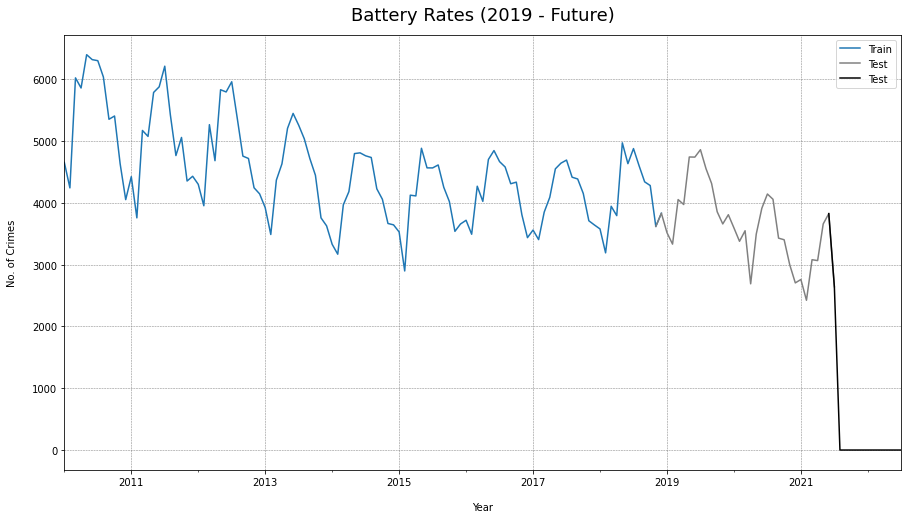

In [211]:
# Check the split
train_battery['primary_type'].plot(figsize=(15, 8), label='Train')
test_battery['primary_type'].plot(label='Test', color='grey')
fc_battery['primary_type'].plot(label='Test', color='black')

plt.title('Battery Rates (2019 - Future)', fontsize=18, y=1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Crimes', labelpad=15)
plt.legend(loc='best')
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show();

In [212]:
# Assign exogenous variable
train_exog =  train_battery[['holiday', 'unemployment_rate', 'avg_temp']]
test_exog =  test_battery[['holiday', 'unemployment_rate', 'avg_temp']]
fc_exog =  fc_battery[['holiday', 'unemployment_rate', 'avg_temp']]

In [213]:
# Finding the best values for p, d, q hyperparameters
sarimax = auto_arima(train_battery['primary_type'], exog=train_exog,
                         start_p=0, start_q=0, start_P=0, start_Q=0,
                         d=1, m=12,
                         seasonal=True, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1638.155, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1512.032, Time=0.53 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1581.665, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1636.180, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1636.425, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=1.34 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1502.866, Time=0.70 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1578.579, Time=0.24 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.91 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=1503.872, Time=1.98 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=1554.959, Time=0.82 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=2.26 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1520.792, Time=0.56 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=1504.639, Time=1.00 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept

In [214]:
print(sarimax.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -744.643
Date:                            Thu, 09 Sep 2021   AIC                           1499.286
Time:                                    04:57:08   BIC                           1512.650
Sample:                                         0   HQIC                          1504.703
                                            - 108                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3686      0.118      3.136      0.002       0.138       0.599
ma.L1         -0.8536      0.075   

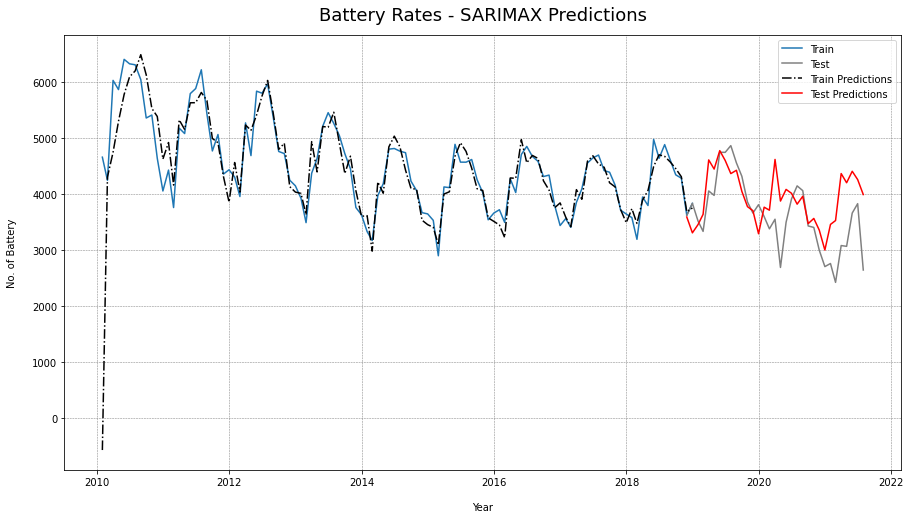

In [215]:
# Instantiate ARIMA model with best hyperparameters.
sarimax = SARIMAX(train_battery['primary_type'], exog=train_exog, order=(1, 1, 1), seasonal_order=(1, 0, 1, 12))

# Fit ARIMA model.
model = sarimax.fit()

# Determine len of predictions
start = len(train_battery)
end = len(train_battery) + len(test_battery) - 1

# Generate predictions based on train set.
sarimax_preds_train = model.predict(end=len(train_battery) - 1, exog=train_exog, typ='level')

# Generate predictions based on test set.
sarimax_preds_test = model.predict(start=start, end=end, exog=test_exog, typ='level')

# Plot data
plt.figure(figsize=(15,8))

# Plot training data.
plt.plot(train_battery.index, pd.DataFrame(train_battery['primary_type']), label='Train')

# Plot testing data.
plt.plot(test_battery.index, pd.DataFrame(test_battery['primary_type']), label='Test', color = 'grey')

# Plot predicted train values.
plt.plot(train_battery.index, sarimax_preds_train, label='Train Predictions', color = 'black', linestyle='dashdot')

# Plot predicted test values.
plt.plot(test_battery.index, sarimax_preds_test, label='Test Predictions', color = 'red')

plt.title(label = 'Battery Rates - SARIMAX Predictions', fontsize=18, y =1.02)
plt.legend(loc='best')
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Battery', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show();

In [216]:
# Evaluation
rms_sarimax = rmse(test_battery['primary_type'], sarimax_preds_test)
print (f'RMSE score: {rms_sarimax}')

mae_sarimax = mean_absolute_percentage_error(test_battery['primary_type'], sarimax_preds_test)
print (f'MAE score: {mae_sarimax}')

RMSE score: 605.2146932061636
MAE score: 0.1422582062036208


### ***Based on time-series model:***

|Model|RMSE|MAE|
|---|---|---|
|Holt Winters ES|957.5006252499854|0.23772509120274268|
|SARIMA|908.9234664920424|0.22753309187502174|
|Prophet|762.8343921977082|0.17564764734235508|
|SARIMAX|605.2146932061636|0.1422582062036208|

**Observations:**

Compare to Theft crimes, Battery crimes seems to not be affected by the pandemic crisis


## **Evaluation**
- SARIMAX predict a better score as compared to the rest of the models
- Battery crimes to not be affect by the pandemic as compared to theft crime

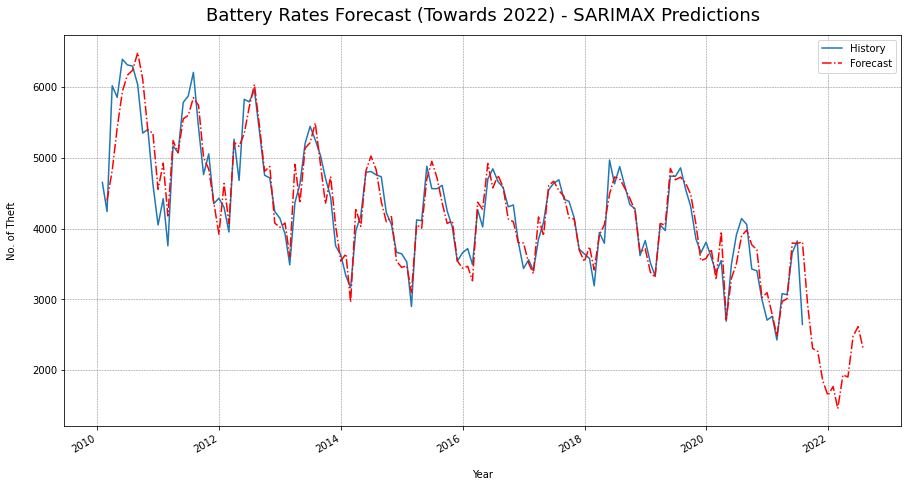

In [217]:
battery = battery_ori.copy()
battery_train = battery[:-12]
battery_fct = battery[-12:]

battery_fct_exog = battery_fct[['holiday', 'unemployment_rate', 'avg_temp']]
battery_train_exog = battery_train[['holiday', 'unemployment_rate', 'avg_temp']]

# Instantiate ARIMA model with best hyperparameters.
sarimax = SARIMAX(battery_train['primary_type'], exog=battery_train_exog, order=(1, 1, 1), seasonal_order=(1, 0, 1, 12))

# Fit ARIMA model.
model = sarimax.fit()

# Generate predictions based on train set.
sarimax_preds = model.predict(start=1, end=len(battery_train) + 11, exog=battery_fct_exog, typ='level')

# Plot data.
plt.figure(figsize=(15,8))

# Plot entire data
plt.plot(battery_train.index, pd.DataFrame(battery_train['primary_type']), label='History')

# Plot forecast data
sarimax_preds.plot(label='Forecast', color = 'red', linestyle='dashdot')

plt.title(label = 'Battery Rates Forecast (Towards 2022) - SARIMAX Predictions', fontsize=18, y =1.02)
plt.legend(loc='best')
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show();  

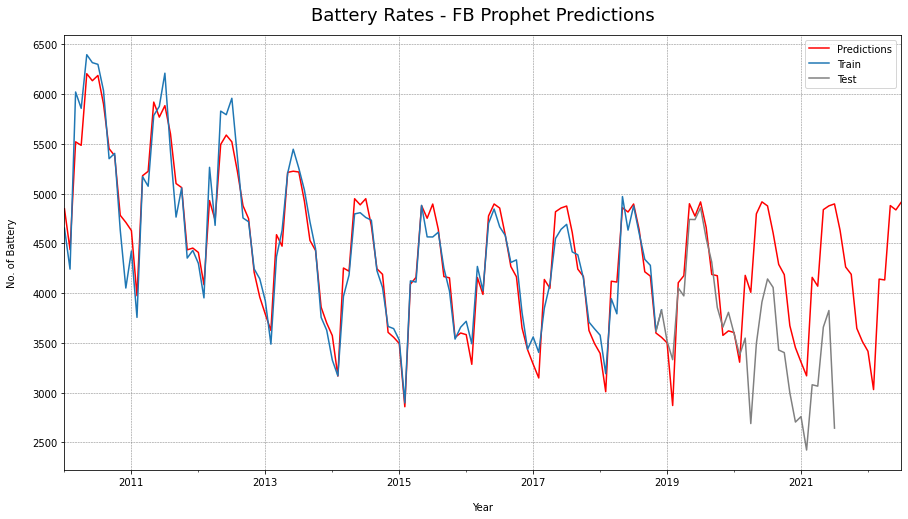

In [218]:
# Plot predicted values (train + test)
ax = forecast.plot(x='ds', y='yhat', label='Predictions', legend=True, color='red', figsize=(15,8))

# Plot training data.
prophet_train.plot(x='ds', y='y', label='Train', legend=True, ax=ax)

# Plot testing data.
prophet_test.plot(x='ds', y='y', label='Test', legend=True, color='grey', ax=ax)

plt.title(label = 'Battery Rates - FB Prophet Predictions', fontsize=18, y =1.02)
plt.legend(loc='best')
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Battery', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show();

# **Crime - Criminal Damage**

In [219]:
cridmg = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/capstone/assets/clean_data/2010_2021_cridmg_monthly.csv', index_col='date', parse_dates=True)

### Data Summary

In [220]:
cridmg.head()

primary_type  afternoon  evening  ...  45to54  65to74  75andmore
date                                          ...                           
2010-01-31          2788        757      929  ...  342384  151070     129473
2010-02-28          2444        562      814  ...  342384  151070     129473
2010-03-31          3751        902     1329  ...  342384  151070     129473
2010-04-30          3841        911     1356  ...  342384  151070     129473
2010-05-31          3800        880     1353  ...  342384  151070     129473

[5 rows x 192 columns]

In [221]:
# Criminal Damage information
cridmg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 151 entries, 2010-01-31 to 2022-07-31
Columns: 192 entries, primary_type to 75andmore
dtypes: float64(2), int64(190)
memory usage: 227.7 KB


In [222]:
cridmg_ori = cridmg.copy()

In [223]:
# Remove forecast dates (Require only when using SARIMAX)
cridmg = cridmg[:-12]

cridmg.index.freq = 'M'

## Understanding Criminal Damage Rates 

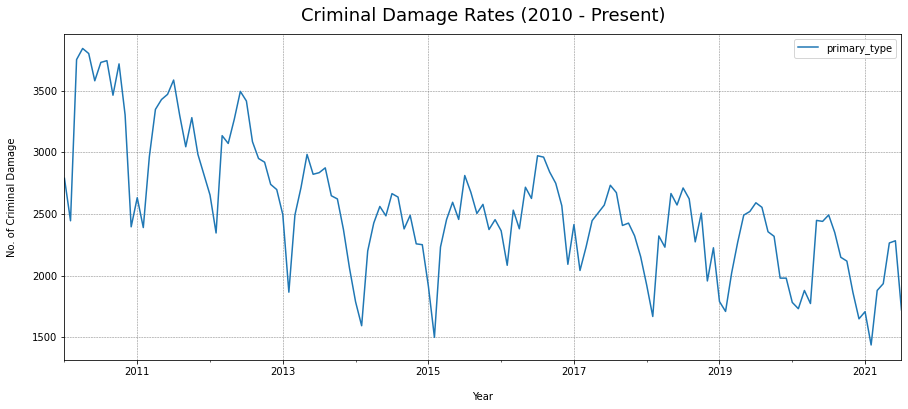

In [224]:
# Criminal Damage rates based on from 2010 - present
cridmg_rates = cridmg[['primary_type']]

# Plot crime rates from dataset
cridmg_rates.plot(figsize=(15,6))
plt.title('Criminal Damage Rates (2010 - Present)', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Criminal Damage', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

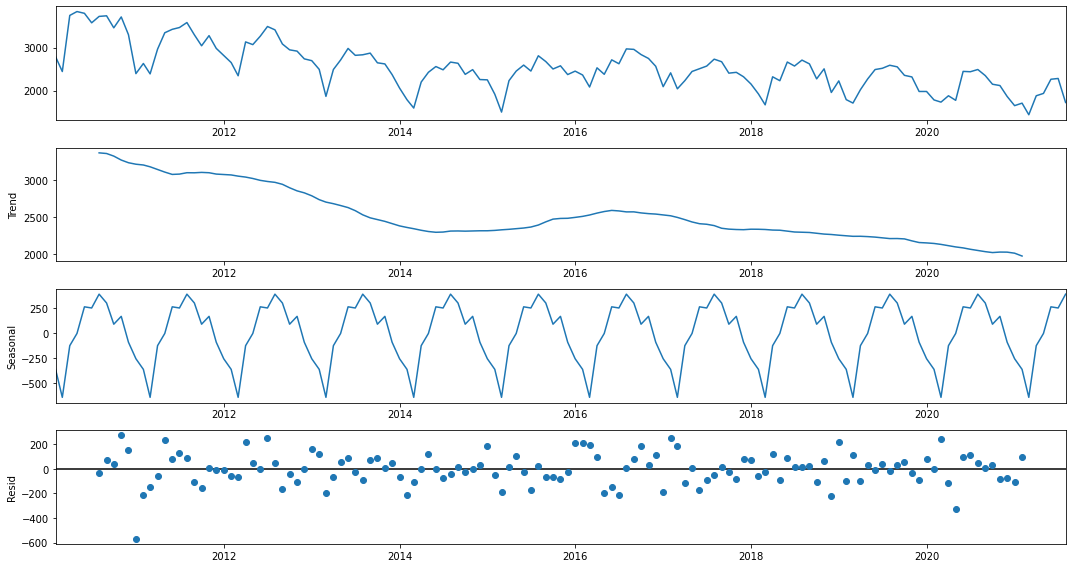

In [225]:
# ETS decomposition
rcParams['figure.figsize'] = 15,8
sm.tsa.seasonal_decompose(cridmg_rates).plot();

In [226]:
# Function for adfuller test
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print('')
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print('')
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [227]:
# Test for stationarity
adf_test(cridmg_rates)

Augmented Dickey-Fuller Test: 
ADF test statistic       -0.700205
p-value                   0.846696
# lags used              14.000000
# observations          124.000000
critical value (1%)      -3.484220
critical value (5%)      -2.885145
critical value (10%)     -2.579359

Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


### Differencing Data

In [228]:
cridmg_diff = cridmg_rates.copy()

In [229]:
# Assign both degree of diff() to columns 
cridmg_diff['first_diff_crime'] = cridmg_diff['primary_type'].diff()
cridmg_diff['second_diff_crime'] = cridmg_diff['primary_type'].diff().diff()

First Difference

In [230]:
# Stationary Test for first diff()
adf_test(cridmg_diff['first_diff_crime'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.544383
p-value                   0.105045
# lags used              14.000000
# observations          123.000000
critical value (1%)      -3.484667
critical value (5%)      -2.885340
critical value (10%)     -2.579463

Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


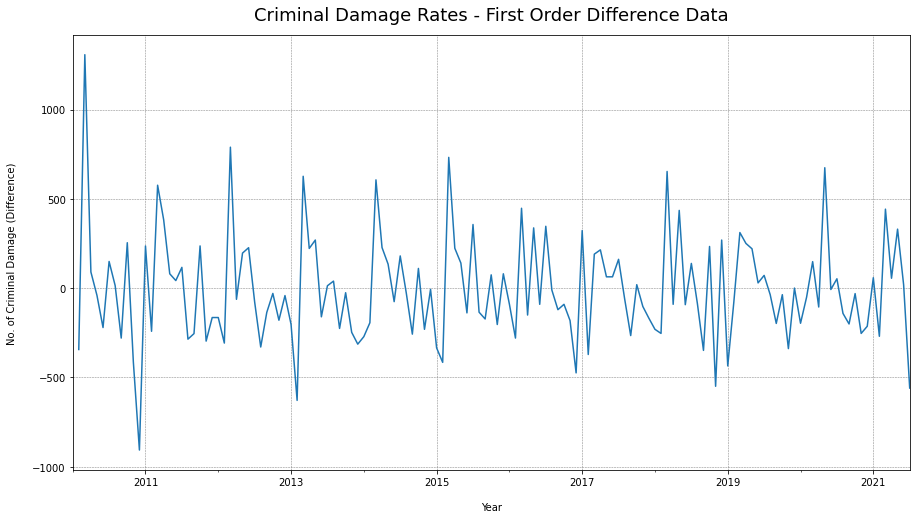

In [231]:
# Plot first diff()
cridmg_diff['first_diff_crime'].plot()
plt.title('Criminal Damage Rates - First Order Difference Data', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Criminal Damage (Difference)', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

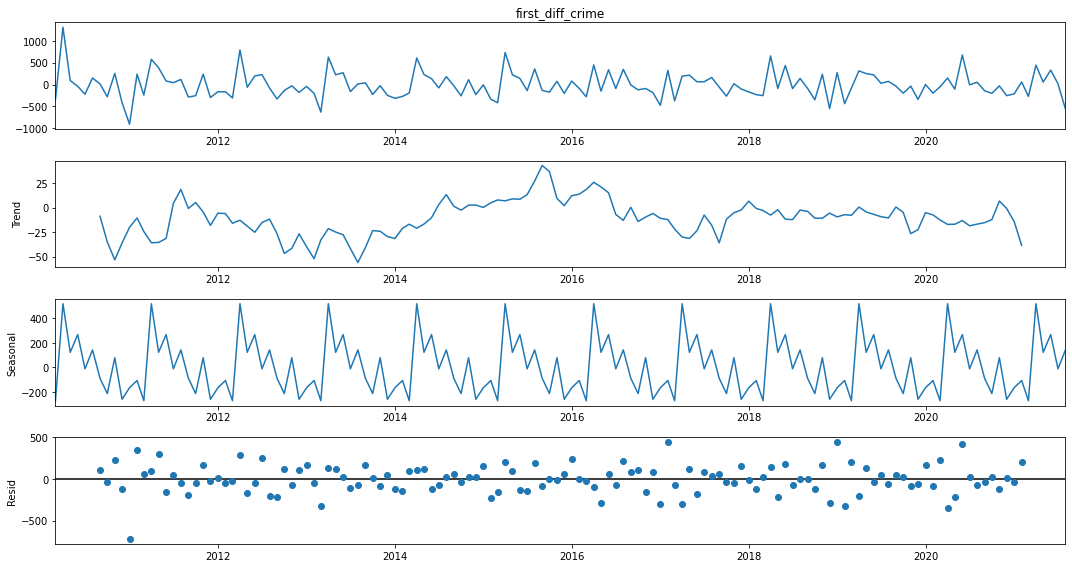

In [232]:
# Drop null values
first_diff = cridmg_diff['first_diff_crime']
first_diff.dropna(inplace=True)

# ETS decomposition - First Difference
rcParams['figure.figsize'] = 15,8
sm.tsa.seasonal_decompose(first_diff).plot();

Second Difference

In [233]:
# Stationary Test for second diff()
adf_test(cridmg_diff['second_diff_crime'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -8.904168e+00
p-value                 1.149796e-14
# lags used             1.300000e+01
# observations          1.230000e+02
critical value (1%)    -3.484667e+00
critical value (5%)    -2.885340e+00
critical value (10%)   -2.579463e+00

Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


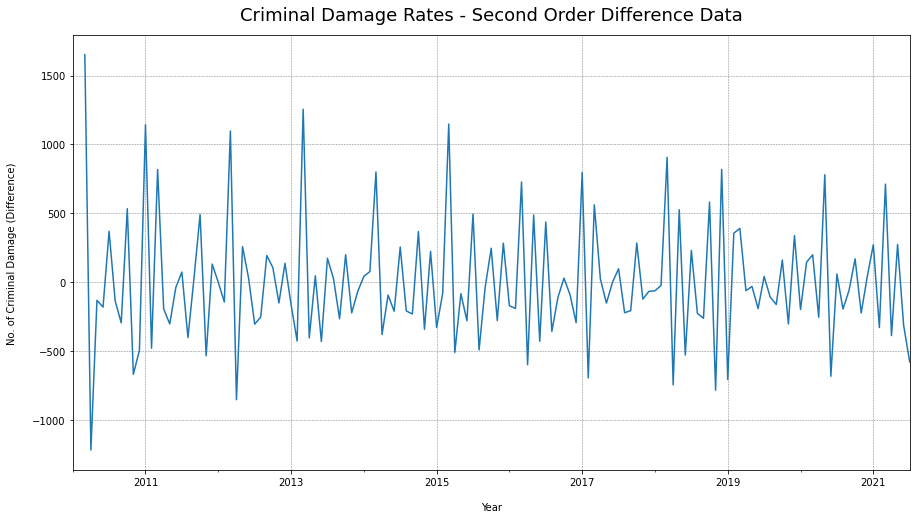

In [234]:
# Plot second diff()
cridmg_diff['second_diff_crime'].plot()
plt.title('Criminal Damage Rates - Second Order Difference Data', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Criminal Damage (Difference)', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

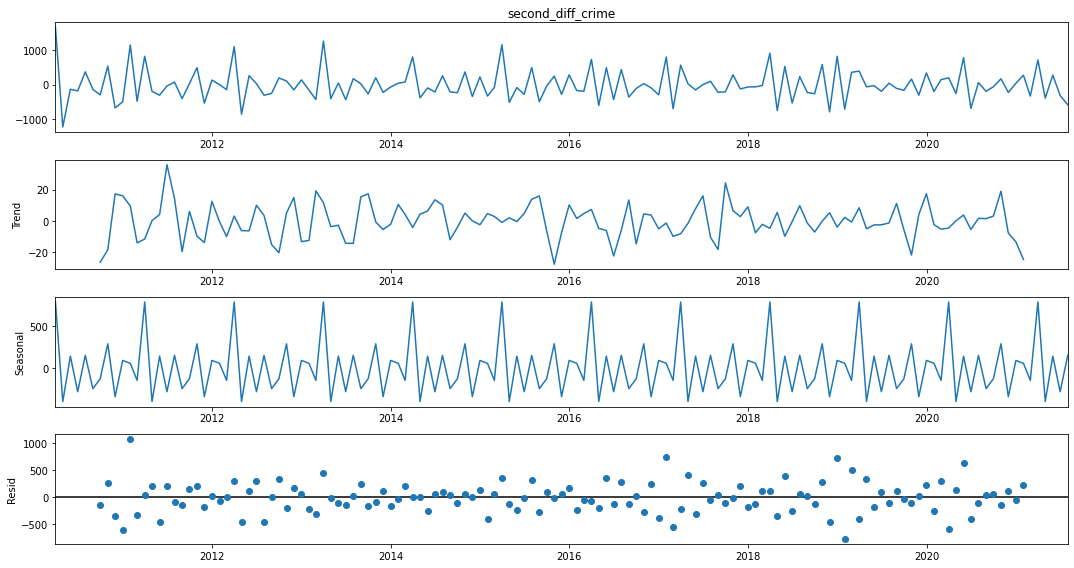

In [235]:
# Drop null values
second_diff = cridmg_diff['second_diff_crime']
second_diff.dropna(inplace=True)

# ETS decomposition - Second Difference
rcParams['figure.figsize'] = 15,8
sm.tsa.seasonal_decompose(second_diff).plot();

### Normality Test

In [236]:
# Function for Normality Test
def normaltest(df):
  stat, p = shapiro(df)
  print('stat=%.3f, p=%.3f\n' % (stat, p))

  if p > 0.05:
    print('Probably Gaussian')
  else:
    print('Probably not Gaussian')

# Ref: https://towardsdatascience.com/normality-tests-in-python-31e04aa4f411

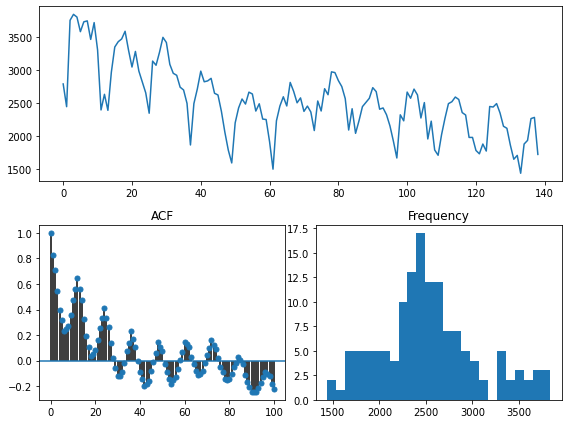

In [237]:
# Understanding the frequency of Criminal Damage
tsdisplay(cridmg_rates, lag_max=100)

In [238]:
# Normality Test on Theft (Original)
normaltest(cridmg_rates)

stat=0.971, p=0.004

Probably not Gaussian


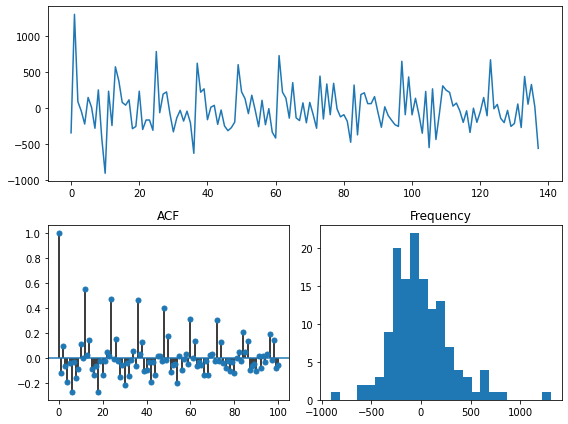

In [239]:
# Understanding the frequency of Criminal Damage with First Diff
tsdisplay(first_diff, lag_max=100)

In [240]:
# Normality Test on Theft (First Difference)
normaltest(first_diff)

stat=0.959, p=0.000

Probably not Gaussian


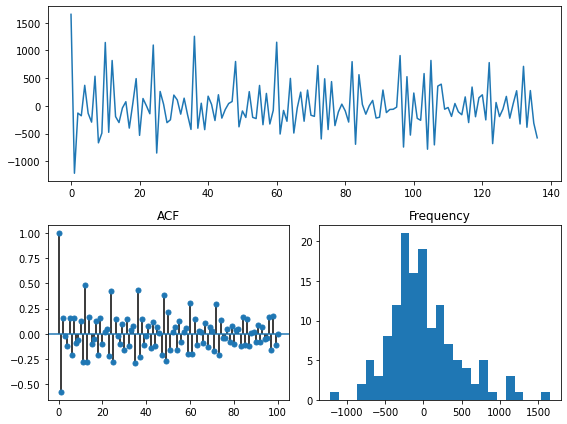

In [241]:
# Understanding the frequency of Criminal Damage with First Diff
tsdisplay(second_diff, lag_max=100)

In [242]:
# Normality Test on Theft (First Difference)
normaltest(second_diff)

stat=0.959, p=0.000

Probably not Gaussian


## **Time-Series Modelling**

### Train Test Split

In [243]:
# Train Test Split
train_cridmg = cridmg_rates[:'2019-01-01']
test_cridmg = cridmg_rates['2018-11-30':]

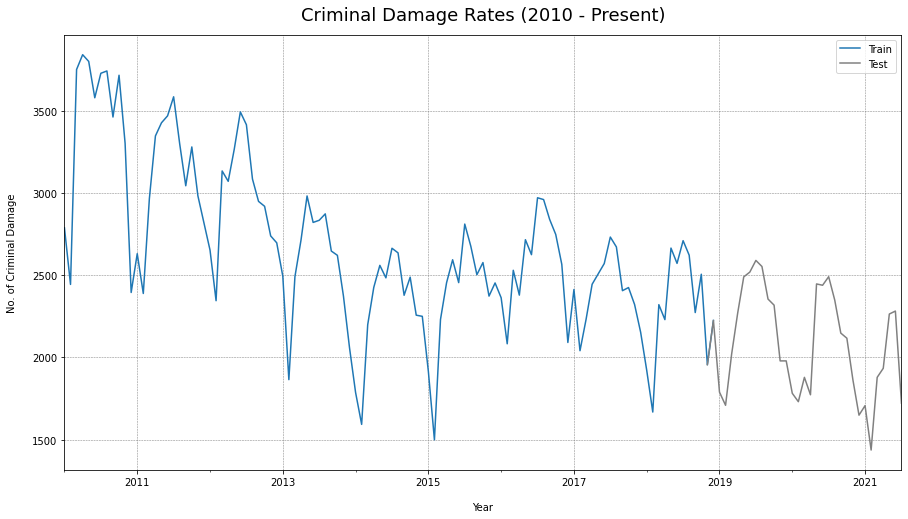

In [244]:
# Check the split
train_cridmg['primary_type'].plot(figsize=(15, 8), label='Train')
test_cridmg['primary_type'].plot(label='Test', color='grey')

plt.title('Criminal Damage Rates (2010 - Present)', fontsize=18, y=1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Criminal Damage', labelpad=15)
plt.legend(loc='best')
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show();

### ACF & PACF

<Figure size 1080x576 with 0 Axes>

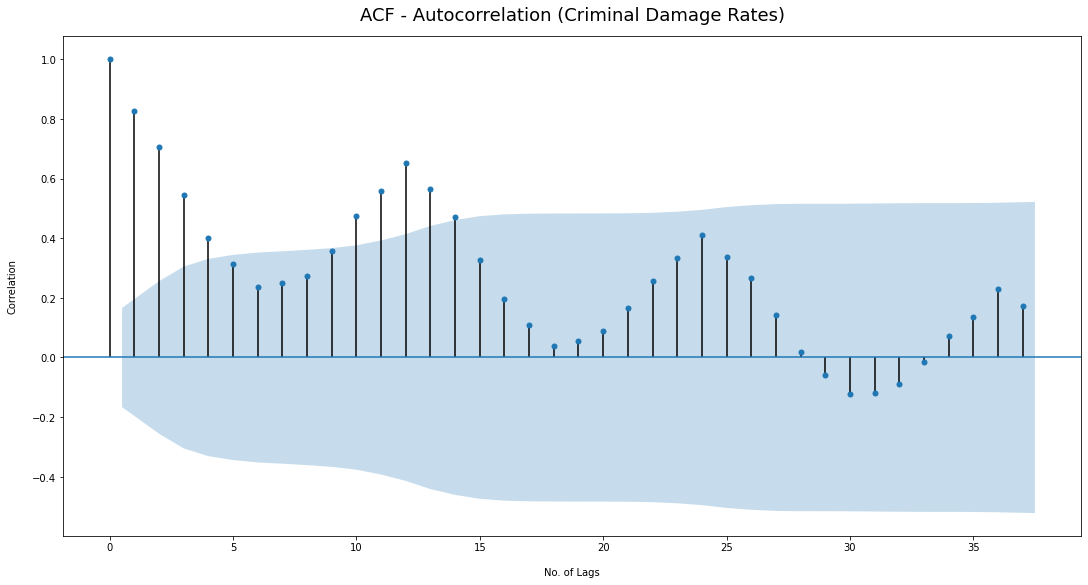

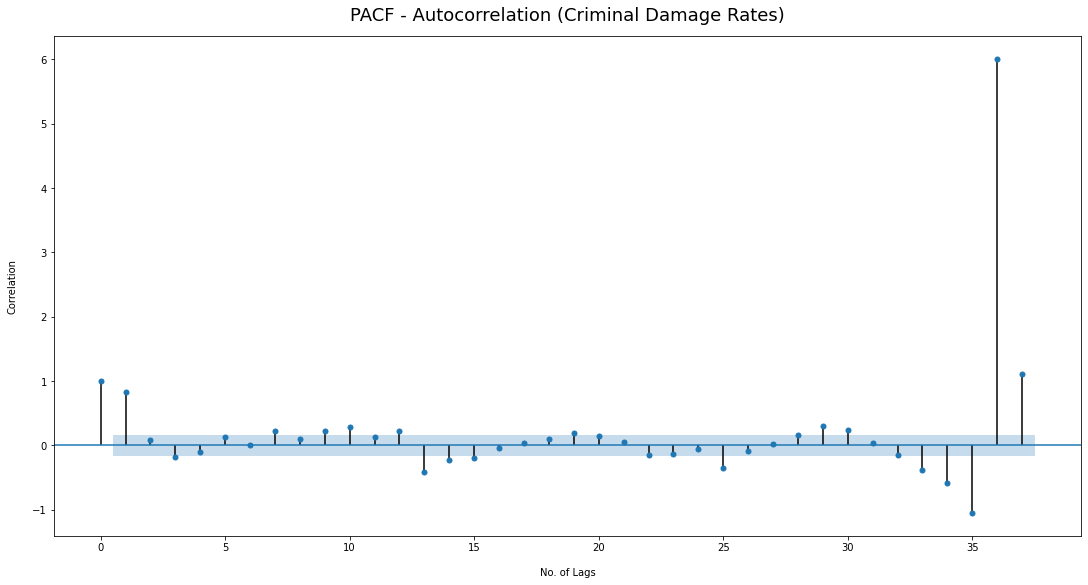

In [245]:
# Plot ACF & PACF for Criminal Damage
plt.figure(figsize=(15,8))
plot_acf(cridmg_rates['primary_type'], lags=37)

plt.title('ACF - Autocorrelation (Criminal Damage Rates)', fontsize=18, y=1.02)
plt.xlabel('No. of Lags', labelpad=15)
plt.ylabel('Correlation', labelpad=15)
plt.tight_layout(pad=0.3)

plot_pacf(cridmg_rates['primary_type'], lags=37)

plt.title('PACF - Autocorrelation (Criminal Damage Rates)', fontsize=18, y=1.02)
plt.xlabel('No. of Lags', labelpad=15)
plt.ylabel('Correlation', labelpad=15)
plt.tight_layout(pad=0.3);

<Figure size 1080x576 with 0 Axes>

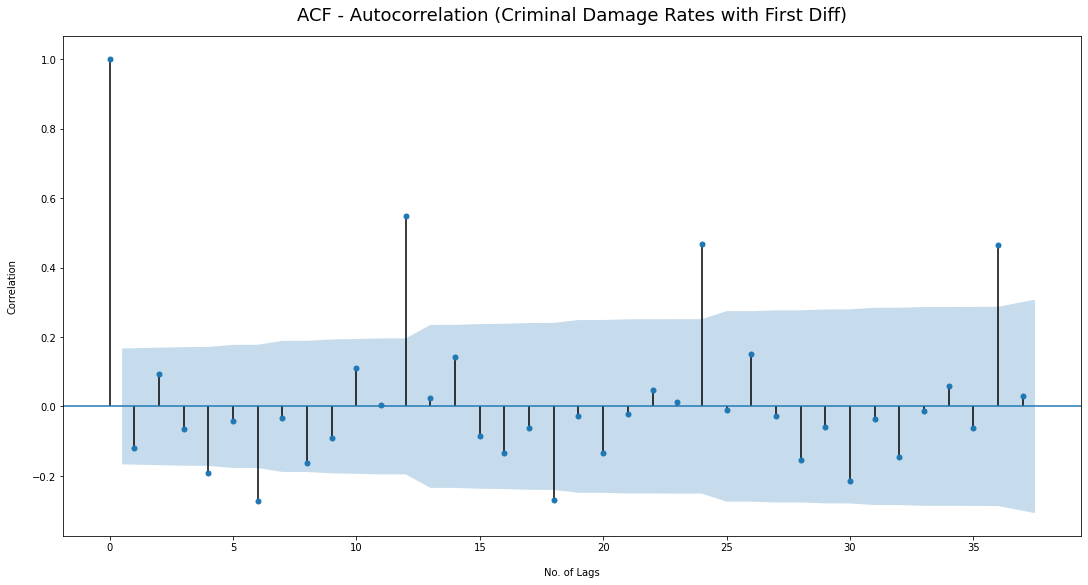

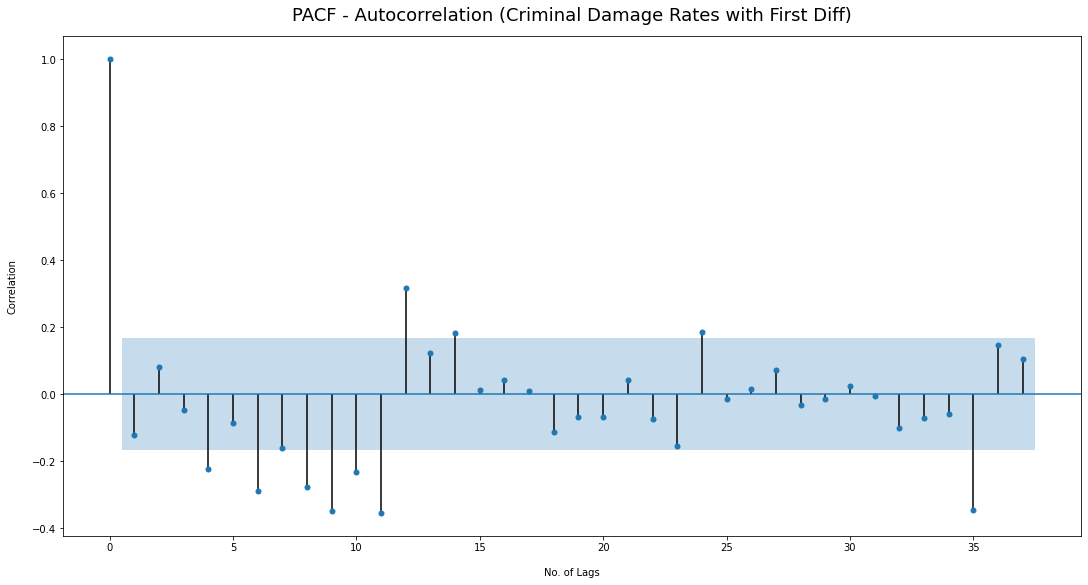

In [246]:
# Plot ACF & PACF Criminal Damage with First Diff
first_diff = pd.DataFrame(first_diff)

plt.figure(figsize=(15,8))
plot_acf(first_diff['first_diff_crime'], lags=37)

plt.title('ACF - Autocorrelation (Criminal Damage Rates with First Diff)', fontsize=18, y=1.02)
plt.xlabel('No. of Lags', labelpad=15)
plt.ylabel('Correlation', labelpad=15)
plt.tight_layout(pad=0.3)

plot_pacf(first_diff['first_diff_crime'], lags=37)

plt.title('PACF - Autocorrelation (Criminal Damage Rates with First Diff)', fontsize=18, y=1.02)
plt.xlabel('No. of Lags', labelpad=15) 
plt.ylabel('Correlation', labelpad=15)
plt.tight_layout(pad=0.3);

<Figure size 1080x576 with 0 Axes>

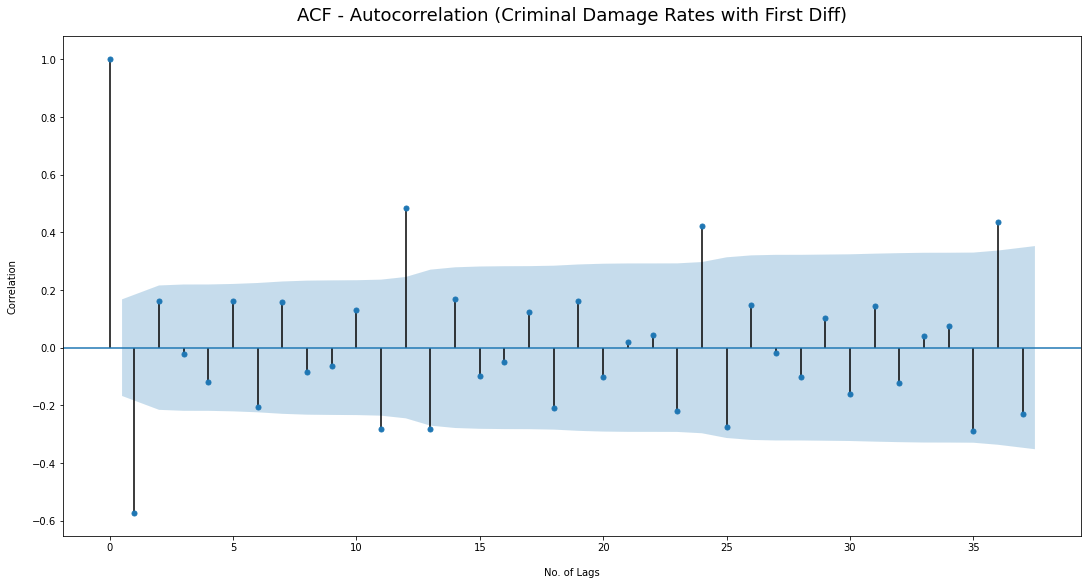

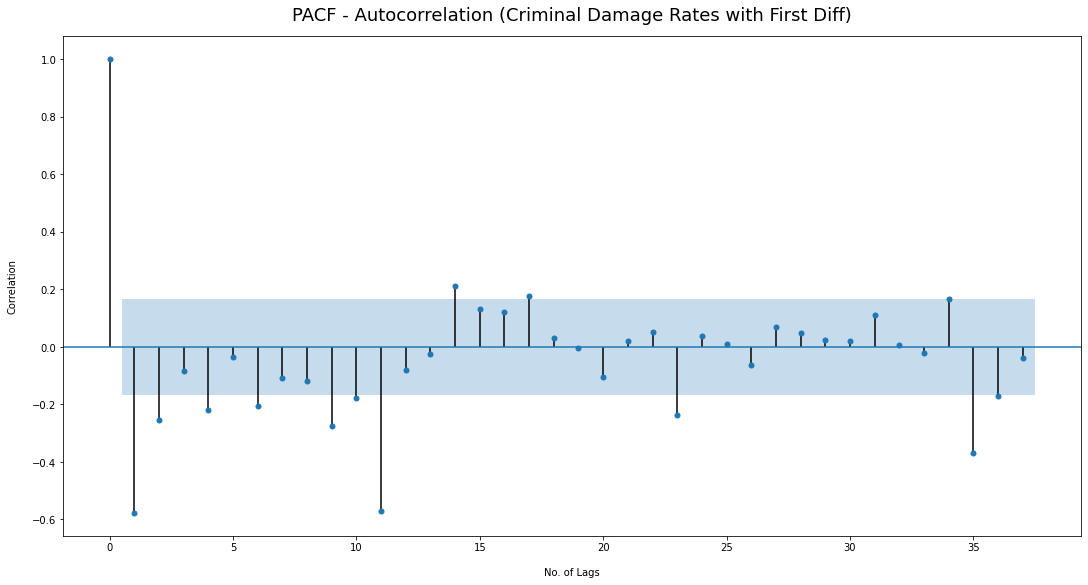

In [247]:
# Plot ACF & PACF Theft with Criminal Damage Diff
second_diff = pd.DataFrame(second_diff)

plt.figure(figsize=(15,8))
plot_acf(second_diff['second_diff_crime'], lags=37)

plt.title('ACF - Autocorrelation (Criminal Damage Rates with First Diff)', fontsize=18, y=1.02)
plt.xlabel('No. of Lags', labelpad=15)
plt.ylabel('Correlation', labelpad=15)
plt.tight_layout(pad=0.3)

plot_pacf(second_diff['second_diff_crime'], lags=37)

plt.title('PACF - Autocorrelation (Criminal Damage Rates with First Diff)', fontsize=18, y=1.02)
plt.xlabel('No. of Lags', labelpad=15) 
plt.ylabel('Correlation', labelpad=15)
plt.tight_layout(pad=0.3);

### Simple Exponential Smoothing

- Technique forecasts the next value using a weighted average of all previous values where the weights decay exponentially from the most recent to the oldest historical value.

In [248]:
# Ref: https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/

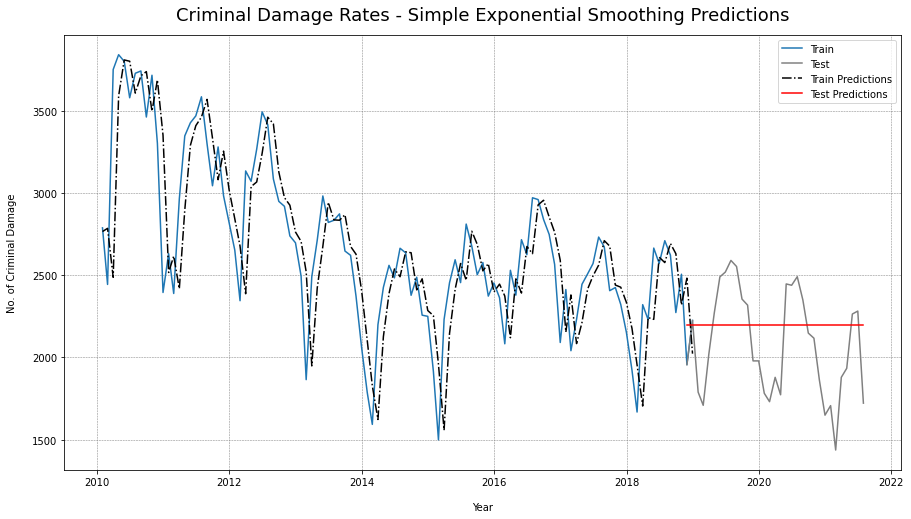

In [249]:
# Instantiate SES
ses = SimpleExpSmoothing(train_cridmg['primary_type'])

# Fit model
model = ses.fit()

# Determine len of predictions
start = len(train_cridmg)
end = len(train_cridmg) + len(test_cridmg) - 1

# Generate predictions based on train set.
ses_preds_train = model.predict(start=0, end=len(train_cridmg) - 1)

# Generate predictions based on test set.
ses_preds_test = model.predict(start=start, end=end)
                               
# Plot data.
plt.figure(figsize=(15,8))

# Plot training data.
plt.plot(train_cridmg.index, pd.DataFrame(train_cridmg['primary_type']), label='Train')

# Plot testing data.
plt.plot(test_cridmg.index, pd.DataFrame(test_cridmg['primary_type']), label='Test', color = 'grey')

# Plot predicted train values.
plt.plot(train_cridmg.index, ses_preds_train, label='Train Predictions', color = 'black', linestyle='dashdot')

# Plot predicted test values.
plt.plot(test_cridmg.index, ses_preds_test, label='Test Predictions', color = 'red')

plt.title(label = 'Criminal Damage Rates - Simple Exponential Smoothing Predictions', fontsize=18, y =1.02)
plt.legend(loc='best')
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Criminal Damage', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show();                             

In [250]:
print(model.summary())

                       SimpleExpSmoothing Model Results                       
Dep. Variable:           primary_type   No. Observations:                  108
Model:             SimpleExpSmoothing   SSE                       10475977.513
Optimized:                       True   AIC                           1244.106
Trend:                           None   BIC                           1249.470
Seasonal:                        None   AICC                          1244.494
Seasonal Periods:                None   Date:                 Thu, 09 Sep 2021
Box-Cox:                        False   Time:                         04:57:20
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.8726539                alpha                 True
initial_level              2765.5605                

In [251]:
# Evaluation
rms_ses = rmse(test_cridmg['primary_type'], ses_preds_test)
print (f'RMSE score: {rms_ses}')

mae_ses = mean_absolute_percentage_error(test_cridmg['primary_type'], ses_preds_test)
print (f'MAE score: {mae_ses}')

RMSE score: 333.4896033451689
MAE score: 0.15110449815875


### Holt Winters Exponential Smoothing

- Fixes one of the two shortcomings of the simple ES technique. Holt Winters ES can be used to forecast time series data that has a trend and seasonality


In [252]:
# Ref: https://towardsdatascience.com/holt-winters-exponential-smoothing-d703072c0572

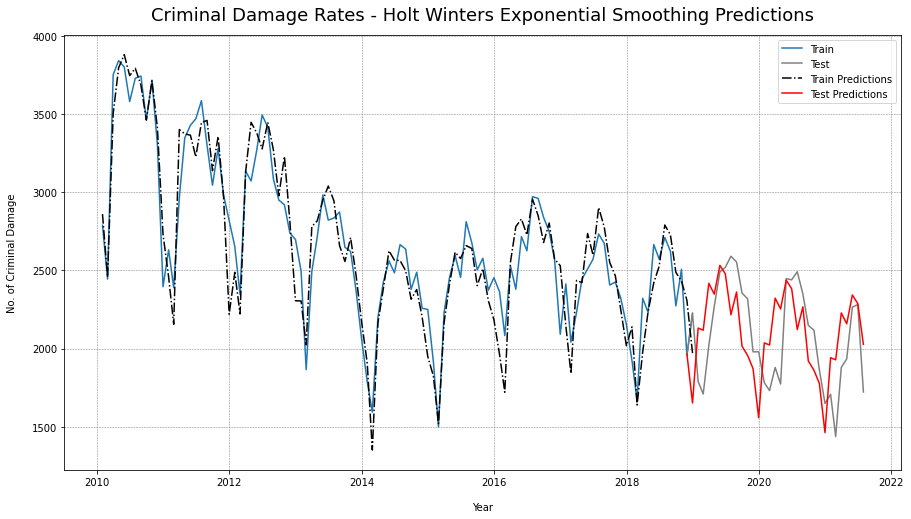

In [253]:
# Instantiate SES
hwes = ExponentialSmoothing(train_cridmg['primary_type'], seasonal_periods=12, trend='add', seasonal='add')

# Fit model
model = hwes.fit(optimized=True, use_brute=True)

# Determine len of predictions
start = len(train_cridmg)
end = len(train_cridmg) + len(test_cridmg) - 1

# Generate predictions based on train set.
hwes_preds_train = model.predict(start=0, end=len(train_cridmg) - 1)

# Generate predictions based on test set.
hwes_preds_test = model.predict(start=start, end=end)
                               
# Plot data.
plt.figure(figsize=(15,8))

# Plot training data.
plt.plot(train_cridmg.index, pd.DataFrame(train_cridmg['primary_type']), label='Train')

# Plot testing data.
plt.plot(test_cridmg.index, pd.DataFrame(test_cridmg['primary_type']), label='Test', color = 'grey')

# Plot predicted train values.
plt.plot(train_cridmg.index, hwes_preds_train, label='Train Predictions', color = 'black', linestyle='dashdot')

# Plot predicted test values.
plt.plot(test_cridmg.index, hwes_preds_test, label='Test Predictions', color = 'red')

plt.title(label = 'Criminal Damage Rates - Holt Winters Exponential Smoothing Predictions', fontsize=18, y =1.02)
plt.legend(loc='best')
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Criminal Damage', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show();                             

In [254]:
print(model.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:             primary_type   No. Observations:                  108
Model:             ExponentialSmoothing   SSE                        3684088.543
Optimized:                         True   AIC                           1159.239
Trend:                         Additive   BIC                           1202.154
Seasonal:                      Additive   AICC                          1166.925
Seasonal Periods:                    12   Date:                 Thu, 09 Sep 2021
Box-Cox:                          False   Time:                         04:57:21
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3153922                alpha                 True
smoothing_trend          

In [255]:
# Evaluation
rms_hwes = rmse(test_cridmg['primary_type'], hwes_preds_test)
print (f'RMSE score: {rms_hwes}')

mae_hwes = mean_absolute_percentage_error(test_cridmg['primary_type'], hwes_preds_test)
print (f'MAE score: {mae_hwes}')

RMSE score: 293.3644885657786
MAE score: 0.12583418241796285


### ARIMA (Auto Regressive Integrated Moving Average) 

- Technique forecasts the future value based on past values with parameter p (AR), d (I), q (MA)

In [256]:
# Finding the best values for p, d, q hyperparameters
arima = auto_arima(train_cridmg['primary_type'], 
                         start_p=0, start_q=0, 
                         max_d=2, 
                         seasonal=False, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1539.130, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1538.806, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1539.147, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1537.160, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1540.209, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.357 seconds


In [257]:
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  108
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -767.580
Date:                Thu, 09 Sep 2021   AIC                           1537.160
Time:                        04:57:21   BIC                           1539.833
Sample:                             0   HQIC                          1538.243
                                - 108                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      9.936e+04   9294.839     10.689      0.000    8.11e+04    1.18e+05
Ljung-Box (L1) (Q):                   2.12   Jarque-Bera (JB):                35.81
Prob(Q):                              0.15   Pr

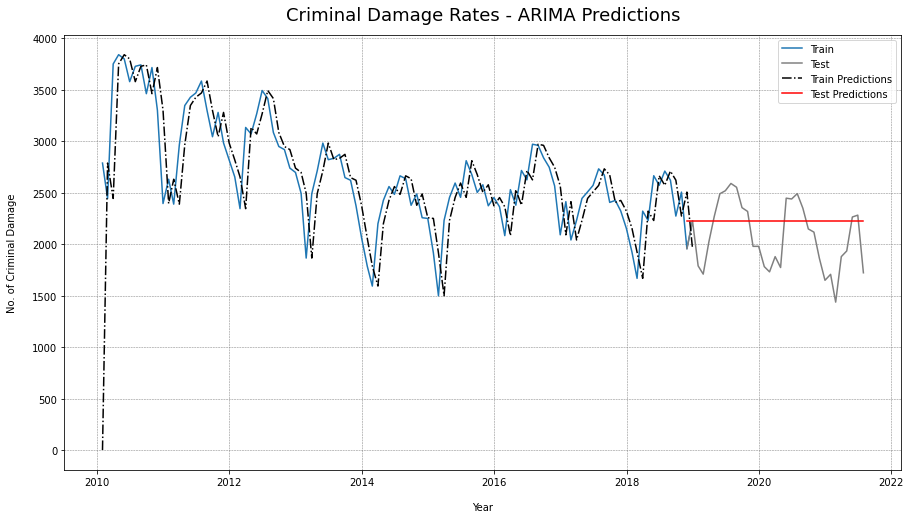

In [258]:
# Instantiate ARIMA model with best hyperparameters.
arima = ARIMA(train_cridmg['primary_type'], order=(0, 1, 0))

# Fit ARIMA model.
model = arima.fit()

# Determine len of predictions
start = len(train_cridmg)
end = len(train_cridmg) + len(test_cridmg) - 1

# Generate predictions based on train set.
arima_preds_train = model.predict(end=len(train_cridmg) - 1, typ='level')

# Generate predictions based on test set.
arima_preds_test = model.predict(start=start, end=end, typ='level')

# Plot data
plt.figure(figsize=(15,8))

# Plot training data.
plt.plot(train_cridmg.index, pd.DataFrame(train_cridmg['primary_type']), label='Train')

# Plot testing data.
plt.plot(test_cridmg.index, pd.DataFrame(test_cridmg['primary_type']), label='Test', color = 'grey')

# Plot predicted train values.
plt.plot(train_cridmg.index, arima_preds_train, label='Train Predictions', color = 'black', linestyle='dashdot')

# Plot predicted test values.
plt.plot(test_cridmg.index, arima_preds_test, label='Test Predictions', color = 'red')

plt.title(label = 'Criminal Damage Rates - ARIMA Predictions', fontsize=18, y =1.02)
plt.legend(loc='best')
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Criminal Damage', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show();

In [259]:
# Evaluation
rms_arima = rmse(test_cridmg['primary_type'], arima_preds_test)
print (f'RMSE score: {rms_arima}')

mae_arima = mean_absolute_percentage_error(test_cridmg['primary_type'], arima_preds_test)
print (f'MAE score: {mae_arima}')

RMSE score: 343.51957290625666
MAE score: 0.15464407742932423


### SARIMA (Seasonal Autoregressive Integrated Moving Average)

- Similar to ARIMA, a technique forecasts the future value based on past values with a seasonal component

In [260]:
# Finding the best values for p, d, q hyperparameters
sarima = auto_arima(train_cridmg['primary_type'], 
                         start_p=0, start_q=0, start_P=0, start_Q=0,
                         max_d=2, m=12,
                         seasonal=True, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1539.130, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1475.017, Time=0.35 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1503.196, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1537.160, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1538.806, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1471.630, Time=0.85 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=1464.317, Time=1.45 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1462.418, Time=0.73 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1503.327, Time=0.25 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=1464.183, Time=1.75 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=1496.543, Time=0.59 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=2.34 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1467.233, Time=0.49 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=1459.623, Time=1.03 sec
 ARIMA(2,1,0)(0,0,1)[12]

In [261]:
print(sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(0, 1, 2)x(1, 0, 2, 12)   Log Likelihood                -720.050
Date:                            Thu, 09 Sep 2021   AIC                           1454.101
Time:                                    04:58:21   BIC                           1472.811
Sample:                                         0   HQIC                          1461.686
                                            - 108                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1540      0.432     -0.357      0.721      -1.001       0.693
ma.L1         -0.4315      0.106   

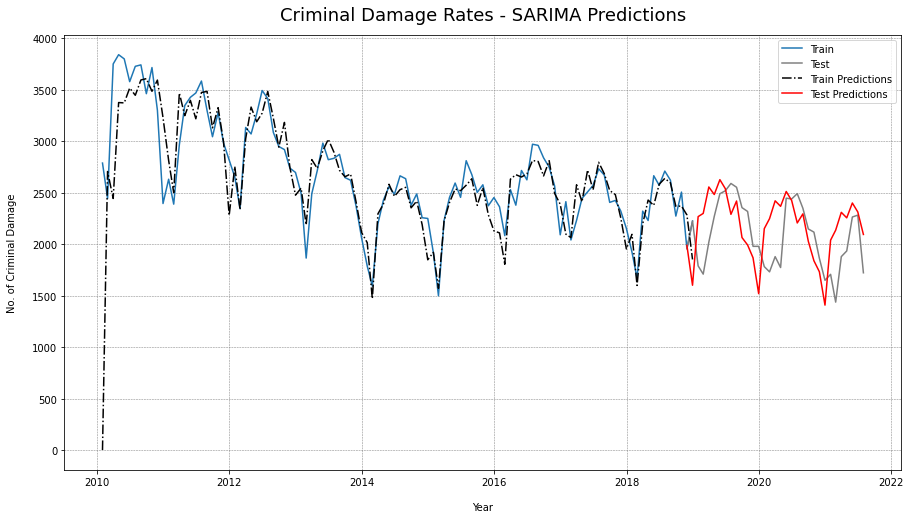

In [262]:
# Instantiate ARIMA model with best hyperparameters.
sarima = SARIMAX(train_cridmg['primary_type'], order=(0, 1, 2), seasonal_order=(1, 0, 2, 12))

# Fit ARIMA model.
model = sarima.fit()

# Determine len of predictions
start = len(train_cridmg)
end = len(train_cridmg) + len(test_cridmg) - 1

# Generate predictions based on train set.
sarima_preds_train = model.predict(end=len(train_cridmg) - 1, typ='level')

# Generate predictions based on test set.
sarima_preds_test = model.predict(start=start, end=end, typ='level')

# Plot data
plt.figure(figsize=(15,8))

# Plot training data.
plt.plot(train_cridmg.index, pd.DataFrame(train_cridmg['primary_type']), label='Train')

# Plot testing data.
plt.plot(test_cridmg.index, pd.DataFrame(test_cridmg['primary_type']), label='Test', color = 'grey')

# Plot predicted train values.
plt.plot(train_cridmg.index, sarima_preds_train, label='Train Predictions', color = 'black', linestyle='dashdot')

# Plot predicted test values.
plt.plot(test_cridmg.index, sarima_preds_test, label='Test Predictions', color = 'red')

plt.title(label = 'Criminal Damage Rates - SARIMA Predictions', fontsize=18, y =1.02)
plt.legend(loc='best')
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Criminal Damage', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show();

In [263]:
# Evaluation
rms_sarima = rmse(test_cridmg['primary_type'], sarima_preds_test)
print (f'RMSE score: {rms_sarima}')

mae_sarima = mean_absolute_percentage_error(test_cridmg['primary_type'], sarima_preds_test)
print (f'MAE score: {mae_sarima}')

RMSE score: 356.5236965229363
MAE score: 0.15522571152594056


### Facebook Prophet

In [264]:
# Prophet models requires data details to follow their format
prophet_train = train_cridmg.copy()
prophet_test = test_cridmg.copy()

# Date as part of features 
prophet_train = prophet_train.reset_index()
prophet_test = prophet_test.reset_index()

# Convert column names
prophet_train.columns = ['ds', 'y']
prophet_test.columns = ['ds', 'y']

In [265]:
# Instantiate prophet
m = Prophet()

# Fit model
m.fit(prophet_train)

# Create future periods (based on date in date - periods are based on test_data)
future = m.make_future_dataframe(periods=43, freq='M')

# Generate predictions based on data
forecast = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


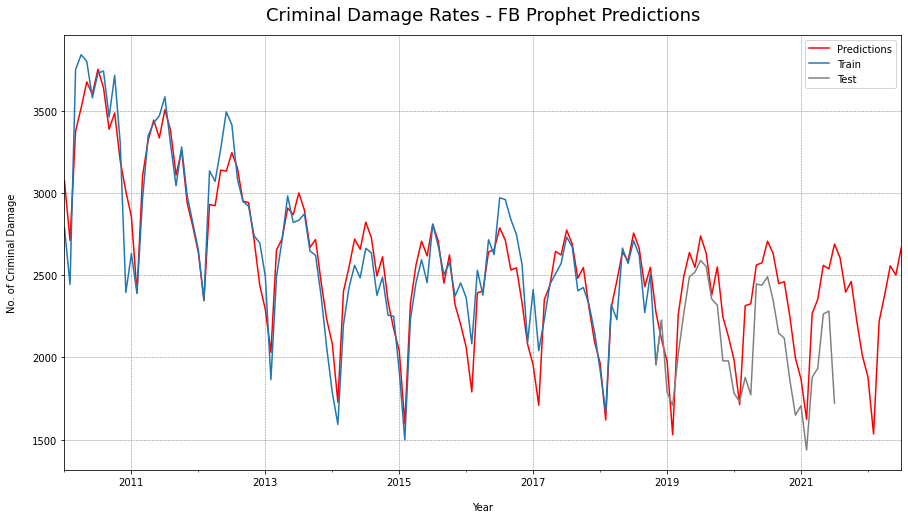

In [266]:
# Plot predicted values (train + test)
ax = forecast.plot(x='ds', y='yhat', label='Predictions', legend=True, color='red', figsize=(15,8))

# Plot training data.
prophet_train.plot(x='ds', y='y', label='Train', legend=True, ax=ax)

# Plot testing data.
prophet_test.plot(x='ds', y='y', label='Test', legend=True, color='grey', ax=ax)

plt.title(label = 'Criminal Damage Rates - FB Prophet Predictions', fontsize=18, y =1.02)
plt.legend(loc='best')
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Criminal Damage', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show();

In [267]:
prophet_preds = forecast.iloc[-33:]['yhat']

In [268]:
# Evaluation
rms_prophet = rmse(prophet_test['y'], prophet_preds)
print (f'RMSE score: {rms_prophet}')

mae_prophet = mean_absolute_percentage_error(prophet_test['y'], prophet_preds)
print (f'MAE score: {mae_prophet}')

RMSE score: 292.2742999498373
MAE score: 0.11572029746010093


### Recurrent Neural Network

In [269]:
train_rnn = train_cridmg[['primary_type']]
test_rnn = test_cridmg[['primary_type']]

In [270]:
from sklearn.preprocessing import MinMaxScaler

# Instantiate MinMaxScaler
scaler = MinMaxScaler()

# Fit scaler
scaler.fit(train_rnn)

MinMaxScaler()

In [271]:
# Scaled data
Z_train = scaler.transform(train_rnn)
Z_test = scaler.transform(test_rnn)

Model

In [272]:
n_input = 12
n_features = 1
train_generator = TimeseriesGenerator(Z_train, Z_train, length=n_input, batch_size=1)

In [273]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='bce', metrics=['acc'])
es = EarlyStopping(patience = 5)

In [274]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 404       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 41,209
Trainable params: 41,209
Non-trainable params: 0
_________________________________________________________________
None


In [275]:
# Fit model
model.fit_generator(train_generator, epochs=25, callbacks = [es])

Epoch 1/25
96/96 [==============================] - 2s 7ms/step - loss: 0.6928 - acc: 0.0104


Epoch 2/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6922 - acc: 0.0104


Epoch 3/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6917 - acc: 0.0104


Epoch 4/25
96/96 [==============================] - 1s 6ms/step - loss: 0.6914 - acc: 0.0104


Epoch 5/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6911 - acc: 0.0104


Epoch 6/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6908 - acc: 0.0104


Epoch 7/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6906 - acc: 0.0104


Epoch 8/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6906 - acc: 0.0104


Epoch 9/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6904 - acc: 0.0104


Epoch 10/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6904 - acc: 0.0104


Epoch 11/25
96/96 [==============================] - 1s 6ms/step - loss: 0.6903 - acc: 0.0104


Epoch 12/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6902 - acc: 0.0104


Epoch 13/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6902 - acc: 0.0104


Epoch 14/25
96/96 [==============================] - 1s 6ms/step - loss: 0.6902 - acc: 0.0104


Epoch 15/25
96/96 [==============================] - 1s 6ms/step - loss: 0.6902 - acc: 0.0104


Epoch 16/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6902 - acc: 0.0104


Epoch 17/25
96/96 [==============================] - 1s 6ms/step - loss: 0.6902 - acc: 0.0104


Epoch 18/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6901 - acc: 0.0104


Epoch 19/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6902 - acc: 0.0104


Epoch 20/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6901 - acc: 0.0104


Epoch 21/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6902 - acc: 0.0104


Epoch 22/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6902 - acc: 0.0104


Epoch 23/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6901 - acc: 0.0104


Epoch 24/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6901 - acc: 0.0104


Epoch 25/25
96/96 [==============================] - 1s 7ms/step - loss: 0.6901 - acc: 0.0104


In [276]:
model.history.history.keys

<function dict.keys>

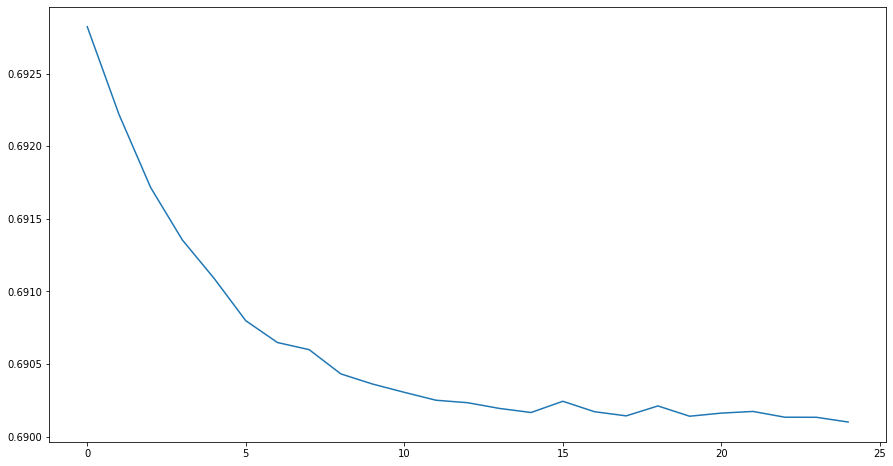

In [277]:
# Understand loss
myloss = model.history.history['loss']

plt.plot(range(len(myloss)), myloss)

In [278]:
# 12 history steps ---> step 13
# last 12 points train ---> pt 1 of test data

In [279]:
first_eval_batch = Z_train[-12:]

In [280]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

Forecast

In [281]:
# Holding predictions
test_predictions = []

#last n_input points from the training set
first_eval_batch = Z_train[-n_input:]

# Reshape this to the format RNN wants (same as TimeseriesGenerator)
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [282]:
# How far into the future will be forecasted
# len(test)
for i in range(len(test_cridmg)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [283]:
true_predictions = scaler.inverse_transform(test_predictions)

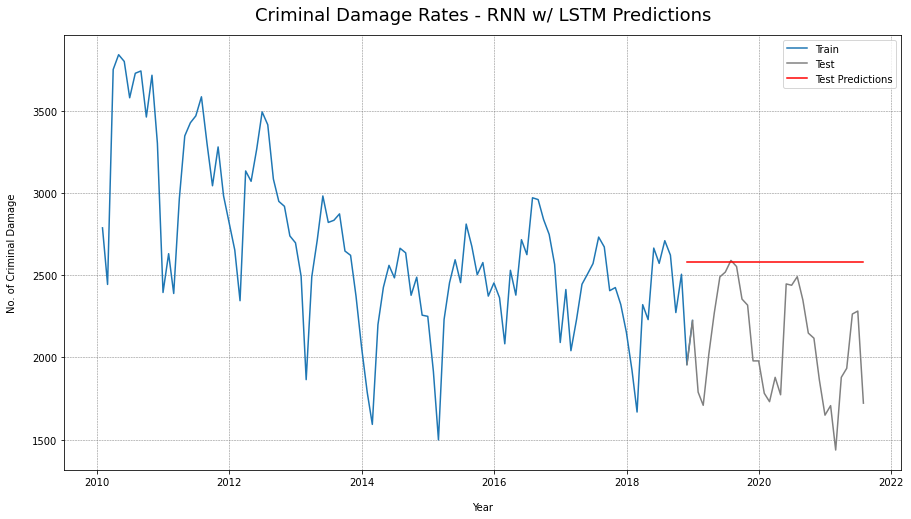

In [284]:
# Plot data
plt.figure(figsize=(15,8))

# Plot training data.
plt.plot(train_cridmg.index, pd.DataFrame(train_cridmg['primary_type']), label='Train')

# Plot testing data.
plt.plot(test_cridmg.index, pd.DataFrame(test_cridmg['primary_type']), label='Test', color = 'grey')

# Plot predicted test values.
plt.plot(test_cridmg.index, true_predictions, label='Test Predictions', color = 'red')

plt.title(label = 'Criminal Damage Rates - RNN w/ LSTM Predictions', fontsize=18, y =1.02)
plt.legend(loc='best')
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Criminal Damage', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show();

In [285]:
test_cridmg['rnn_predictions'] = true_predictions

In [286]:
# Evaluation
rms_rnn = rmse(test_cridmg['primary_type'], test_cridmg['rnn_predictions'])
print (f'RMSE score: {rms_rnn}')

mae_rnn = mean_absolute_percentage_error(test_cridmg['primary_type'], test_cridmg['rnn_predictions'])
print (f'MAE score: {mae_rnn}')

RMSE score: 589.3382778296192
MAE score: 0.26988388869329893


### SARIMAX (Seasonal Autoregressive Integrated Moving Average with Exogenous Variable)
Further look explore the model with exogenous variable to see the impact of external factors
- Requirement: Exog features are available values from past, present and into the future

In [287]:
# Loading original data
cridmg_rates_fc = cridmg_ori.copy()

# Filter data with exog variables
cridmg_rates_fc = cridmg_rates_fc[['primary_type', 'holiday', 'isweekend', 'unemployment_rate', 'avg_temp']]

In [288]:
cridmg_rates_fc.tail()

primary_type  holiday  isweekend  unemployment_rate  avg_temp
date                                                                     
2022-03-31             0        0         12               10.7       0.1
2022-04-30             0        0         14               10.7       0.1
2022-05-31             0        1         13               10.7       0.1
2022-06-30             0        0         12               10.7       0.1
2022-07-31             0        1         15               10.7       0.1

In [289]:
# Train Test Split
train_cridmg = cridmg_rates_fc[:'2019-01-01']
test_cridmg = cridmg_rates_fc['2018-11-30':'2021-07-31']
fc_cridmg = cridmg_rates_fc['2021-06-30':]

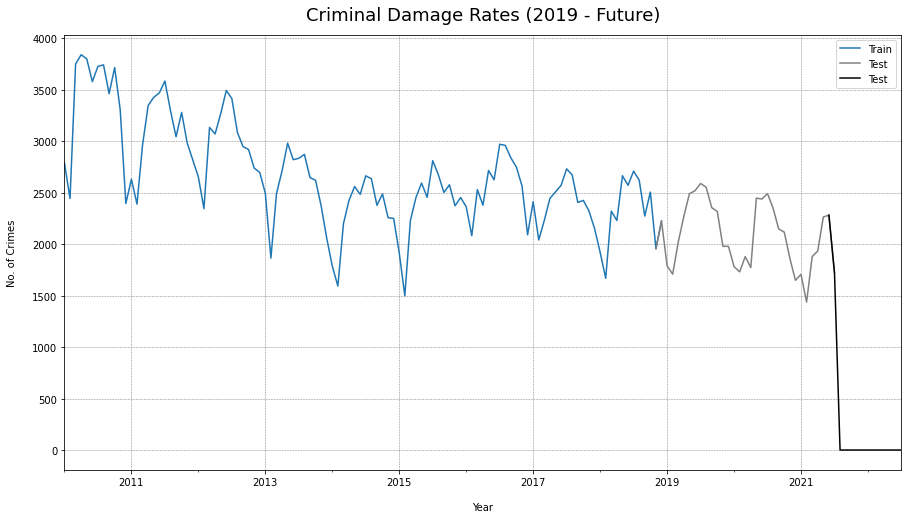

In [290]:
# Check the split
train_cridmg['primary_type'].plot(figsize=(15, 8), label='Train')
test_cridmg['primary_type'].plot(label='Test', color='grey')
fc_cridmg['primary_type'].plot(label='Test', color='black')

plt.title('Criminal Damage Rates (2019 - Future)', fontsize=18, y=1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Crimes', labelpad=15)
plt.legend(loc='best')
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show();

In [291]:
# Assign exogenous variable
train_exog =  train_cridmg[['holiday', 'unemployment_rate', 'avg_temp']]
test_exog =  test_cridmg[['holiday', 'unemployment_rate', 'avg_temp']]
fc_exog =  fc_cridmg[['holiday', 'unemployment_rate', 'avg_temp']]

In [292]:
# Finding the best values for p, d, q hyperparameters
sarimax = auto_arima(train_cridmg['primary_type'], exog=train_exog,
                         start_p=0, start_q=0, start_P=0, start_Q=0,
                         d=1, m=12,
                         seasonal=True, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1539.130, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1475.017, Time=0.64 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1503.196, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1537.160, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1538.806, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1471.630, Time=0.92 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=1464.317, Time=1.50 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1462.418, Time=0.75 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1503.327, Time=0.27 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=1464.183, Time=1.81 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=1496.543, Time=0.71 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=2.39 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1467.233, Time=0.53 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=1459.623, Time=1.07 sec
 ARIMA(2,1,0)(0,0,1)[12]

In [293]:
print(sarimax.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(0, 1, 2)x(1, 0, 2, 12)   Log Likelihood                -720.050
Date:                            Thu, 09 Sep 2021   AIC                           1454.101
Time:                                    04:59:57   BIC                           1472.811
Sample:                                         0   HQIC                          1461.686
                                            - 108                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1540      0.432     -0.357      0.721      -1.001       0.693
ma.L1         -0.4315      0.106   

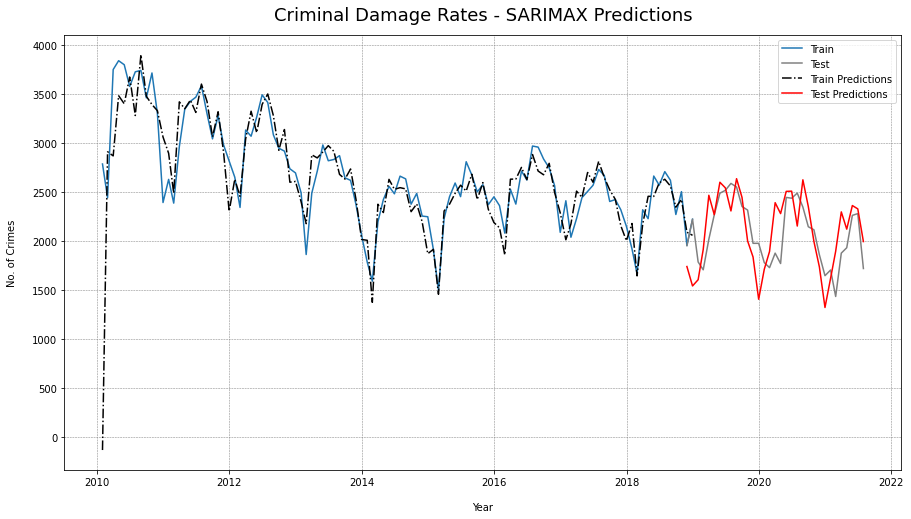

In [294]:
# Instantiate ARIMA model with best hyperparameters.
sarimax = SARIMAX(train_cridmg['primary_type'], exog=train_exog, order=(0, 1, 2), seasonal_order=(1, 0, 2, 12))

# Fit ARIMA model.
model = sarimax.fit()

# Determine len of predictions
start = len(train_cridmg)
end = len(train_cridmg) + len(test_cridmg) - 1

# Generate predictions based on train set.
sarimax_preds_train = model.predict(end=len(train_cridmg) - 1, exog=train_exog, typ='level')

# Generate predictions based on test set.
sarimax_preds_test = model.predict(start=start, end=end, exog=test_exog, typ='level')

# Plot data
plt.figure(figsize=(15,8))

# Plot training data.
plt.plot(train_cridmg.index, pd.DataFrame(train_cridmg['primary_type']), label='Train')

# Plot testing data.
plt.plot(test_cridmg.index, pd.DataFrame(test_cridmg['primary_type']), label='Test', color = 'grey')

# Plot predicted train values.
plt.plot(train_cridmg.index, sarimax_preds_train, label='Train Predictions', color = 'black', linestyle='dashdot')

# Plot predicted test values.
plt.plot(test_cridmg.index, sarimax_preds_test, label='Test Predictions', color = 'red')

plt.title(label = 'Criminal Damage Rates - SARIMAX Predictions', fontsize=18, y =1.02)
plt.legend(loc='best')
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Crimes', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show();

In [295]:
# Evaluation
rms_sarimax = rmse(test_cridmg['primary_type'], sarimax_preds_test)
print (f'RMSE score: {rms_sarimax}')

mae_sarimax = mean_absolute_percentage_error(test_cridmg['primary_type'], sarimax_preds_test)
print (f'MAE score: {mae_sarimax}')

RMSE score: 290.74088577983855
MAE score: 0.11893376700129941


### ***Based on time-series model:***

|Model|RMSE|MAE|
|---|---|---|
|Holt Winters ES|293.3644885657786|0.12583418241796285|
|SARIMA|356.5236965229363|0.15522571152594056|
|Prophet|292.2742999498373|0.11572029746010093|
|SARIMAX|290.74088577983855|0.11893376700129941|

## **Evaluation**
- Similar to battery crimes, criminal dmg is does not seem to be affected by the pandemic crisis
- SARIMAX and FB Prophet almost similar to each other with error of 11% 

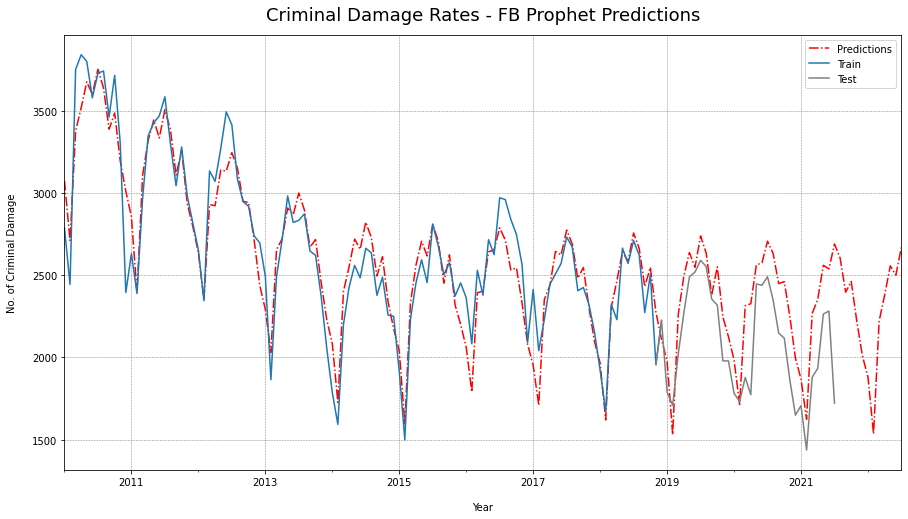

In [300]:
# Plot predicted values (train + test)
ax = forecast.plot(x='ds', y='yhat', label='Predictions', legend=True, color='red', linestyle='dashdot', figsize=(15,8))

# Plot training data.
prophet_train.plot(x='ds', y='y', label='Train', legend=True, ax=ax)

# Plot testing data.
prophet_test.plot(x='ds', y='y', label='Test', legend=True, color='grey', ax=ax)

plt.title(label = 'Criminal Damage Rates - FB Prophet Predictions', fontsize=18, y =1.02)
plt.legend(loc='best')
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Criminal Damage', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show();

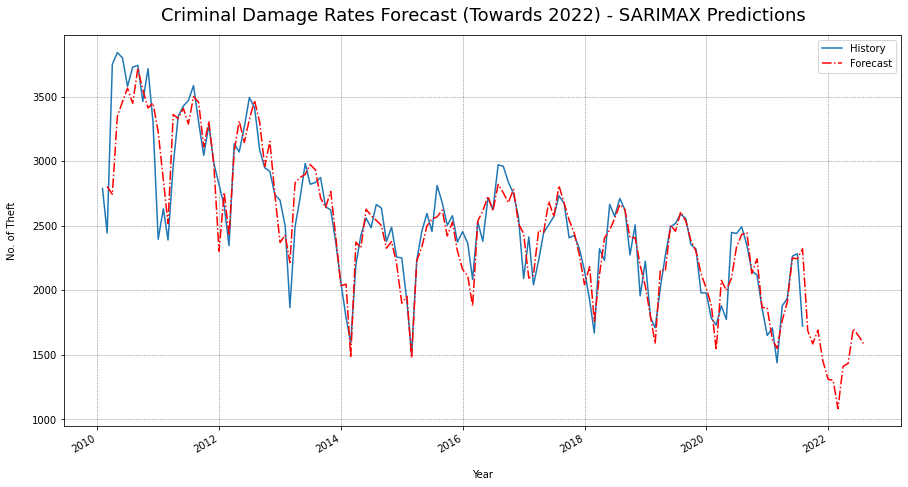

In [299]:
cridmg = cridmg_ori.copy()
cridmg_train = cridmg[:-12]
cridmg_fct = cridmg[-12:]

cridmg_fct_exog = cridmg_fct[['holiday', 'unemployment_rate', 'avg_temp']]
cridmg_train_exog = cridmg_train[['holiday', 'unemployment_rate', 'avg_temp']]

# Instantiate ARIMA model with best hyperparameters.
sarimax = SARIMAX(cridmg_train['primary_type'], exog=cridmg_train_exog, order=(1, 1, 1), seasonal_order=(1, 0, 1, 12))

# Fit ARIMA model.
model = sarimax.fit()

# Generate predictions based on train set.
sarimax_preds = model.predict(start=1, end=len(cridmg_train) + 11, exog=cridmg_fct_exog, typ='level')

# Plot data.
plt.figure(figsize=(15,8))

# Plot entire data
plt.plot(cridmg_train.index, pd.DataFrame(cridmg_train['primary_type']), label='History')

# Plot forecast data
sarimax_preds.plot(label='Forecast', color = 'red', linestyle='dashdot')

plt.title(label = 'Criminal Damage Rates Forecast (Towards 2022) - SARIMAX Predictions', fontsize=18, y =1.02)
plt.legend(loc='best')
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show();  